- **MODULO PROFESSION AI**: Machine Learning Modelli e Algoritmi <br>
- **STUDENTE** : Luca Marletta <br>
- **Data 1a Consegna**: 11/5/2025<br>

# **Previsione dell'affidabilità creditizia per il rilascio della carta di credito**

**CONSEGNA**

Sei stato assunto dalla **Pro National Bank** come data scientist, e il tuo primo incarico consiste nel realizzare un modello in grado di stimare l'affidabilità creditizia dei clienti, al fine di aiutare il team dedicato a comprendere se accettare o meno la richiesta per il rilascio della carta di credito.



**DATI FORNITI**

Ti vengono consegnati i dati anonimizzati di clienti che hanno già ottenuto la carta di credito e ne pagano regolarmente le rate. I dati sono disponibili in un file CSV che puoi scaricare da questo indirizzo:



[Credit Scoring.csv](https://proai-datasets.s3.eu-west-3.amazonaws.com/credit_scoring.csv)

Il file **credit_scoring.csv** contiene le informazioni dei correntisti che hanno richiesto l’apertura di una linea di credito.



**COLONNE DEL DATASET**

- **ID**: numero identificativo del cliente
- **CODE_GENDER**: sesso del cliente
- **FLAGOWNCAR**: indicatore del possesso di un'automobile
- **FLAGOWNREALTY**: indicatore del possesso di una casa
- **CNT_CHILDREN**: numero di figli
- **AMTINCOMETOTAL**: reddito annuale
- **NAMEINCOMETYPE**: tipo di reddito
- **NAMEEDUCATIONTYPE**: livello di educazione
- **NAMEFAMILYSTATUS**: stato civile
- **NAMEHOUSINGTYPE**: tipo di abitazione
- **DAYS_BIRTH**: numero di giorni trascorsi dalla nascita
- **DAYS_EMPLOYED**: numero di giorni trascorsi dalla data di assunzione (se positivo, indica il numero di giorni da quando è disoccupato)
- **FLAG_MOBIL**: indicatore della presenza di un numero di cellulare
- **FLAGWORKPHONE**: indicatore della presenza di un numero di telefono di lavoro
- **FLAG_PHONE**: indicatore della presenza di un numero di telefono
- **FLAG_EMAIL**: indicatore della presenza di un indirizzo email
- **OCCUPATION_TYPE**: tipo di occupazione
- **CNTFAMMEMBERS**: numero di familiari
- **TARGET**: variabile che vale 1 se il cliente ha una elevata affidabilità creditizia (pagamento costante delle rate), 0 altrimenti.

**OBIETTIVO** <br>
Devi realizzare un modello che preveda il **target** dato, ovvero la variabile **TARGET** che indica se il cliente ha una buona affidabilità creditizia.



**PUNTO BONUS** <br>
Se ad un cliente viene negata la carta di credito, il team deve essere in grado di fornirgli una motivazione. Questo significa che il tuo modello deve fornire delle indicazioni facilmente interpretabili.



- **SVOLGIMENTO**

# 0 . **IMPORT LIBRERIE**

In [ ]:
# Manipolazione array/df/grafici:
import time
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import cm
import matplotlib.colors as mcolors
import plotly.graph_objects as go
from collections import Counter
import joblib

# sklearn train/split/cross_validation
from sklearn.model_selection import cross_val_score, KFold, LeaveOneOut, train_test_split, learning_curve

# sklearn encoding/preprocessing
from sklearn.preprocessing import MinMaxScaler, StandardScaler, PolynomialFeatures, OneHotEncoder, OrdinalEncoder
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder,LabelEncoder, MinMaxScaler
from sklearn.pipeline import make_pipeline
from sklearn.svm import SVC

# sklearn modelli e algoritmi
from sklearn.linear_model import LogisticRegression
from sklearn.cluster import KMeans
from sklearn.linear_model import LinearRegression, Lasso, Ridge, ElasticNet, LogisticRegression,SGDClassifier
from sklearn.ensemble import RandomForestClassifier,RandomForestRegressor
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeRegressor, DecisionTreeClassifier

# sklearn modelli report
from sklearn.metrics import classification_report, mean_squared_error,mean_absolute_error, root_mean_squared_error, r2_score, log_loss, confusion_matrix, ConfusionMatrixDisplay,roc_curve,auc
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report, RocCurveDisplay, roc_auc_score, auc, PrecisionRecallDisplay,precision_recall_curve
# sklearn: features selection
from sklearn.feature_selection import f_classif,mutual_info_classif,mutual_info_regression,SelectKBest, SelectFromModel,chi2
from sklearn.model_selection import GridSearchCV
from xgboost import XGBClassifier,XGBRegressor

# librerie statistiche
from scipy.spatial.distance import cdist
from scipy.stats import pointbiserialr, skewtest, ttest_ind, chi2_contingency, pearsonr, stats, shapiro, kstest,ks_2samp, mannwhitneyu, fisher_exact
import statsmodels.api as sm #studiare regressione logistica fra variabile numerica e dicotomica (0/1)

# librerie di Resampling/Bilanciamento dataset
from imblearn.over_sampling import SMOTE, RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler
from imblearn.combine import SMOTETomek
from imblearn.pipeline import make_pipeline as imb_make_pipeline  # <-- ATTENZIONE ALL'ALIAS, Usa make_pipeline di imblearn per supportare il resampling

# gestione Warnings
import warnings

# impostazione Seed Casuale
RANDOM_SEED=0
import os
os.environ["PYDEVD_DISABLE_FILE_VALIDATION"] = "1"

###**Funzioni utili**

In [ ]:
#visualizziamo la matrice di confusione
def plot_confusion_matrix(y_true,
                          y_pred,
                          labels=["Negative","Positive"],show_precision_recall=False):
  cm = confusion_matrix(y_true, y_pred)  #tn,fp,fn,tp
  df_cm = pd.DataFrame(cm,
                       index = labels,
                       columns = ["Predicted"+labels[0],"Predicted"+labels[1]])
  sns.heatmap(df_cm, annot=True, fmt="g")  #<- con fmt="g" NO alla notazione scientifica

  if show_precision_recall:
    plt.text(0,-0.1, f"Precision: {cm[1][1]/(cm[1][1]+cm[0][1]):.3f}")
    plt.text(1,-0.1, f"Recall:{cm[1][1]/(cm[1][1]+cm[1][0]):.3f} ")

In [ ]:
#visualizziamo la matrice di confusione
def plot_confusion_matrix(y_true,
                          y_pred,
                          labels=["Negative","Positive"],show_precision_recall=False):
  cm = confusion_matrix(y_true, y_pred)  #tn,fp,fn,tp
  df_cm = pd.DataFrame(cm,
                       index = labels,
                       columns = ["Predicted"+labels[0],"Predicted"+labels[1]])
  sns.heatmap(df_cm, annot=True, fmt="g")  #<- con fmt="g" NO alla notazione scientifica

  if show_precision_recall:
    plt.text(0,-0.1, f"Precision: {cm[1][1]/(cm[1][1]+cm[0][1]):.3f}")
    plt.text(1,-0.1, f"Recall:{cm[1][1]/(cm[1][1]+cm[1][0]):.3f} ")
#funzione che descrive il dataset
def dataset_info():
  print(
    "ID: numero identificativo del cliente\n"
    "CODE_GENDER: sesso del cliente\n"
    "FLAG_OWN_CAR: indicatore del possesso di un'automobile\n"
    "FLAG_OWN_REALTY: indicatore del possesso di una casa\n"
    "CNT_CHILDREN: numero di figli\n"
    "AMT_INCOME_TOTAL: reddito annuale\n"
    "NAME_INCOME_TYPE: tipo di reddito\n"
    "NAME_EDUCATION_TYPE: livello di educazione\n"
    "NAME_FAMILY_STATUS: stato civile\n"
    "NAME_HOUSING_TYPE: tipo di abitazione\n"
    "DAYS_BIRTH: numero di giorni trascorsi dalla nascita\n"
    "DAYS_EMPLOYED: numero di giorni trascorsi dalla data di assunzione "
    "(se positivo, indica il numero di giorni da quando è disoccupato)\n"
    "FLAG_MOBIL: indicatore della presenza di un numero di cellulare\n"
    "FLAG_WORK_PHONE: indicatore della presenza di un numero di telefono di lavoro\n"
    "FLAG_PHONE: indicatore della presenza di un numero di telefono\n"
    "FLAG_EMAIL: indicatore della presenza di un indirizzo email\n"
    "OCCUPATION_TYPE: tipo di occupazione\n"
    "CNT_FAM_MEMBERS: numero di familiari\n"
    "TARGET: variabile che vale 1 se il cliente ha una elevata affidabilità creditizia "
    "(pagamento costante delle rate), 0 altrimenti.\n")

# Calcoliamo il V di Cramer
def cramers_v(cont_table):
    chi2 = chi2_contingency(cont_table)[0]
    n = np.sum(cont_table.values)
    k = min(cont_table.shape)-1
    return np.sqrt(chi2 / (n * k))

#Visualizzare la matrice di confusione in modo personalizzato
def plot_confusion_matrix(y_true,
                          y_pred,
                          labels=["Negative","Positive"],show_precision_recall=False):
  cm = confusion_matrix(y_true, y_pred)  #tn,fp,fn,tp
  df_cm = pd.DataFrame(cm,
                       index = labels,
                       columns = ["Predicted"+labels[0],"Predicted"+labels[1]])
  sns.heatmap(df_cm, annot=True, fmt="g")  #<- con fmt="g" NO alla notazione scientifica
  if show_precision_recall:
    plt.text(0,-0.1, f"Precision: {cm[1][1]/(cm[1][1]+cm[0][1]):.3f}")
    plt.text(1,-0.1, f"Recall:{cm[1][1]/(cm[1][1]+cm[1][0]):.3f} ")

#funzione che permette di visualizzare le curve di Precision e Recall di un modello di ML al variare della Threeshold
def PrecisionRecallCurve_vs_Threshold(model, X_test, y_test):
  y_pred = model.predict(X_test)
  y_probs = model.predict_proba(X_test)[:, 1]
  precision, recalls, thresholds = precision_recall_curve(y_test, y_probs)
  plt.figure(figsize=(10, 7))
  plt.plot(thresholds, precision[:-1], label='Precision')
  plt.plot(thresholds, recalls[:-1], label='Recall')
  plt.xlabel('Threshold (Soglia di Classificazione)')
  plt.ylabel('Score (Precisione / Recall)')
  plt.title('Curva Precision-Recall vs. Soglia')
  plt.legend()
  plt.grid(True)

# Estrazione delle feature dal ColumnTransformer
def get_feature_names_from_column_transformer(preprocessor):
    feature_names = []
    feature_groups = {}
    for name, transformer, columns in preprocessor.transformers_:
        if hasattr(transformer, 'named_steps') and 'onehotencoder' in transformer.named_steps:
            ohe = transformer.named_steps['onehotencoder']
            ohe_features = ohe.get_feature_names_out(columns)
            feature_names.extend(ohe_features)
            idx = 0
            for col, cats in zip(columns, ohe.categories_):
                n_cats = len(cats)
                feature_groups[col] = list(ohe_features[idx:idx + n_cats])
                idx += n_cats
        else:
            if hasattr(transformer, 'named_steps') and 'ordinalencoder' in transformer.named_steps:
                cols = columns
            else:
                cols = columns
            feature_names.extend(cols)
            for col in columns:
                feature_groups[col] = [col]
    return feature_names, feature_groups

#Funzione di scoring con log-transform per il reddito ----
def score_customer(customer: dict, threshold: float = 0.5):
    X_new = pd.DataFrame([customer])
    X_proc = preproc.transform(X_new)
    # Calcolo dei contributi β·x
    contribs = {}
    for i, fname in enumerate(feature_names):
        xi = X_proc[0, i]
        bi = beta_dict.get(fname, 0.0)
        contribs[fname] = bi * xi
    logit = intercept + sum(contribs.values())
    p1 = 1 / (1 + np.exp(-logit))
    decision = 'APPROVA CARTA' if p1 >= threshold else 'RIFIUTA CARTA'
    # Report principali contributi
    print(f"\n→ p(TARGET=1) = {p1:.3f}  →  {decision}\n")
    print("Motivi principali (β di regressione · x):")
    for fname, c in sorted(contribs.items(),
                           key=lambda kv: abs(kv[1]),
                           reverse=True)[:10]:
                           print(f"  {fname:<40} contrib={c:+.3f}")

    return {'prob': p1, 'decision': decision, 'contribs': contribs}

# ---- 3) CLI interattivo con log-transform su reddito ----
def ask_choice(prompt: str, options: list[str]) -> str:
    letters = list("abcdefghijklmnopqrstuvwxyz")[:len(options)]
    for let, opt in zip(letters, options):
        print(f"  {let}) {opt}")
    while True:
        sel = input(f"{prompt} [{'/'.join(letters[:len(options)])}]: ").strip().lower()
        if sel in letters[:len(options)]:
            return options[letters.index(sel)]
        print("  ➤ Selezione non valida, riprova.")

def ask_numeric(prompt: str, cast: type = float) -> float:
    while True:
        try:
            return cast(input(f"{prompt}: ").strip())
        except ValueError:
            print("  ➤ Valore non valido, inserisci un numero.")

# 1. **CARICAMENTO DEL DATASET**

In [ ]:
url="https://proai-datasets.s3.eu-west-3.amazonaws.com/credit_scoring.csv"
df = pd.read_csv(url)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 338427 entries, 0 to 338426
Data columns (total 19 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   ID                   338427 non-null  int64  
 1   CODE_GENDER          338427 non-null  object 
 2   FLAG_OWN_CAR         338427 non-null  object 
 3   FLAG_OWN_REALTY      338427 non-null  object 
 4   CNT_CHILDREN         338427 non-null  int64  
 5   AMT_INCOME_TOTAL     338427 non-null  float64
 6   NAME_INCOME_TYPE     338427 non-null  object 
 7   NAME_EDUCATION_TYPE  338427 non-null  object 
 8   NAME_FAMILY_STATUS   338426 non-null  object 
 9   NAME_HOUSING_TYPE    338426 non-null  object 
 10  DAYS_BIRTH           338426 non-null  float64
 11  DAYS_EMPLOYED        338426 non-null  float64
 12  FLAG_MOBIL           338426 non-null  float64
 13  FLAG_WORK_PHONE      338426 non-null  float64
 14  FLAG_PHONE           338426 non-null  float64
 15  FLAG_EMAIL       

## 1.1 - Prima visualizzazione del dataset

In [ ]:
df.head()

ID CODE_GENDER FLAG_OWN_CAR FLAG_OWN_REALTY  CNT_CHILDREN  \
0  5008804           M            Y               Y             0   
1  5008805           M            Y               Y             0   
2  5008806           M            Y               Y             0   
3  5008808           F            N               Y             0   
4  5008809           F            N               Y             0   

   AMT_INCOME_TOTAL      NAME_INCOME_TYPE            NAME_EDUCATION_TYPE  \
0         424380.57               Working               Higher education   
1         421593.52               Working               Higher education   
2         110958.51               Working  Secondary / secondary special   
3         267497.96  Commercial associate  Secondary / secondary special   
4         263419.09  Commercial associate  Secondary / secondary special   

     NAME_FAMILY_STATUS  NAME_HOUSING_TYPE  DAYS_BIRTH  DAYS_EMPLOYED  \
0        Civil marriage   Rented apartment    -11778.0        -4438.0   
1        Civil marriage   Rented apartment    -11777.0        -4459.0   
2               Married  House / apartment    -21471.0        -1144.0   
3  Single / not married  House / apartment    -18489.0        -3122.0   
4  Single / not married  House / apartment    -19093.0        -3070.0   

   FLAG_MOBIL  FLAG_WORK_PHONE  FLAG_PHONE  FLAG_EMAIL OCCUPATION_TYPE  \
0         1.0              1.0         0.0         0.0             NaN   
1         1.0              1.0         0.0         0.0             NaN   
2         1.0              0.0         0.0         0.0  Security staff   
3         1.0              0.0         1.0         1.0     Sales staff   
4         1.0              0.0         1.0         1.0     Sales staff   

   CNT_FAM_MEMBERS  TARGET  
0              2.0       0  
1              2.0       0  
2              2.0       0  
3              1.0       1  
4              1.0       1

## 1.2 - Analisi stratificazione delle classi

In [ ]:
#analisi stratificazioni livelli delle classi
column_list=(df.columns)
for i, column in enumerate(column_list):
  print(f"{i}. Feature: {column} \n- tipo: {df[column].dtypes}' e può assumere --> {df[column].nunique()} valori unici \n- con la seguente stratificazione: {df[(column)].unique()}\n\n")

0. Feature: ID 
- tipo: int64' e può assumere --> 338427 valori unici 
- con la seguente stratificazione: [5008804 5008805 5008806 ... 6392178 6392179 6392180]


1. Feature: CODE_GENDER 
- tipo: object' e può assumere --> 2 valori unici 
- con la seguente stratificazione: ['M' 'F']


2. Feature: FLAG_OWN_CAR 
- tipo: object' e può assumere --> 2 valori unici 
- con la seguente stratificazione: ['Y' 'N']


3. Feature: FLAG_OWN_REALTY 
- tipo: object' e può assumere --> 2 valori unici 
- con la seguente stratificazione: ['Y' 'N']


4. Feature: CNT_CHILDREN 
- tipo: int64' e può assumere --> 12 valori unici 
- con la seguente stratificazione: [ 0  1  3  2  4  5 14 19  7  9 12  6]


5. Feature: AMT_INCOME_TOTAL 
- tipo: float64' e può assumere --> 335045 valori unici 
- con la seguente stratificazione: [424380.57 421593.52 110958.51 ... 159019.43 162723.53  68765.48]


6. Feature: NAME_INCOME_TYPE 
- tipo: object' e può assumere --> 5 valori unici 
- con la seguente stratificazione: ['Work

## 1.3 Check Missing Values

Conteggio valori mancanti per ogni feature:
 ID                          0
CODE_GENDER                 0
FLAG_OWN_CAR                0
FLAG_OWN_REALTY             0
CNT_CHILDREN                0
AMT_INCOME_TOTAL            0
NAME_INCOME_TYPE            0
NAME_EDUCATION_TYPE         0
NAME_FAMILY_STATUS          1
NAME_HOUSING_TYPE           1
DAYS_BIRTH                  1
DAYS_EMPLOYED               1
FLAG_MOBIL                  1
FLAG_WORK_PHONE             1
FLAG_PHONE                  1
FLAG_EMAIL                  1
OCCUPATION_TYPE        103342
CNT_FAM_MEMBERS             1
TARGET                      0
dtype: int64

Conteggio valori mancanti per ogni feature (frequenza relativa):

 ID                     0.000000
CODE_GENDER            0.000000
FLAG_OWN_CAR           0.000000
FLAG_OWN_REALTY        0.000000
CNT_CHILDREN           0.000000
AMT_INCOME_TOTAL       0.000000
NAME_INCOME_TYPE       0.000000
NAME_EDUCATION_TYPE    0.000000
TARGET                 0.000000
NAME_FAMILY_STAT

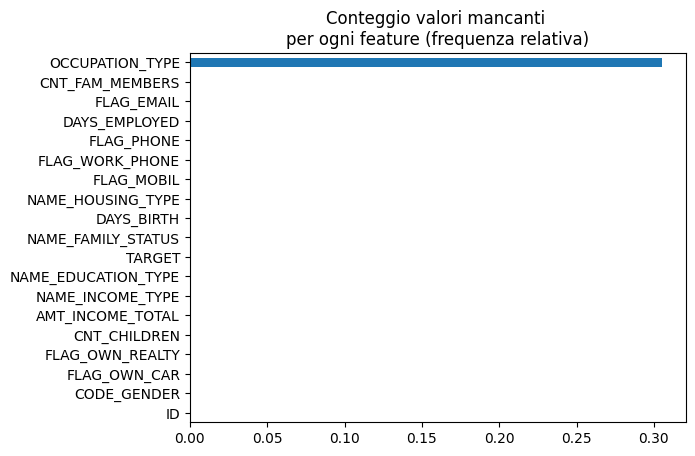

In [ ]:
#Percentuale dei valori mancanti di ogni colonna
missing_values_abs= df.isna().sum()
print("Conteggio valori mancanti per ogni feature:\n",missing_values_abs)
missing_values_percentage = df.isna().sum()/df.shape[0]
print("\nConteggio valori mancanti per ogni feature (frequenza relativa):\n\n",missing_values_percentage.sort_values().round(6))
missing_values_percentage.sort_values().plot(kind="barh")
print("\n")
plt.title("Conteggio valori mancanti \nper ogni feature (frequenza relativa)")
plt.show()

- Dall'analisi dei valori nulli all'interno del dataset si osserva che molte features hanno un singolo valore mancante. E' probabile che in una singola riga non siano state registrate molte features. Per scrupolo andiamo ad analizzare una riga con una features d'esempio ("NAME_FAMILY_STATUS"):

In [ ]:
df[df["NAME_FAMILY_STATUS"].isna()]

ID CODE_GENDER FLAG_OWN_CAR FLAG_OWN_REALTY  CNT_CHILDREN  \
338426  6392180           F            N               N             0   

        AMT_INCOME_TOTAL NAME_INCOME_TYPE NAME_EDUCATION_TYPE  \
338426          68765.48          Working      Secondary / se   

       NAME_FAMILY_STATUS NAME_HOUSING_TYPE  DAYS_BIRTH  DAYS_EMPLOYED  \
338426                NaN               NaN         NaN            NaN   

        FLAG_MOBIL  FLAG_WORK_PHONE  FLAG_PHONE  FLAG_EMAIL OCCUPATION_TYPE  \
338426         NaN              NaN         NaN         NaN             NaN   

        CNT_FAM_MEMBERS  TARGET  
338426              NaN       0

Si osserva che la riga indicizzata nel dataset come 338426, appartenente all'ID cliente 6392180, corrisponde a un'osservazione non informativa poiché oltre il 50% delle sue features è costituito da valori nulli. Pertanto, procederemo alla rimozione di questa osservazione, considerando che la perdita di informazione stimata sul dataset è pari allo 0,000003% del totale delle osservazioni.








In [ ]:
df= df.drop(index=338426)

A questo punto, andiamo ad analizzare le righe in cui la variabile "occupation type" presenta valori mancanti, poiché queste osservazioni corrispondono a 103.341 valori nulli, pari a circa il 30% delle registrazioni di questa feature sull'intero dataset.










In [ ]:
df[df["OCCUPATION_TYPE"].isna()]

ID CODE_GENDER FLAG_OWN_CAR FLAG_OWN_REALTY  CNT_CHILDREN  \
0       5008804           M            Y               Y             0   
1       5008805           M            Y               Y             0   
7       5008812           F            N               Y             0   
8       5008813           F            N               Y             0   
9       5008814           F            N               Y             0   
...         ...         ...          ...             ...           ...   
338421  6392174           F            N               Y             0   
338422  6392175           F            N               Y             0   
338423  6392177           F            N               Y             0   
338424  6392178           F            N               Y             0   
338425  6392179           F            N               Y             0   

        AMT_INCOME_TOTAL NAME_INCOME_TYPE            NAME_EDUCATION_TYPE  \
0              424380.57          Working               Higher education   
1              421593.52          Working               Higher education   
7              293089.84        Pensioner               Higher education   
8              286928.42        Pensioner               Higher education   
9              283985.28        Pensioner               Higher education   
...                  ...              ...                            ...   
338421         158685.43        Pensioner  Secondary / secondary special   
338422         158517.14        Pensioner  Secondary / secondary special   
338423         156354.84        Pensioner  Secondary / secondary special   
338424         159019.43        Pensioner  Secondary / secondary special   
338425         162723.53        Pensioner  Secondary / secondary special   

       NAME_FAMILY_STATUS  NAME_HOUSING_TYPE  DAYS_BIRTH  DAYS_EMPLOYED  \
0          Civil marriage   Rented apartment    -11778.0        -4438.0   
1          Civil marriage   Rented apartment    -11777.0        -4459.0   
7               Separated  House / apartment    -22090.0       372399.0   
8               Separated  House / apartment    -22179.0       360576.0   
9               Separated  House / apartment    -22812.0       369758.0   
...                   ...                ...         ...            ...   
338421            Married  House / apartment    -22970.0       374406.0   
338422            Married  House / apartment    -24647.0       356447.0   
338423            Married  House / apartment    -24080.0       355074.0   
338424            Married  House / apartment    -24287.0       367012.0   
338425            Married  House / apartment    -23790.0       350457.0   

        FLAG_MOBIL  FLAG_WORK_PHONE  FLAG_PHONE  FLAG_EMAIL OCCUPATION_TYPE  \
0              1.0              1.0         0.0         0.0             NaN   
1              1.0              1.0         0.0         0.0             NaN   
7              1.0              0.0         0.0         0.0             NaN   
8              1.0              0.0         0.0         0.0             NaN   
9              1.0              0.0         0.0         0.0             NaN   
...            ...              ...         ...         ...             ...   
338421         1.0              0.0         0.0         0.0             NaN   
338422         1.0              0.0         0.0         0.0             NaN   
338423         1.0              0.0         0.0         0.0             NaN   
338424         1.0              0.0         0.0         0.0             NaN   
338425         1.0              0.0         0.0         0.0             NaN   

        CNT_FAM_MEMBERS  TARGET  
0                   2.0       0  
1                   2.0       0  
7                   1.0       0  
8                   1.0       0  
9                   1.0       0  
...                 ...     ...  
338421              2.0       0  
338422              2.0       0  
338423              2.0       0  
338424              2

In [ ]:
df["OCCUPATION_TYPE"].nunique(), df["OCCUPATION_TYPE"].unique()

(18,
 array([nan, 'Security staff', 'Sales staff', 'Accountants', 'Laborers',
        'Managers', 'Drivers', 'Core staff', 'High skill tech staff',
        'Cleaning staff', 'Private service staff', 'Cooking staff',
        'Low-skill Laborers', 'Medicine staff', 'Secretaries',
        'Waiters/barmen staff', 'HR staff', 'Realty agents', 'IT staff'],
       dtype=object))

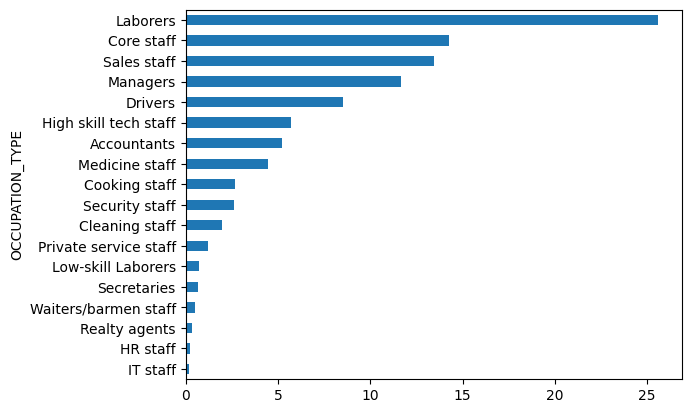

In [ ]:
(df["OCCUPATION_TYPE"].value_counts(normalize=True)*100).sort_values().round(2).plot(kind="barh")
plt.show()

Osserviamo che le righe in cui la variabile "occupation_type" assume valore nullo contengono comunque informazioni rilevanti. Poiché il numero di queste osservazioni è elevato, ho deciso di riempire i valori mancanti creando una sottoclasse denominata "another_jobs_class", che raccoglie tutte le osservazioni nulle e definisce un livello specifico per queste istanze.










In [ ]:
df2=df.copy()
df2["OCCUPATION_TYPE"].fillna("another_jobs_class", inplace=True)

<ipython-input-13-55daeb643191>:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df2["OCCUPATION_TYPE"].fillna("another_jobs_class", inplace=True)


In [ ]:
df2.head()

ID CODE_GENDER FLAG_OWN_CAR FLAG_OWN_REALTY  CNT_CHILDREN  \
0  5008804           M            Y               Y             0   
1  5008805           M            Y               Y             0   
2  5008806           M            Y               Y             0   
3  5008808           F            N               Y             0   
4  5008809           F            N               Y             0   

   AMT_INCOME_TOTAL      NAME_INCOME_TYPE            NAME_EDUCATION_TYPE  \
0         424380.57               Working               Higher education   
1         421593.52               Working               Higher education   
2         110958.51               Working  Secondary / secondary special   
3         267497.96  Commercial associate  Secondary / secondary special   
4         263419.09  Commercial associate  Secondary / secondary special   

     NAME_FAMILY_STATUS  NAME_HOUSING_TYPE  DAYS_BIRTH  DAYS_EMPLOYED  \
0        Civil marriage   Rented apartment    -11778.0        -4438.0   
1        Civil marriage   Rented apartment    -11777.0        -4459.0   
2               Married  House / apartment    -21471.0        -1144.0   
3  Single / not married  House / apartment    -18489.0        -3122.0   
4  Single / not married  House / apartment    -19093.0        -3070.0   

   FLAG_MOBIL  FLAG_WORK_PHONE  FLAG_PHONE  FLAG_EMAIL     OCCUPATION_TYPE  \
0         1.0              1.0         0.0         0.0  another_jobs_class   
1         1.0              1.0         0.0         0.0  another_jobs_class   
2         1.0              0.0         0.0         0.0      Security staff   
3         1.0              0.0         1.0         1.0         Sales staff   
4         1.0              0.0         1.0         1.0         Sales staff   

   CNT_FAM_MEMBERS  TARGET  
0              2.0       0  
1              2.0       0  
2              2.0       0  
3              1.0       1  
4              1.0       1

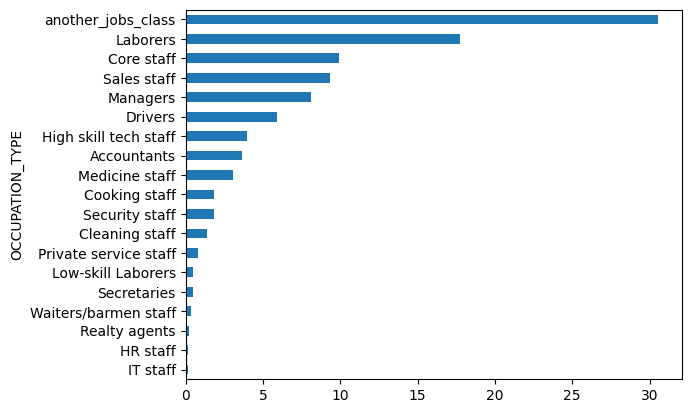

In [ ]:
(df2["OCCUPATION_TYPE"].value_counts(normalize=True)*100).sort_values().round(2).plot(kind="barh")
plt.show()

In [ ]:
df.describe()

ID   CNT_CHILDREN  AMT_INCOME_TOTAL     DAYS_BIRTH  \
count  3.384260e+05  338426.000000      3.384260e+05  338426.000000   
mean   5.821199e+06       0.428936      1.876689e+05  -15998.212897   
std    4.517700e+05       0.727991      1.107863e+05    4193.088539   
min    5.008804e+06       0.000000      2.554898e+04  -26636.000000   
25%    5.439601e+06       0.000000      1.212306e+05  -19467.000000   
50%    5.878906e+06       0.000000      1.628556e+05  -15623.000000   
75%    6.140205e+06       1.000000      2.252082e+05  -12516.250000   
max    6.841875e+06      19.000000      7.071016e+06   -7566.000000   

       DAYS_EMPLOYED  FLAG_MOBIL  FLAG_WORK_PHONE     FLAG_PHONE  \
count  338426.000000    338426.0    338426.000000  338426.000000   
mean    60234.533869         1.0         0.211379       0.293302   
std    138522.923248         0.0         0.408287       0.455276   
min    -17973.000000         1.0         0.000000       0.000000   
25%     -3116.000000         1.0         0.000000       0.000000   
50%     -1483.000000         1.0         0.000000       0.000000   
75%      -378.000000         1.0         0.000000       1.000000   
max    396498.000000         1.0         1.000000       1.000000   

          FLAG_EMAIL  CNT_FAM_MEMBERS         TARGET  
count  338426.000000    338426.000000  338426.000000  
mean        0.105181         2.197228       0.087824  
std         0.306787         0.899570       0.283040  
min         0.000000         1.000000       0.000000  
25%         0.000000         2.000000       0.000000  
50%         0.000000         2.000000       0.000000  
75%         0.000000         3.000000       0.000000  
max         1.000000        20.000000       1.000000

In [ ]:
df2["NAME_INCOME_TYPE"].value_counts()

NAME_INCOME_TYPE
Working                 174365
Commercial associate     78090
Pensioner                57841
State servant            28113
Student                     17
Name: count, dtype: int64

In [ ]:
df2[df2["NAME_INCOME_TYPE"]=="Student"]

ID CODE_GENDER FLAG_OWN_CAR FLAG_OWN_REALTY  CNT_CHILDREN  \
1464    5010456           F            N               Y             0   
1465    5010457           F            N               Y             0   
1466    5010458           F            N               Y             0   
1467    5010459           F            N               Y             0   
1468    5010460           F            N               Y             0   
1469    5010461           F            N               Y             0   
1470    5010462           F            N               Y             0   
1471    5010463           F            N               Y             0   
6220    5025088           M            N               N             0   
6221    6063169           M            N               N             0   
6222    6063170           M            N               N             0   
16563   5047796           F            N               Y             1   
16564   5047798           F            N               Y             1   
143278  5680635           F            N               N             1   
190788  5873396           M            N               Y             2   
325209  6292012           M            Y               Y             0   
325210  6292013           M            Y               Y             0   

        AMT_INCOME_TOTAL NAME_INCOME_TYPE            NAME_EDUCATION_TYPE  \
1464           164975.53          Student               Higher education   
1465           172005.05          Student               Higher education   
1466           173159.78          Student               Higher education   
1467           168751.01          Student               Higher education   
1468           174275.61          Student               Higher education   
1469           174571.74          Student               Higher education   
1470           173936.08          Student               Higher education   
1471           172596.66          Student               Higher education   
6220           135833.28          Student               Higher education   
6221           136869.63          Student               Higher education   
6222           136037.88          Student               Higher education   
16563          112159.67          Student  Secondary / secondary special   
16564          108455.30          Student  Secondary / secondary special   
143278         228756.98          Student  Secondary / secondary special   
190788         174135.21          Student  Secondary / secondary special   
325209         161471.95          Student              Incomplete higher   
325210         160812.29          Student              Incomplete higher   

          NAME_FAMILY_STATUS  NAME_HOUSING_TYPE  DAYS_BIRTH  DAYS_EMPLOYED  \
1464                 Married  House / apartment    -18678.0        -3921.0   
1465                 Married  House / apartment    -18530.0        -3964.0   
1466                 Married  House / apartment    -18721.0        -3919.0   
1467                 Married  House / apartment    -19155.0        -3904.0   
1468                 Married  House / apartment    -18504.0        -3855.0   
1469                 Married  House / apartment    -18392.0        -3949.0   
1470                 Married  House / apartment    -18364.0        -3971.0   
1471                 Married  House / apartment    -19019.0        -3983.0   
6220    Single / not married       With parents     -8693.0         -587.0   
6221    Single / not married       With parents     -9063.0         -579.0   
6222    Single / not married       With parents     -9222.0         -583.0   
16563         Civil marriage  House / apartment    -12219.0         -809.0   
16564         Civil marriage  House / apartment    -11919.0         -797.0   
143278        Civil marriage   Rented apartment    -12509.0        -3646.0   
190788               Married  House / apartment    -17039.0         -377.0   
325209  Single / not married   Office apartment     -8280.0    

In [ ]:
#analisi stratificazioni livelli delle classi
column_list=(df2.columns)
for i, column in enumerate(column_list):
  print(f"{i}. Feature: {column} \n- tipo: {df2[column].dtypes}' e può assumere --> {df2[column].nunique()} valori unici \n- con la seguente stratificazione: {df2[(column)].unique()}\n\n")

0. Feature: ID 
- tipo: int64' e può assumere --> 338426 valori unici 
- con la seguente stratificazione: [5008804 5008805 5008806 ... 6392177 6392178 6392179]


1. Feature: CODE_GENDER 
- tipo: object' e può assumere --> 2 valori unici 
- con la seguente stratificazione: ['M' 'F']


2. Feature: FLAG_OWN_CAR 
- tipo: object' e può assumere --> 2 valori unici 
- con la seguente stratificazione: ['Y' 'N']


3. Feature: FLAG_OWN_REALTY 
- tipo: object' e può assumere --> 2 valori unici 
- con la seguente stratificazione: ['Y' 'N']


4. Feature: CNT_CHILDREN 
- tipo: int64' e può assumere --> 12 valori unici 
- con la seguente stratificazione: [ 0  1  3  2  4  5 14 19  7  9 12  6]


5. Feature: AMT_INCOME_TOTAL 
- tipo: float64' e può assumere --> 335044 valori unici 
- con la seguente stratificazione: [424380.57 421593.52 110958.51 ... 156354.84 159019.43 162723.53]


6. Feature: NAME_INCOME_TYPE 
- tipo: object' e può assumere --> 5 valori unici 
- con la seguente stratificazione: ['Work

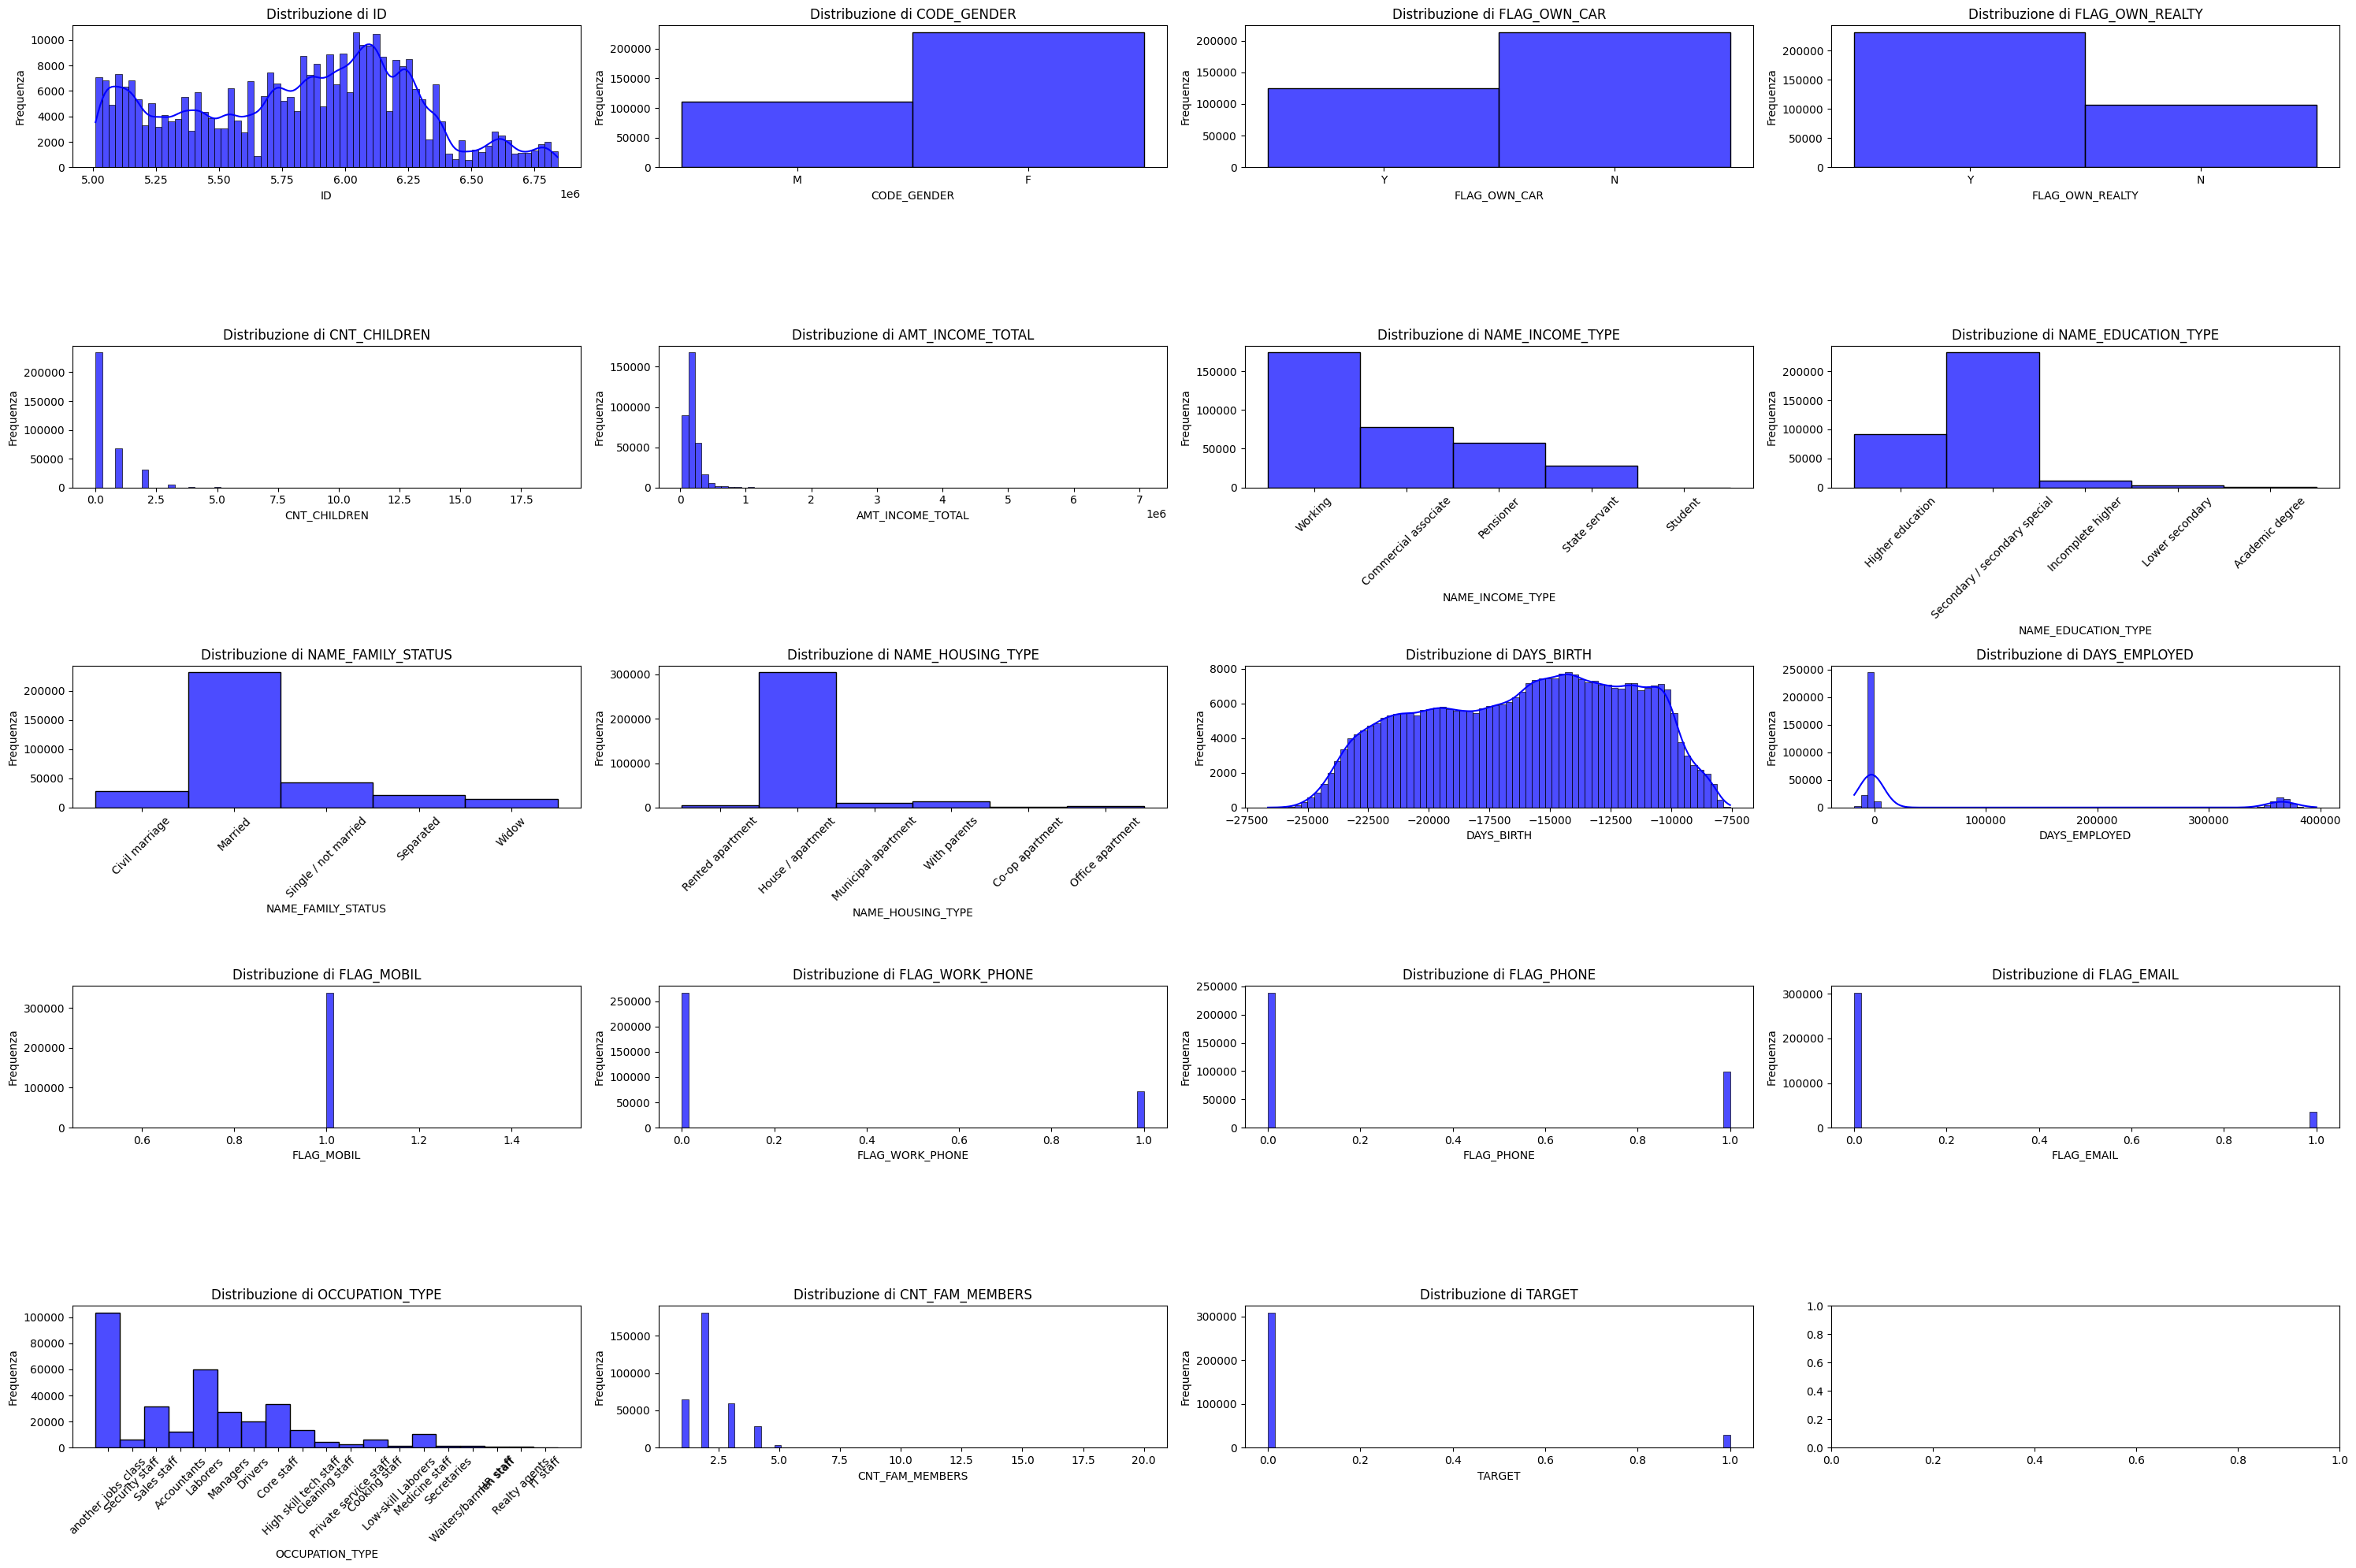

In [ ]:
features = df2.columns
fig, axes = plt.subplots(5, 4, figsize=(30, 20))
axes = axes.flatten()
for i, feature in enumerate(features):
    if pd.api.types.is_numeric_dtype(df2[feature]):
        # Se il dato è numerico
        data = df2[feature]
        if pd.api.types.is_float_dtype(data):
            data = data.dropna().astype(int)  # Rimuove NaN e converti a int
        if feature in ["ID","DAYS_BIRTH", "DAYS_EMPLOYED"]:
            # Con KDE
            sns.histplot(data,
                         bins=70,
                         kde=True,
                         edgecolor="black",
                         alpha=0.7,
                         color="blue",
                         ax=axes[i])
        else:
            # Senza KDE
            sns.histplot(data,
                         bins=70,
                         kde=False,
                         edgecolor="black",
                         alpha=0.7,
                         color="blue",
                         ax=axes[i])

    else:
        # Se il dato è non numerico (categorico)
        data = df2[feature].astype(str)
        sns.histplot(data,
                     bins=70,
                     kde=False,
                     edgecolor="black",
                     alpha=0.7,
                     color="blue",
                     ax=axes[i])
    # Titolo, etichette
    axes[i].set_title(f"Distribuzione di {feature}")
    axes[i].set_xlabel(feature)
    axes[i].set_ylabel("Frequenza")
    # Ruotazione 45° x etichette assi numerose
    if feature in ["NAME_INCOME_TYPE",
                   "NAME_EDUCATION_TYPE",
                   "NAME_FAMILY_STATUS",
                   "NAME_HOUSING_TYPE",
                   "OCCUPATION_TYPE"]:
        axes[i].tick_params(axis='x', labelrotation=45)

# Aggiungi spazio tra le righe
plt.subplots_adjust(hspace=0.5)
# Salva l'intera figura
plt.tight_layout()
#plt.savefig('grafico_completo_con_spazi.png', dpi=300, bbox_inches='tight')  #<- esporta l'output grafico complessivo in file .png
plt.show()

In [ ]:
df.describe(include='object')

CODE_GENDER FLAG_OWN_CAR FLAG_OWN_REALTY NAME_INCOME_TYPE  \
count       338426       338426          338426           338426   
unique           2            2               2                5   
top              F            N               Y          Working   
freq        227915       213195          231307           174365   

                  NAME_EDUCATION_TYPE NAME_FAMILY_STATUS  NAME_HOUSING_TYPE  \
count                          338426             338426             338426   
unique                              5                  5                  6   
top     Secondary / secondary special            Married  House / apartment   
freq                           232568             231494             304410   

       OCCUPATION_TYPE  
count           235085  
unique              18  
top           Laborers  
freq             60146

# 2. **EDA delle variabili (UNIVARIATA)**


## **2.1 - Variabili Numeriche**

### 2.1.1 - La variabili **AMT_INCOME_TOTAL** e **YEARS_BIRTH**

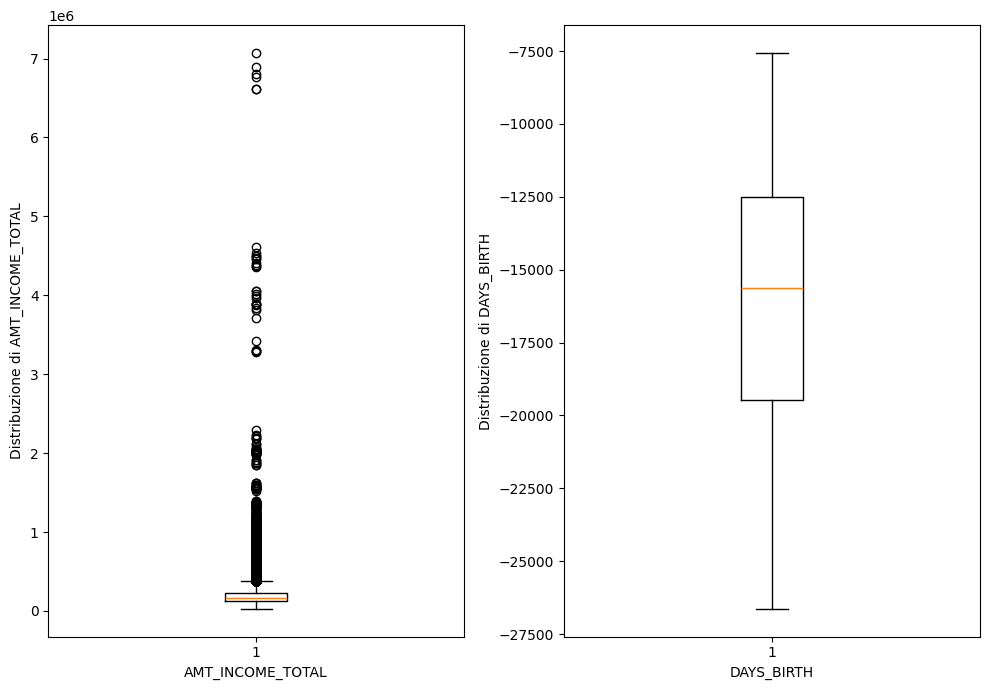

In [ ]:
#boxplot delle distribuzioni numeriche continue
fig, axes = plt.subplots(1,2,  figsize=(10,7))
axes=axes.flatten()
numerical_vars = ["AMT_INCOME_TOTAL",
                 "DAYS_BIRTH"]

for i, feature in enumerate(numerical_vars):
        axes[i].boxplot(df2[feature])
        axes[i].set_xlabel(feature)
        axes[i].set_ylabel(f"Distribuzione di {feature}")

n_features = len(numerical_vars)
for j in range(n_features, len(axes)):
    axes[j].axis('off')

plt.tight_layout(pad=0,    # spazio complessivo intorno ai subplot
                 h_pad=0.1,  # spazio **tra** le righe
                 w_pad=0.4)  # spazio **tra** le colonne

plt.tight_layout()
plt.show()

La variabile numerica **AMT_INCOME_TOTAL** mostra una distribuzione fortemente asimmetrica, con la maggior parte dei redditi concentrata su valori bassi e la presenza di numerosi outlier a valori elevati. Questo pattern, tipico delle distribuzioni di reddito, può influenzare negativamente test statistici e modelli sensibili alle distanze. Per mitigare tali effetti, verrà applicata una trasformazione logaritmica in base 10, resa possibile dall'assenza di valori negativi. <br>

Per migliorare la comprensione della variabile **DAYS_BIRTH**, ho preso i valori assoluti della distribuzione e convertito i giorni di nascita in anni, rinominando la features **DAYS_BIRTH** → **YEARS_BIRTH**, con valori positivi e arrotondati all’intero più vicino. In questo modo età maggiori (espresse in anni questa volta) avranno numeri maggiori, e viceversa:

In [ ]:
df2['AMT_INCOME_TOTAL'] = df2['AMT_INCOME_TOTAL'].apply(lambda x: np.log10(x))
df2["YEARS_BIRTH"]=(df2["DAYS_BIRTH"].abs()/365).round().astype(int)

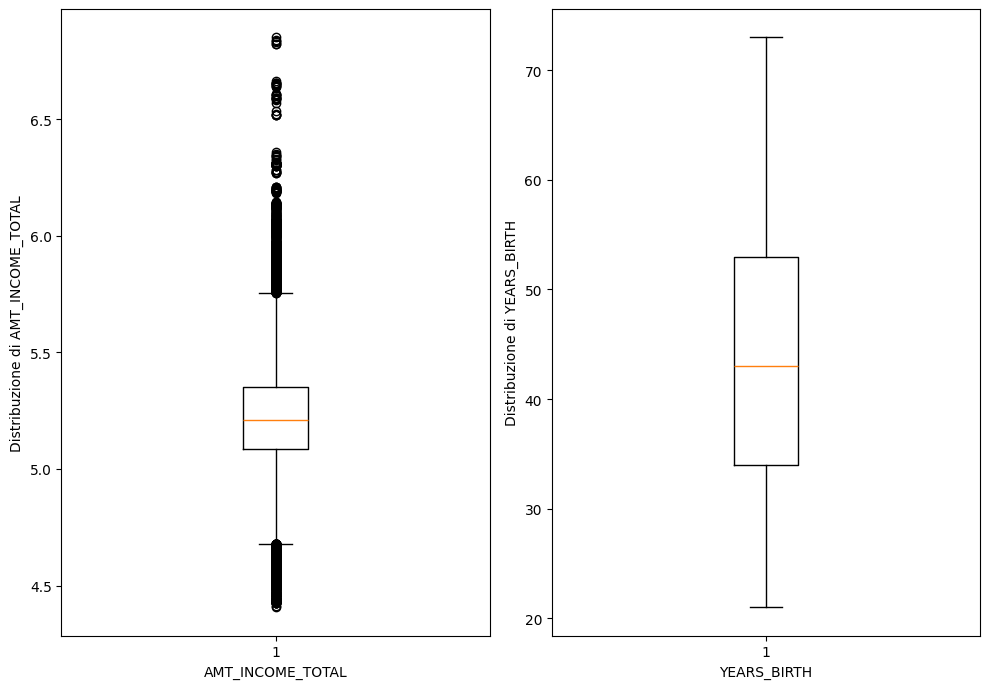

In [ ]:
#boxplot delle distribuzioni numeriche continue
fig, axes = plt.subplots(1,2,  figsize=(10,7))
axes=axes.flatten()
numerical_vars = ["AMT_INCOME_TOTAL",
                 "YEARS_BIRTH"]

for i, feature in enumerate(numerical_vars):
        axes[i].boxplot(df2[feature])
        axes[i].set_xlabel(feature)
        axes[i].set_ylabel(f"Distribuzione di {feature}")

n_features = len(numerical_vars)
for j in range(n_features, len(axes)):
    axes[j].axis('off')

plt.tight_layout(pad=0,    # spazio complessivo intorno ai subplot
                 h_pad=0.1,  # spazio **tra** le righe
                 w_pad=0.4)  # spazio **tra** le colonne

plt.tight_layout()
plt.show()

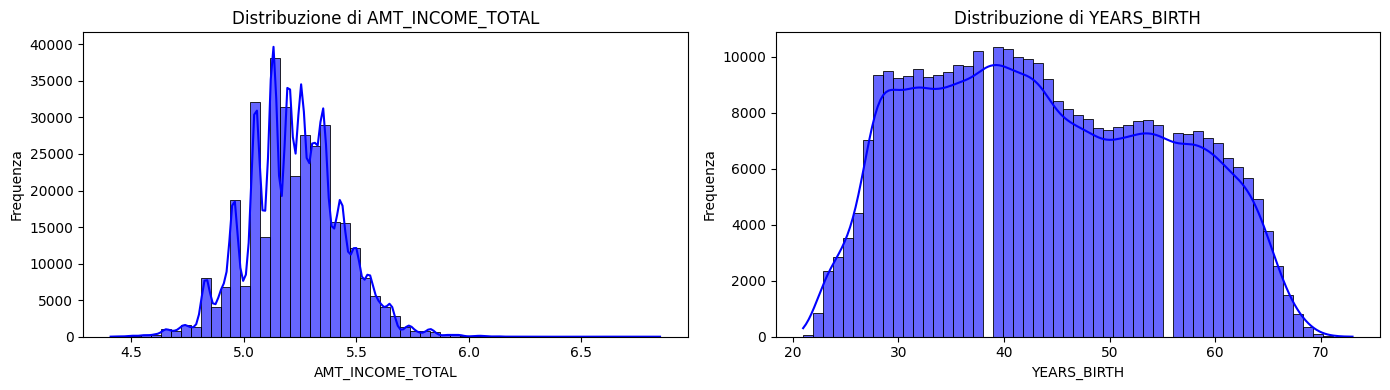

In [ ]:
numerical_vars = ["AMT_INCOME_TOTAL",
                 "YEARS_BIRTH"]
fig, axes = plt.subplots(1, 2, figsize=(14, 4))
axes = axes.flatten()
for i, feature in enumerate(numerical_vars):
    sns.histplot(df2[feature],
                 bins=55, kde=True,
                 ax=axes[i],
                 color="blue", edgecolor="black", alpha=0.6)
    axes[i].set_title(f"Distribuzione di {feature}")
    axes[i].set_xlabel(feature)
    axes[i].set_ylabel("Frequenza")

n_features = len(numerical_vars)
for j in range(n_features, len(axes)):
    axes[j].axis('off')

plt.tight_layout()
plt.show()

skewtest di AMT_INCOME_TOTAL --> SkewtestResult(statistic=np.float64(36.54999284156712), pvalue=np.float64(1.7836098026647372e-292))
Distribuzione NON SIMMETRICA
AMT_INCOME_TOTAL ---> ShapiroResult(statistic=np.float64(0.9953519002123223), pvalue=np.float64(2.434268982582354e-59))
NON NORMALE
p-value Kolmogorov-Smirnov : 0.0
NON NORMALE SECONDO Kolmogorov-Smirnov


skewtest di YEARS_BIRTH --> SkewtestResult(statistic=np.float64(40.74221652742368), pvalue=np.float64(0.0))
Distribuzione NON SIMMETRICA
YEARS_BIRTH ---> ShapiroResult(statistic=np.float64(0.9682908271372341), pvalue=np.float64(3.4577099642668906e-104))
NON NORMALE
p-value Kolmogorov-Smirnov : 0.0
NON NORMALE SECONDO Kolmogorov-Smirnov




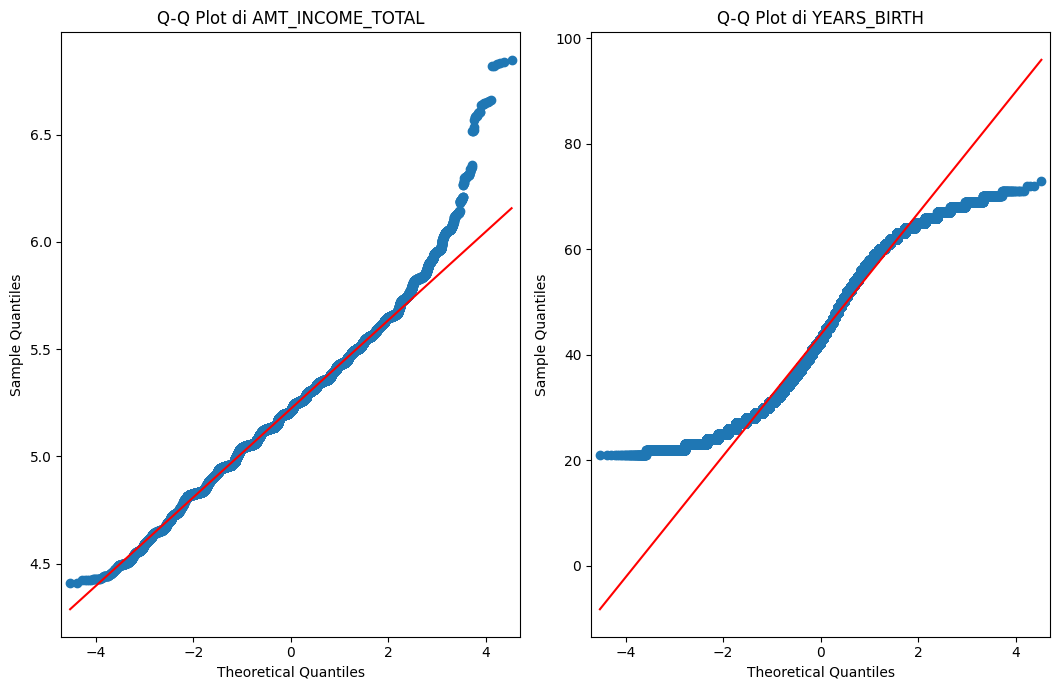

AMT_INCOME_TOTAL  YEARS_BIRTH
count         338426.00    338426.00
mean               5.22        43.83
std                0.21        11.49
min                4.41        21.00
25%                5.08        34.00
50%                5.21        43.00
75%                5.35        53.00
max                6.85        73.00

In [ ]:
warnings.filterwarnings("ignore", category=UserWarning, message=".*shapiro.*")
numerical_vars = ["AMT_INCOME_TOTAL",
                 "YEARS_BIRTH"]
rows, cols = 1, 3
fig, axes = plt.subplots(rows, cols, figsize=(16, 7))
axes = axes.flatten()
for idx, var in enumerate(numerical_vars):
    ax = axes[idx]
    # Q-Q Plot
    sm.qqplot(df2[var], line="s", ax=ax)
    ax.set_title(f"Q-Q Plot di {var}")
    skew_test = skewtest(df2[var])
    print(f"skewtest di {var} --> {skew_test}")
    if skew_test.pvalue > 0.05:
        print("Distribuzione SIMMETRICA\n")
    else:
        print("Distribuzione NON SIMMETRICA")
    # Test di normalità di Shapiro-Wilk
    shapiro_test = shapiro(df2[var])
    print(f"{var} ---> {shapiro_test}")
    if shapiro_test.pvalue > 0.05:
        print("NORMALE")
    else:
        print("NON NORMALE")
    # Test di Kolmogorov-Smirnov
    stat, p_value = kstest(df2[var], 'norm')
    print(f"p-value Kolmogorov-Smirnov : {p_value}")
    if p_value > 0.05:
        print("NORMALE SECONDO Kolmogorov-Smirnov\n\n")
    else:
        print("NON NORMALE SECONDO Kolmogorov-Smirnov\n\n")
# Nasconde eventuali assi vuoti se ci sono meno di 16 grafici
for j in range(idx + 1, len(axes)):
    fig.delaxes(axes[j])
plt.tight_layout()
plt.show()
#indici di posizione e variabilità
df2[numerical_vars].describe().round(2)

### 2.1.2 - Studio della variabile numerica "DAYS_EMPLOYED"

Approfondiamo a parte la features "DAYS_EMPLOYED", in quanto la distribuzione ha un range molto ampio con molti outlier:

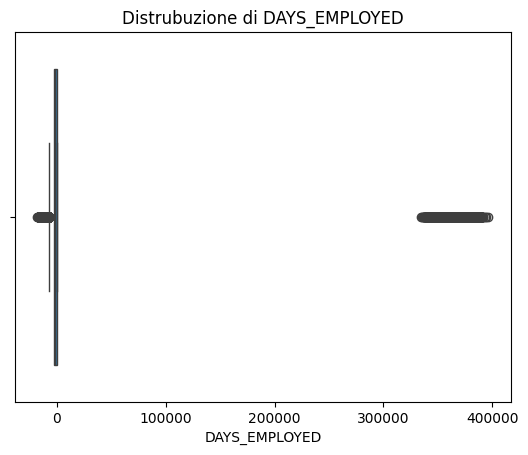

In [ ]:
sns.boxplot(data=df2,
            x="DAYS_EMPLOYED")
plt.title("Distrubuzione di DAYS_EMPLOYED")
plt.show()

È possibile osservare come la distribuzione presenti outlier evidenti nella coda destra. In base alla definizione di questa feature nel dataset, i valori positivi rappresentano il tempo di inoccupazione del cliente (espresso in giorni), mentre i valori negativi indicano da quanti giorni il cliente è occupato lavorativamente alla data di presentazione della domanda di rilascio della carta di credito.

Per migliorare la leggibilità della distribuzione, divideremo i giorni per 365, trasformando la variabile **"DAYS\_EMPLOYED"** in anni. La nuova variabile verrà denominata **"YEARS\_EMPLOYED"**. Successivamente, verranno riprodotti il boxplot e la distribuzione di frequenza per visualizzare meglio il comportamento della variabile trasformata.


In [ ]:
df2['YEARS_EMPLOYED'] = df2['DAYS_EMPLOYED'] / 365

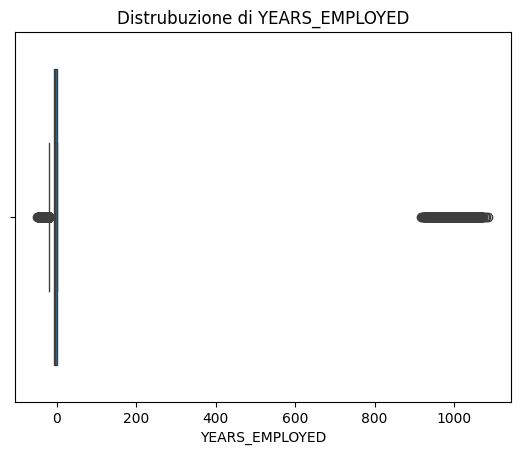

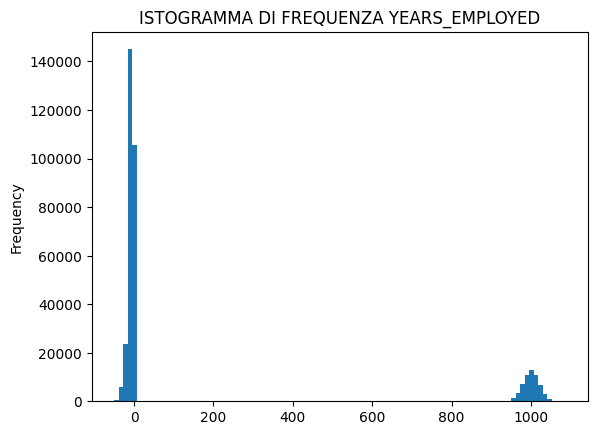

In [ ]:
sns.boxplot(data=df2,
            x="YEARS_EMPLOYED")
plt.title("Distrubuzione di YEARS_EMPLOYED")
plt.show()

df2["YEARS_EMPLOYED"].plot(kind="hist", bins=100)
plt.title("ISTOGRAMMA DI FREQUENZA YEARS_EMPLOYED")
plt.show()

Riscalando i due grafici in anni, si osserva che gli outliers di persone con valore positivo di occupazione, ovvero il tempo in anni dell'ultima occupazione, sono posizionate sull'asse delle ascisse intorno ai 1000 anni, e cioè un risultato paradossale. Andiamo a vedere meglio di che si tratta:

In [ ]:
df2[df2["YEARS_EMPLOYED"]>0]["NAME_INCOME_TYPE"].value_counts()

NAME_INCOME_TYPE
Pensioner    57841
Name: count, dtype: int64

Ecco la versione corretta in italiano:

Si osserva che 57.481 osservazioni corrispondono a un unico valore di **NAME\_INCOME\_TYPE**, ovvero **"Pensioner"**. Questo indica una distribuzione molto sbilanciata, caratterizzata da un valore anomalo assegnato ai pensionati.

Per rendere questa feature più interpretabile, potremmo razionalizzarla suddividendo i lavoratori in classi basate sulla **maturità di carriera**, raggruppando i pensionati in una singola classe e suddividendo il resto delle osservazioni in ulteriori bins che definiscono fasce di tempo di occupazione.

Prima di procedere, sarà necessario analizzare la parte inferiore della distribuzione — quella negativa — che rappresenta il periodo di occupazione, per comprendere meglio come effettuare una suddivisione coerente.


bin_sturges
(-50.377, 7.536]        280585
(7.536, 64.313]              0
(64.313, 121.089]            0
(121.089, 177.866]           0
(177.866, 234.643]           0
(234.643, 291.42]            0
(291.42, 348.197]            0
(348.197, 404.974]           0
(404.974, 461.751]           0
(461.751, 518.527]           0
(518.527, 575.304]           0
(575.304, 632.081]           0
(632.081, 688.858]           0
(688.858, 745.635]           0
(745.635, 802.412]           0
(802.412, 859.188]           0
(859.188, 915.965]           0
(915.965, 972.742]        4853
(972.742, 1029.519]      48708
(1029.519, 1086.296]      4280
Name: count, dtype: int64


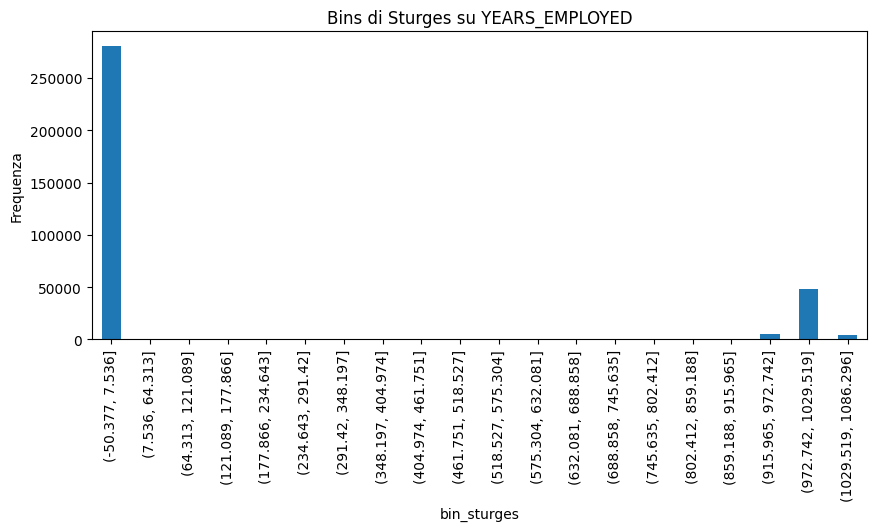

In [ ]:
# numero di bin secondo Sturges
k = int(np.ceil(1 + np.log2(len(df2))))
df2['bin_sturges'] = pd.cut(df2['YEARS_EMPLOYED'], bins=k)

# distribuzione di frequenza
counts = df2['bin_sturges'].value_counts().sort_index()
print(counts)

#istogramma
counts.plot.bar(figsize=(10,4))
plt.xticks(rotation=90)
plt.ylabel("Frequenza")
plt.title("Bins di Sturges su YEARS_EMPLOYED")
plt.show()

Escludendo gli outlier positivi presenti nella coda destra della distribuzione (pensionati), notiamo che 280.585 osservazioni sono comprese tra **50,377 anni** e **7,536 anni**. A questo punto, effettueremo un'analisi più dettagliata su questa porzione della distribuzione per verificare se essa sia composta esclusivamente da persone attualmente occupate o se vi sia anche una fascia di clientela inoccupata da pochi anni (valori leggermente superiori allo zero).
  

In [ ]:
# Filtro i record nel primo bin
left_int=-50.135
right_int=7.536
bin1 = df2[df2['bin_sturges'] == pd.Interval(left=left_int,
                                             right=right_int)]
# Controllo se ci sono valori positivi
positivi = bin1[df2['YEARS_EMPLOYED'] > 0]
print(f"Valori positivi nel primo bin: {len(positivi)}")

Valori positivi nel primo bin: 0


<ipython-input-32-a03ab314aa0b>:7: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  positivi = bin1[df2['YEARS_EMPLOYED'] > 0]


Non ci sono valori positivi nel primo bins. Andiamo ancora più ne dettaglio e cerchiamo di capire con quali occorrenze si distribuiscono le fascie di età lavorativa:

<ipython-input-33-acf30be72853>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subset['bin_sturges'] = pd.cut(subset['YEARS_EMPLOYED'], bins=k)


Distribuzione di Frequenza Cumulativa % degli occupati 
 bin_sturges
(-49.29, -46.781]       0.002138
(-46.781, -44.32]       0.012118
(-44.32, -41.86]        0.044906
(-41.86, -39.399]       0.124027
(-39.399, -36.939]      0.255538
(-36.939, -34.479]      0.496463
(-34.479, -32.018]      0.847515
(-32.018, -29.558]      1.357877
(-29.558, -27.097]      2.130549
(-27.097, -24.637]      3.041503
(-24.637, -22.177]      4.281412
(-22.177, -19.716]      6.108666
(-19.716, -17.256]      8.224959
(-17.256, -14.795]     11.426484
(-14.795, -12.335]     16.743589
(-12.335, -9.875]      24.061514
(-9.875, -7.414]       36.550421
(-7.414, -4.954]       52.782223
(-4.954, -2.493]       75.316214
(-2.493, -0.0329]     100.000000
Name: proportion, dtype: float64


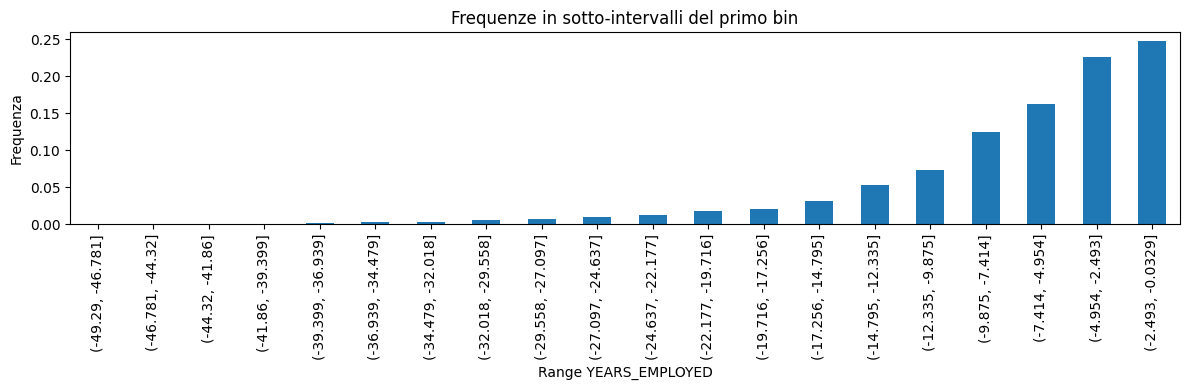

In [ ]:
subset = df2[(df2['YEARS_EMPLOYED'] > left_int) &
             (df2['YEARS_EMPLOYED'] <= right_int)]
k = int(np.ceil(1 + np.log2(len(subset))))  # Sturges rule
subset['bin_sturges'] = pd.cut(subset['YEARS_EMPLOYED'], bins=k)
# Conta le frequenze
counts = subset['bin_sturges'].value_counts(normalize=True).sort_index()
counts.cumsum()
print("Distribuzione di Frequenza Cumulativa % degli occupati \n", counts.cumsum()*100)
counts.plot(kind='bar', figsize=(12, 4))
plt.xticks(rotation=90)
plt.title('Frequenze in sotto-intervalli del primo bin')
plt.ylabel('Frequenza')
plt.xlabel('Range YEARS_EMPLOYED')
plt.tight_layout()
plt.show()

## 2.2 Mapping:

In questa fase di preprocessing, ho effettuato nuove operazioni di mapping per trasformare variabili numeriche o categoriche in formati più interpretabili e utili per l’analisi o il modello.

 <br>Per prima cosa, ho creato una nuova variabile categoriale per l’esperienza lavorativa (**YEARS_EMPLOYED**), raggruppando i valori in fasce temporali e distinguendo anche i pensionati, riscalando la distribuzione in anni.

Anche il numero di figli (CNT_CHILDREN) è stato categorizzato in gruppi descrittivi, così da rendere più leggibili le informazioni:

- 0 → "No Children"
- 1 → "One_child"
- 2 → "Two_children"
- 3-4 → "Three_or_four_children"
- maggiore di 5 → "Five_or_more_children"

Ho poi codificato il livello di istruzione (**NAME_EDUCATION_TYPE**) in valori ordinali numerici, coerenti con il livello educativo:

- 0 → Lower secondary (istruzione inferiore)
- 1 → Secondary / secondary special (scuola secondaria)
- 2 → Incomplete higher (università non completata)
- 3 → Higher education (laurea)
- 4 → Academic degree (titolo accademico superiore, es. dottorato)

Per la variabile relativa al tipo di abitazione (**NAME_HOUSING_TYPE**), ho accorpato alcune categorie meno frequenti in un’unica classe chiamata "Other_housing_types", al fine di ridurre la cardinalità. Lo stesso principio è stato applicato alla professione (**OCCUPATION_TYPE**), raggruppando i ruoli in macro-categorie come “Admin/IT/HR”, “Service” e “Management/Sales/Core”.

Infine, ho semplificato la variabile **CNT_FAM_MEMBERS**, trasformando i valori numerici in classi che rappresentano la dimensione del nucleo familiare (da "One" a "Large (≥7)"):

- 'One'→ per chi ha un solo membro nella famiglia (valore 1)
- 'Couple'→ per chi ha due membri (valore 2)
- 'Small (3-4)' → per famiglie con 3 o 4 membri
- 'Medium (5-6)'→ per famiglie con 5 o 6 membri
- 'Large (≥7)' → per famiglie con 7 o più membri

Infine, ho deciso di escludere le colonne **"ID" e "FLAG_MOBIL"** dall’analisi: la prima perché rappresenta un identificativo univoco e quindi non apporta alcuna informazione utile sulla variabilità dei dati, la seconda perché assume un solo valore per tutti i record, risultando quindi costante e priva di rilevanza informativa nel dataset.

In [ ]:
# mapping
df2["CODE_GENDER"]=df2["CODE_GENDER"].apply(lambda x: "0. M" if x=="M" else "1. F")
df2["FLAG_OWN_CAR"]=df2["FLAG_OWN_CAR"].apply(lambda x: "0. N" if x=="N" else "1. Y")
df2["FLAG_OWN_REALTY"]=df2["FLAG_OWN_REALTY"].apply(lambda x: "0. N" if x=="N" else "1. Y")
df2["FLAG_WORK_PHONE"]=df2["FLAG_WORK_PHONE"].apply(lambda x: "0. N" if x==0 else "1. Y")
df2["FLAG_PHONE"]=df2["FLAG_PHONE"].apply(lambda x: "0. N" if x==0 else "1. Y")
df2["FLAG_EMAIL"]=df2["FLAG_EMAIL"].apply(lambda x: "0. N" if x==0 else "1. Y")

df2['YEARS_EMPLOYED'] = df2['YEARS_EMPLOYED'].apply(
    lambda x: '5. Pensioner' if x > 0 else
              '0. 0-2 years' if -2 < x <= 0 else
              '1. 2-5 years' if -5 < x <= -2 else
              '2. 5-7 years' if -7 < x <= -5 else
              '3. 7-9 years' if -9 < x <= -7 else
              '4. 9+ years')


df2['CNT_CHILDREN'] = df2['CNT_CHILDREN'].apply(
    lambda x: '0. No_children' if x == 0 else
              '1. One_child' if x == 1 else
              '2. Two_children' if x == 2 else
              '3. Three_or_four_children' if x in [3, 4] else
              '4. Five_or_more_children')

df2['NAME_EDUCATION_TYPE'] = df2['NAME_EDUCATION_TYPE'].apply(
    lambda x: "0. Lower secondary" if x == 'Lower secondary' else
              "1. Secondary / secondary special" if x == 'Secondary / secondary special' else
              "2. Incomplete higher" if x == 'Incomplete higher' else
              "3. Higher education (degree)" if x == 'Higher education' else
              "4. Academic degree (PhD)")  # <- Academic degree


df2['NAME_HOUSING_TYPE'] = df2['NAME_HOUSING_TYPE'].apply(
    lambda x: "Other_housing_types" if x in ["Co-op apartment",
                                             "Office apartment",
                                             "Rented apartment",
                                             "Municipal apartment"] else x)

df2['OCCUPATION_TYPE'] = df2['OCCUPATION_TYPE'].apply(
    lambda x: 'Admin/IT/HR' if x in ['IT staff',
                                     'HR staff',
                                     'Secretaries',
                                     'Realty agents']
              else 'Service' if x in ['Waiters/barmen staff',
                                      'Private service staff',
                                      'Security staff',
                                      'Cooking staff',
                                      'Drivers',
                                      'Cleaning staff']
              else 'Management/Sales/Core' if x in ['Managers',
                                                    'Sales staff',
                                                    'Core staff']
              else x)

df2['CNT_FAM_MEMBERS'] = df2['CNT_FAM_MEMBERS'].apply(
    lambda x: '1. One' if x == 1 else
              '2. Couple' if x == 2 else
              '3. Small (3-4)' if 3 <= x <= 4 else
              '4. Medium (5-6)' if 5 <= x <= 6 else
              '5. Large (≥7)')

#rimozione colonne non necessarie
df2.drop("bin_sturges", axis=1, inplace=True)
df2.drop("DAYS_EMPLOYED", axis=1, inplace=True)
df2.drop("FLAG_MOBIL", axis=1, inplace=True)
df2.drop('ID', axis=1, inplace=True)
df2.drop(columns="DAYS_BIRTH", inplace=True)

----->  **Nuova Overview Generale**

Osserviamo graficamente il risultato delle operazioni di MAPPING E BINNING delle variabili:

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 338426 entries, 0 to 338425
Data columns (total 19 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   ID                   338426 non-null  int64  
 1   CODE_GENDER          338426 non-null  object 
 2   FLAG_OWN_CAR         338426 non-null  object 
 3   FLAG_OWN_REALTY      338426 non-null  object 
 4   CNT_CHILDREN         338426 non-null  int64  
 5   AMT_INCOME_TOTAL     338426 non-null  float64
 6   NAME_INCOME_TYPE     338426 non-null  object 
 7   NAME_EDUCATION_TYPE  338426 non-null  object 
 8   NAME_FAMILY_STATUS   338426 non-null  object 
 9   NAME_HOUSING_TYPE    338426 non-null  object 
 10  DAYS_BIRTH           338426 non-null  float64
 11  DAYS_EMPLOYED        338426 non-null  float64
 12  FLAG_MOBIL           338426 non-null  float64
 13  FLAG_WORK_PHONE      338426 non-null  float64
 14  FLAG_PHONE           338426 non-null  float64
 15  FLAG_EMAIL       

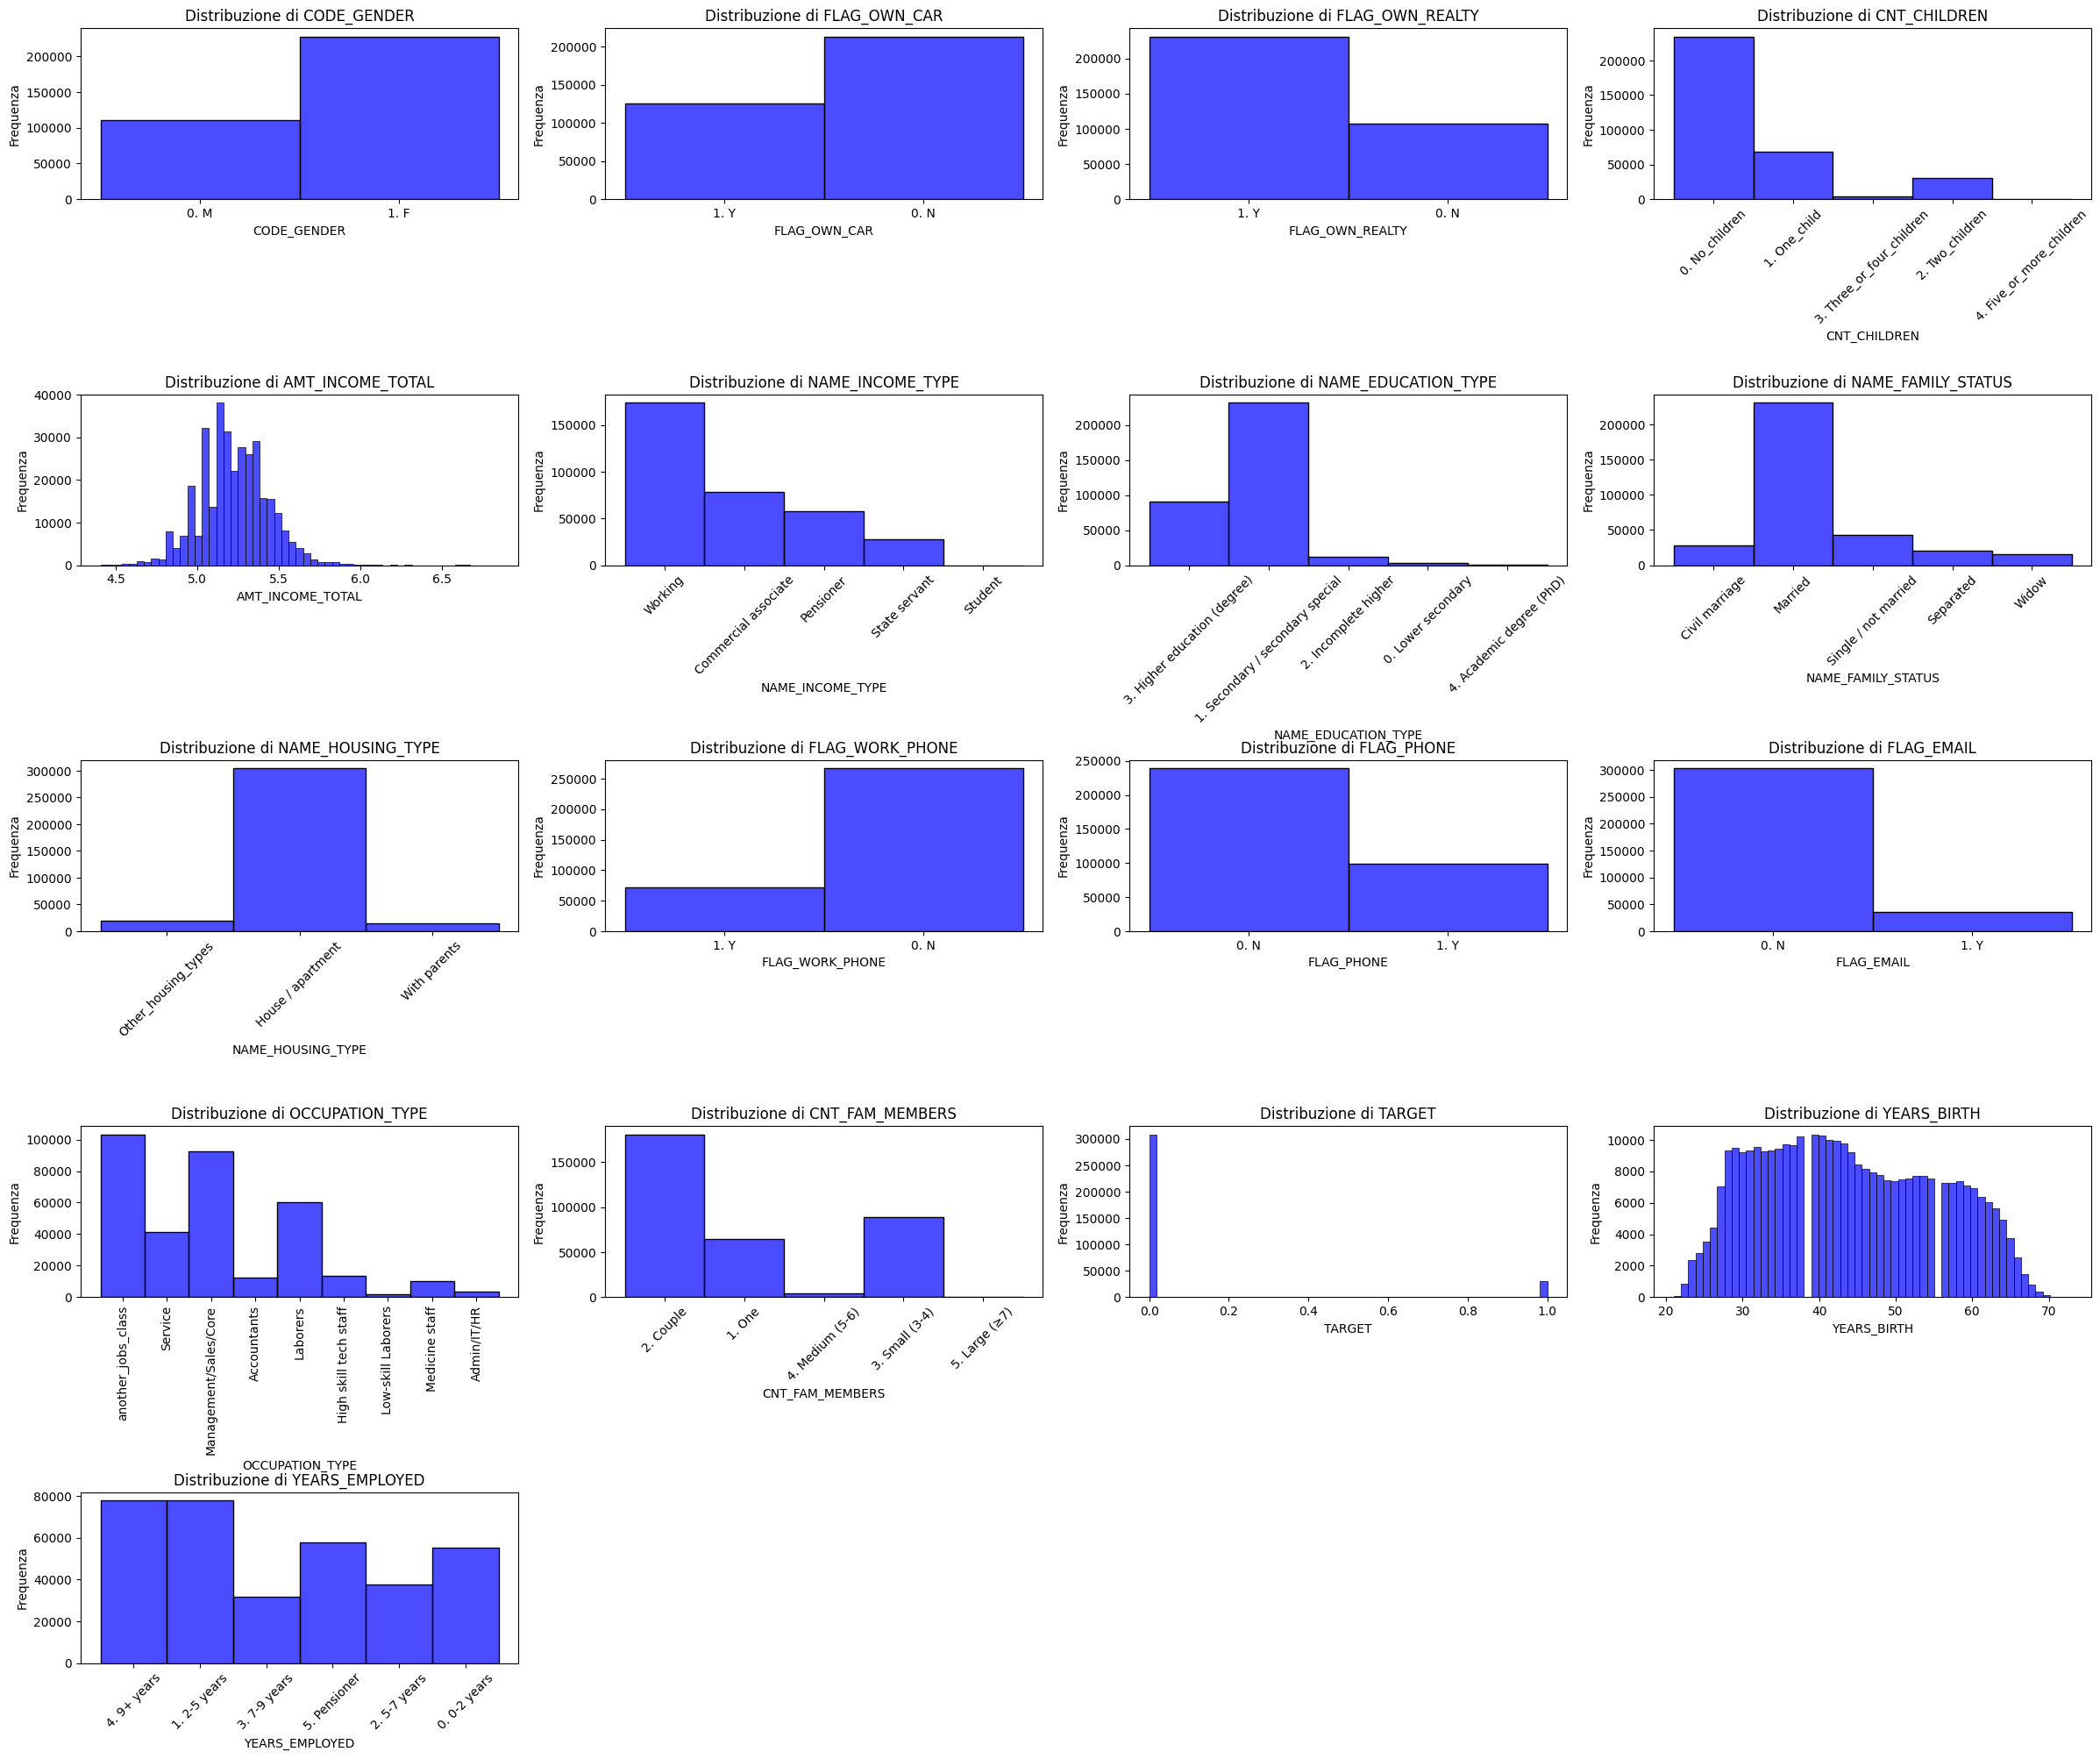

In [ ]:
import math
features   = df2.columns
n_features = len(features)
# Numero di colonne fisso, calcolo righe a runtime
n_cols = 4
n_rows = math.ceil(n_features / n_cols)
fig, axes = plt.subplots(n_rows,
                         n_cols,
                         figsize=(n_cols*6, n_rows*4))
axes = axes.flatten()
for i, feature in enumerate(features):
    ax = axes[i]
    data = df2[feature]
    if pd.api.types.is_numeric_dtype(data):
        # se float, togli NaN e cast a int per DAYS_BIRTH, DAYS_EMPLOYED, ID
        if pd.api.types.is_float_dtype(data) and feature in ["ID",
                                                             "DAYS_BIRTH"]:
            data = data.dropna().astype(int)
            sns.histplot(data, bins=55, kde=True, edgecolor="black",
                         alpha=0.7, color="blue", ax=ax)
        else:
            sns.histplot(data.dropna(), bins=55, kde=False, edgecolor="black",
                         alpha=0.7, color="blue", ax=ax)
    else:
        # categoriche
        sns.histplot(data.astype(str), bins=55, kde=False, edgecolor="black",
                     alpha=0.7, color="blue", ax=ax)
    ax.set_title(f"Distribuzione di {feature}")
    ax.set_xlabel(feature)
    ax.set_ylabel("Frequenza")
    if feature in ["NAME_INCOME_TYPE",
                   "NAME_EDUCATION_TYPE",
                   "NAME_FAMILY_STATUS",
                   "NAME_HOUSING_TYPE",
                   "YEARS_EMPLOYED",
                   "CNT_CHILDREN",
                   "CNT_FAM_MEMBERS"]:
        ax.tick_params(axis='x', labelrotation=45)
    elif feature in ["OCCUPATION_TYPE"]:
        ax.tick_params(axis='x', labelrotation=90)


# # Spegni tutti gli assi rimanenti
for j in range(n_features, len(axes)):
    axes[j].axis('off')
# Aggiungi spazio tra le righe
plt.tight_layout(pad=0.5,    # spazio complessivo intorno ai subplot
                 h_pad=-0.1,  # spazio **tra** le righe
                 w_pad=0.2)  # spazio **tra** le colonne
plt.show()

Segue l'analisi della stratificazione di ogni features dal punto di vista qualitativo (etichette livelli) e dal punto di vista quantitativo (frequenze relative dei livelli):

In [ ]:
column_list=(df2.columns)
for i, column in enumerate(column_list):
  print(f"{i}. Feature: {column} \n- tipo: {df2[column].dtypes}' e può assumere --> {df2[column].nunique()} valori unici \n- con la seguente stratificazione: {df2[(column)].unique()}\n")
  if column not in ["ID",
                    "AMT_INCOME_TOTAL",
                    "YEARS_BIRTH",
                    "YEARS_EMPLOYED"]:
                      print(f" Frequenza relativa livelli di \n{(df2[column].value_counts(normalize=True) * 100).sort_values().round(4)}\n")
                      print("----------------------------------------------------------------")

0. Feature: CODE_GENDER 
- tipo: object' e può assumere --> 2 valori unici 
- con la seguente stratificazione: ['0. M' '1. F']

 Frequenza relativa livelli di 
CODE_GENDER
0. M    32.6544
1. F    67.3456
Name: proportion, dtype: float64

----------------------------------------------------------------
1. Feature: FLAG_OWN_CAR 
- tipo: object' e può assumere --> 2 valori unici 
- con la seguente stratificazione: ['1. Y' '0. N']

 Frequenza relativa livelli di 
FLAG_OWN_CAR
1. Y    37.004
0. N    62.996
Name: proportion, dtype: float64

----------------------------------------------------------------
2. Feature: FLAG_OWN_REALTY 
- tipo: object' e può assumere --> 2 valori unici 
- con la seguente stratificazione: ['1. Y' '0. N']

 Frequenza relativa livelli di 
FLAG_OWN_REALTY
0. N    31.6521
1. Y    68.3479
Name: proportion, dtype: float64

----------------------------------------------------------------
3. Feature: CNT_CHILDREN 
- tipo: object' e può assumere --> 5 valori unici 
- con 

## 2.3 - Variabili Categoriche

In [ ]:
df2.describe(include='object')

CODE_GENDER FLAG_OWN_CAR FLAG_OWN_REALTY    CNT_CHILDREN  \
count       338426       338426          338426          338426   
unique           2            2               2               5   
top           1. F         0. N            1. Y  0. No_children   
freq        227915       213195          231307          234630   

       NAME_INCOME_TYPE               NAME_EDUCATION_TYPE NAME_FAMILY_STATUS  \
count            338426                            338426             338426   
unique                5                                 5                  5   
top             Working  1. Secondary / secondary special            Married   
freq             174365                            232568             231494   

        NAME_HOUSING_TYPE FLAG_WORK_PHONE FLAG_PHONE FLAG_EMAIL  \
count              338426          338426     338426     338426   
unique                  3               2          2          2   
top     House / apartment            0. N       0. N       0. N   
freq               304410          266890     239165     302830   

           OCCUPATION_TYPE CNT_FAM_MEMBERS YEARS_EMPLOYED  
count               338426          338426         338426  
unique                   9               5              6  
top     another_jobs_class       2. Couple   1. 2-5 years  
freq                103341          180706          78038

**INDICE DI ETEROGENEITA' DI GINI**
- Gini = 0 (massima concentrazione)
- Gini = 1 (massima eterogeneità)

In [ ]:
#definizione funzione Indice di eterogeneità di Gini:
def gini_index(data):
    total = len(data)
    freqs = Counter(data)
    gini = 1 - sum((count / total) ** 2 for count in freqs.values())
    return gini

# Lista delle feature categoriche
features = ["CODE_GENDER",
            "FLAG_OWN_CAR",
            "FLAG_OWN_REALTY",
            "CNT_CHILDREN",
            "NAME_INCOME_TYPE",
            "NAME_EDUCATION_TYPE",
            "NAME_FAMILY_STATUS",
            "NAME_HOUSING_TYPE",
            "FLAG_WORK_PHONE",
            "FLAG_PHONE",
            "FLAG_EMAIL",
            "OCCUPATION_TYPE",
            "CNT_FAM_MEMBERS",
            "YEARS_BIRTH",
            "YEARS_EMPLOYED",
            "TARGET"]

gini_list = [gini_index(df2[feature]) for feature in features]
gini_feature_pairs = list(zip(features,gini_list))
gini_feature_pairs.sort(key=lambda x: x[1],
                        reverse=True)  # Ordinato in ordine decrescente

gini_df = pd.DataFrame(gini_feature_pairs,
                       columns=["Feature",
                                "Gini Index"]).round(2)

gini_df

Feature  Gini Index
0           YEARS_BIRTH        0.98
1        YEARS_EMPLOYED        0.82
2       OCCUPATION_TYPE        0.78
3      NAME_INCOME_TYPE        0.65
4       CNT_FAM_MEMBERS        0.61
5    NAME_FAMILY_STATUS        0.50
6          CNT_CHILDREN        0.47
7          FLAG_OWN_CAR        0.47
8   NAME_EDUCATION_TYPE        0.45
9           CODE_GENDER        0.44
10      FLAG_OWN_REALTY        0.43
11           FLAG_PHONE        0.41
12      FLAG_WORK_PHONE        0.33
13           FLAG_EMAIL        0.19
14    NAME_HOUSING_TYPE        0.19
15               TARGET        0.16

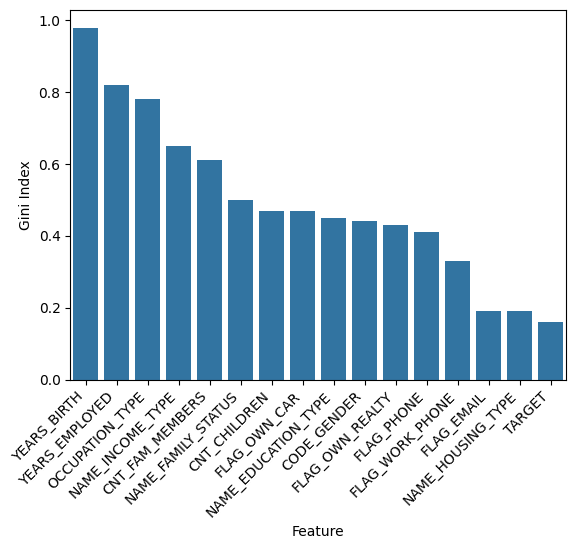

In [ ]:
from matplotlib import pyplot as plt
sns.barplot(data=gini_df,
            x="Feature",
            y="Gini Index")
plt.xticks(rotation=45, ha='right')
plt.show()

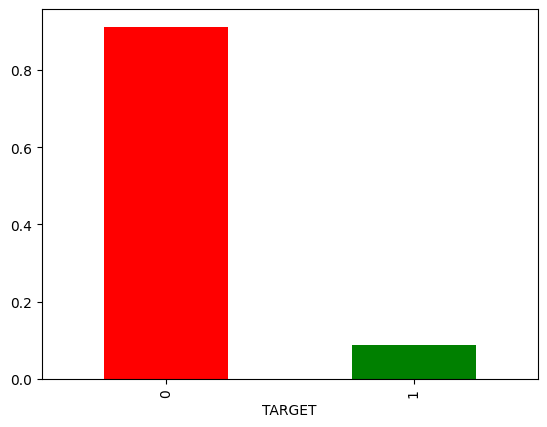

In [ ]:
df['TARGET'].value_counts(normalize=True).plot(kind='bar', color=['red', 'green'])
plt.show()

---- > la variabile di risposta **TARGET risulta sbilanciata** a favore delle risposte riguardanti clienti NON idonei al rilascio della carta di credito **(TARGET 0)**. <br> ---- > **N.B.**:Si terrà conto di tale sbilanciamento in fase di addestramento dei futuri modelli di Machine Learning

In [ ]:
column_list=(df2.columns)
for i, column in enumerate(column_list):
  print(f"{i}. Feature: {column} \n- tipo: {df2[column].dtypes}' e può assumere --> {df2[column].nunique()} valori unici \n- con la seguente stratificazione: {df2[(column)].unique()}\n")
  if column not in ["ID",
                    "AMT_INCOME_TOTAL",
                    "YEARS_BIRTH"]:
                      print(f" Frequenza relativa livelli di \n{(df2[column].value_counts(normalize=True) * 100).sort_values().round(4)}\n")
                      print("----------------------------------------------------------------")

0. Feature: CODE_GENDER 
- tipo: object' e può assumere --> 2 valori unici 
- con la seguente stratificazione: ['0. M' '1. F']

 Frequenza relativa livelli di 
CODE_GENDER
0. M    32.6544
1. F    67.3456
Name: proportion, dtype: float64

----------------------------------------------------------------
1. Feature: FLAG_OWN_CAR 
- tipo: object' e può assumere --> 2 valori unici 
- con la seguente stratificazione: ['1. Y' '0. N']

 Frequenza relativa livelli di 
FLAG_OWN_CAR
1. Y    37.004
0. N    62.996
Name: proportion, dtype: float64

----------------------------------------------------------------
2. Feature: FLAG_OWN_REALTY 
- tipo: object' e può assumere --> 2 valori unici 
- con la seguente stratificazione: ['1. Y' '0. N']

 Frequenza relativa livelli di 
FLAG_OWN_REALTY
0. N    31.6521
1. Y    68.3479
Name: proportion, dtype: float64

----------------------------------------------------------------
3. Feature: CNT_CHILDREN 
- tipo: object' e può assumere --> 5 valori unici 
- con 

# 3 . **EDA DELLE VARIABILI (BIVARIATA)**

## 3.1 **Matrice di correlazione**

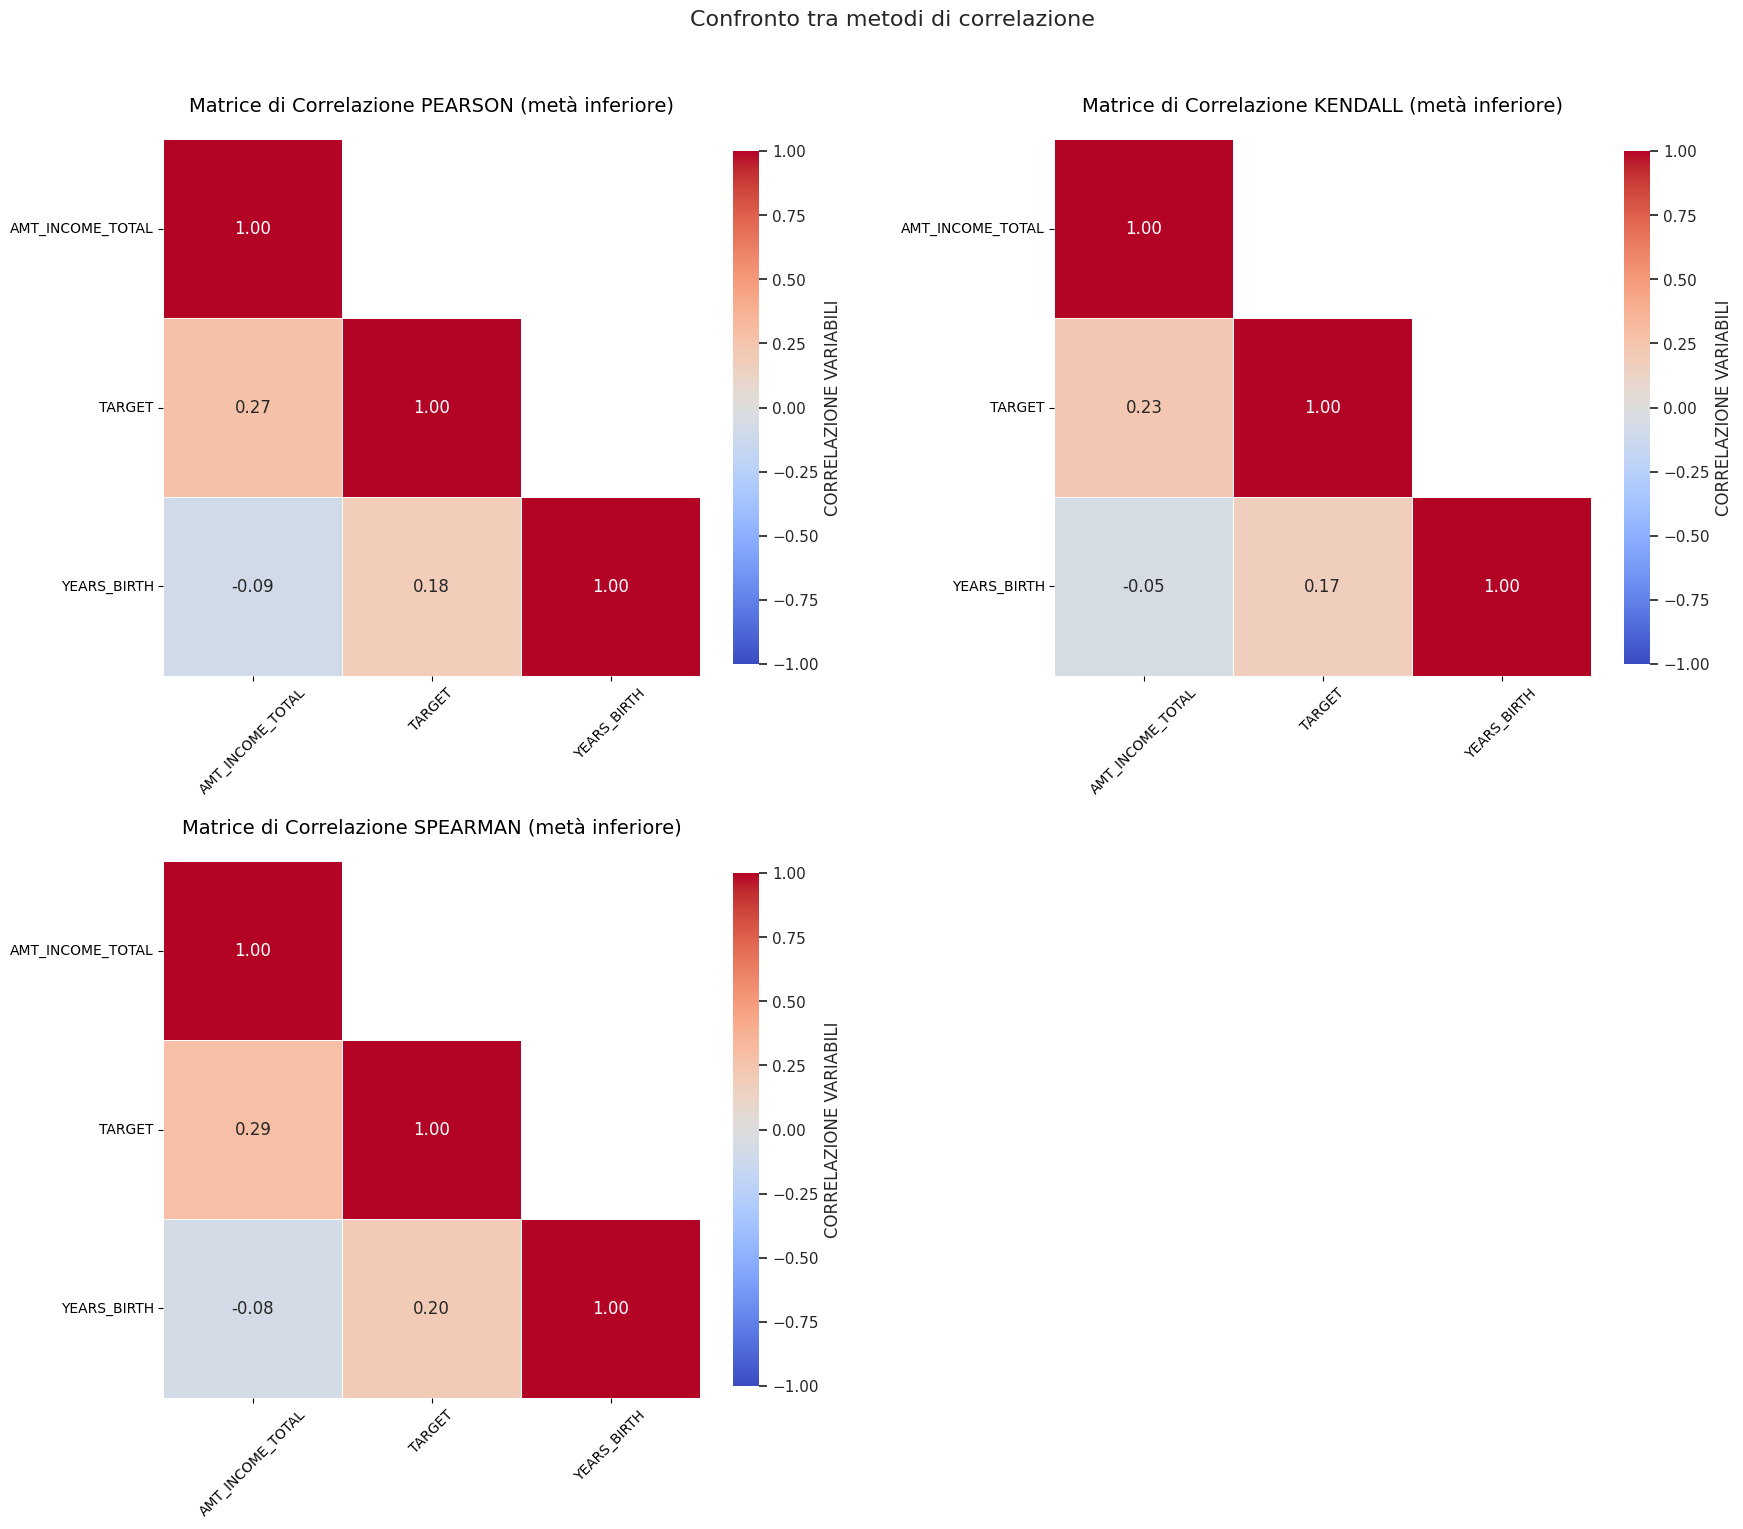

In [ ]:
methods_list=["pearson","kendall","spearman"]
fig, axes = plt.subplots(2, 2,
                         figsize=(18, 15))
axes = axes.flatten()

for i, method in enumerate(methods_list):
  method=methods_list[i]
  corr = df2.corr(method=method, numeric_only=True)
  # Mask per triangolo superiore *senza* diagonale
  mask = np.triu(np.ones_like(corr, dtype=bool), k=1)
  sns.set(style="white")
  sns.heatmap(
      corr,
      mask=mask,
      cmap="coolwarm",
      vmin=-1, vmax=1,
      annot=True, fmt=".2f",
      square=True, linewidths=.5,
      cbar_kws={"shrink": .75, "label": "CORRELAZIONE VARIABILI"},
      ax=axes[i])

  axes[i].set_title(f"Matrice di Correlazione {method.upper()} (metà inferiore)", fontsize=14, pad=20)
  axes[i].tick_params(axis='x', rotation=45)
  axes[i].tick_params(axis='y', rotation=0)

n_methods = len(methods_list)
for j in range(n_methods, len(axes)):
    fig.delaxes(axes[j])

fig.suptitle("Confronto tra metodi di correlazione", fontsize=16, y=1)
plt.subplots_adjust(hspace=0.4, wspace=2)
plt.tight_layout()
plt.show()

Dalle tabelle di correlazione, si osserva che la variabile TARGET presenta una lieve correlazione positiva con le variabili AMT_INCOME_TOTAL e YEARS_BIRTH, indicando che un incremento di una di queste due variabili è associato a un aumento della probabilità che il TARGET assuma valore 1. Approfondirò queste correlazioni nella sezione 4 (Correlazione con il Target) utilizzando il test point-biseriale di Pearson, particolarmente indicato per l'analisi di correlazioni tra variabili numeriche e variabili dicotomiche (0/1), come nel caso del TARGET.









## 3.2 **PAIRPLOTS BIVARIATI (Condizione: TARGET)**

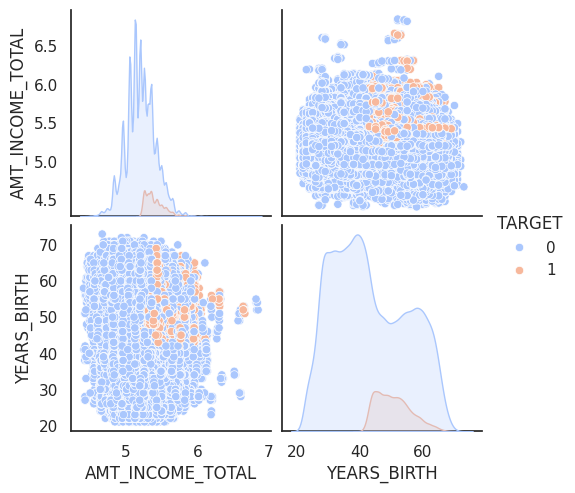

In [ ]:
sns.pairplot(data=df2[['AMT_INCOME_TOTAL', 'YEARS_BIRTH', 'TARGET']],
             hue='TARGET',
             diag_kind="kde",
             palette="coolwarm")
plt.show()

Il pairplot mostra la relazione bivariata tra 'AMT_INCOME_TOTAL' (reddito totale) e 'YEARS_BIRTH' (età) divisa per la condizione 'TARGET' ( un indicatore di affidabilità creditizia del cliente).

**Distribuzioni diagonali (kde)**: Mostrano la densità delle variabili per ciascun valore di 'TARGET'. Ad esempio, la distribuzione dell'età ('YEARS_BIRTH') sembra leggermente diversa tra i due gruppi, con possibili differenze nelle fasce d'età più a rischio.

**Grafici a dispersione**: La relazione tra reddito ed età non mostra un pattern chiaramente lineare, ma potrebbero esserci cluster o tendenze differenziate tra i gruppi 'TARGET'. Ad esempio, individui con redditi molto alti o molto bassi potrebbero essere associati a un maggior rischio.

Servirebbero ulteriori analisi (come test statistici) per confermare le osservazioni

# 4 . **CORRELAZIONE CON IL TARGET**

## 4.1 - **Visualizzazione grafica**

### 4.1.1 Istogrammi di frequenza impilati (condizionati al target)

In [ ]:
dataset_info()

ID: numero identificativo del cliente
CODE_GENDER: sesso del cliente
FLAG_OWN_CAR: indicatore del possesso di un'automobile
FLAG_OWN_REALTY: indicatore del possesso di una casa
CNT_CHILDREN: numero di figli
AMT_INCOME_TOTAL: reddito annuale
NAME_INCOME_TYPE: tipo di reddito
NAME_EDUCATION_TYPE: livello di educazione
NAME_FAMILY_STATUS: stato civile
NAME_HOUSING_TYPE: tipo di abitazione
DAYS_BIRTH: numero di giorni trascorsi dalla nascita
DAYS_EMPLOYED: numero di giorni trascorsi dalla data di assunzione (se positivo, indica il numero di giorni da quando è disoccupato)
FLAG_MOBIL: indicatore della presenza di un numero di cellulare
FLAG_WORK_PHONE: indicatore della presenza di un numero di telefono di lavoro
FLAG_PHONE: indicatore della presenza di un numero di telefono
FLAG_EMAIL: indicatore della presenza di un indirizzo email
OCCUPATION_TYPE: tipo di occupazione
CNT_FAM_MEMBERS: numero di familiari
TARGET: variabile che vale 1 se il cliente ha una elevata affidabilità creditizia (pag

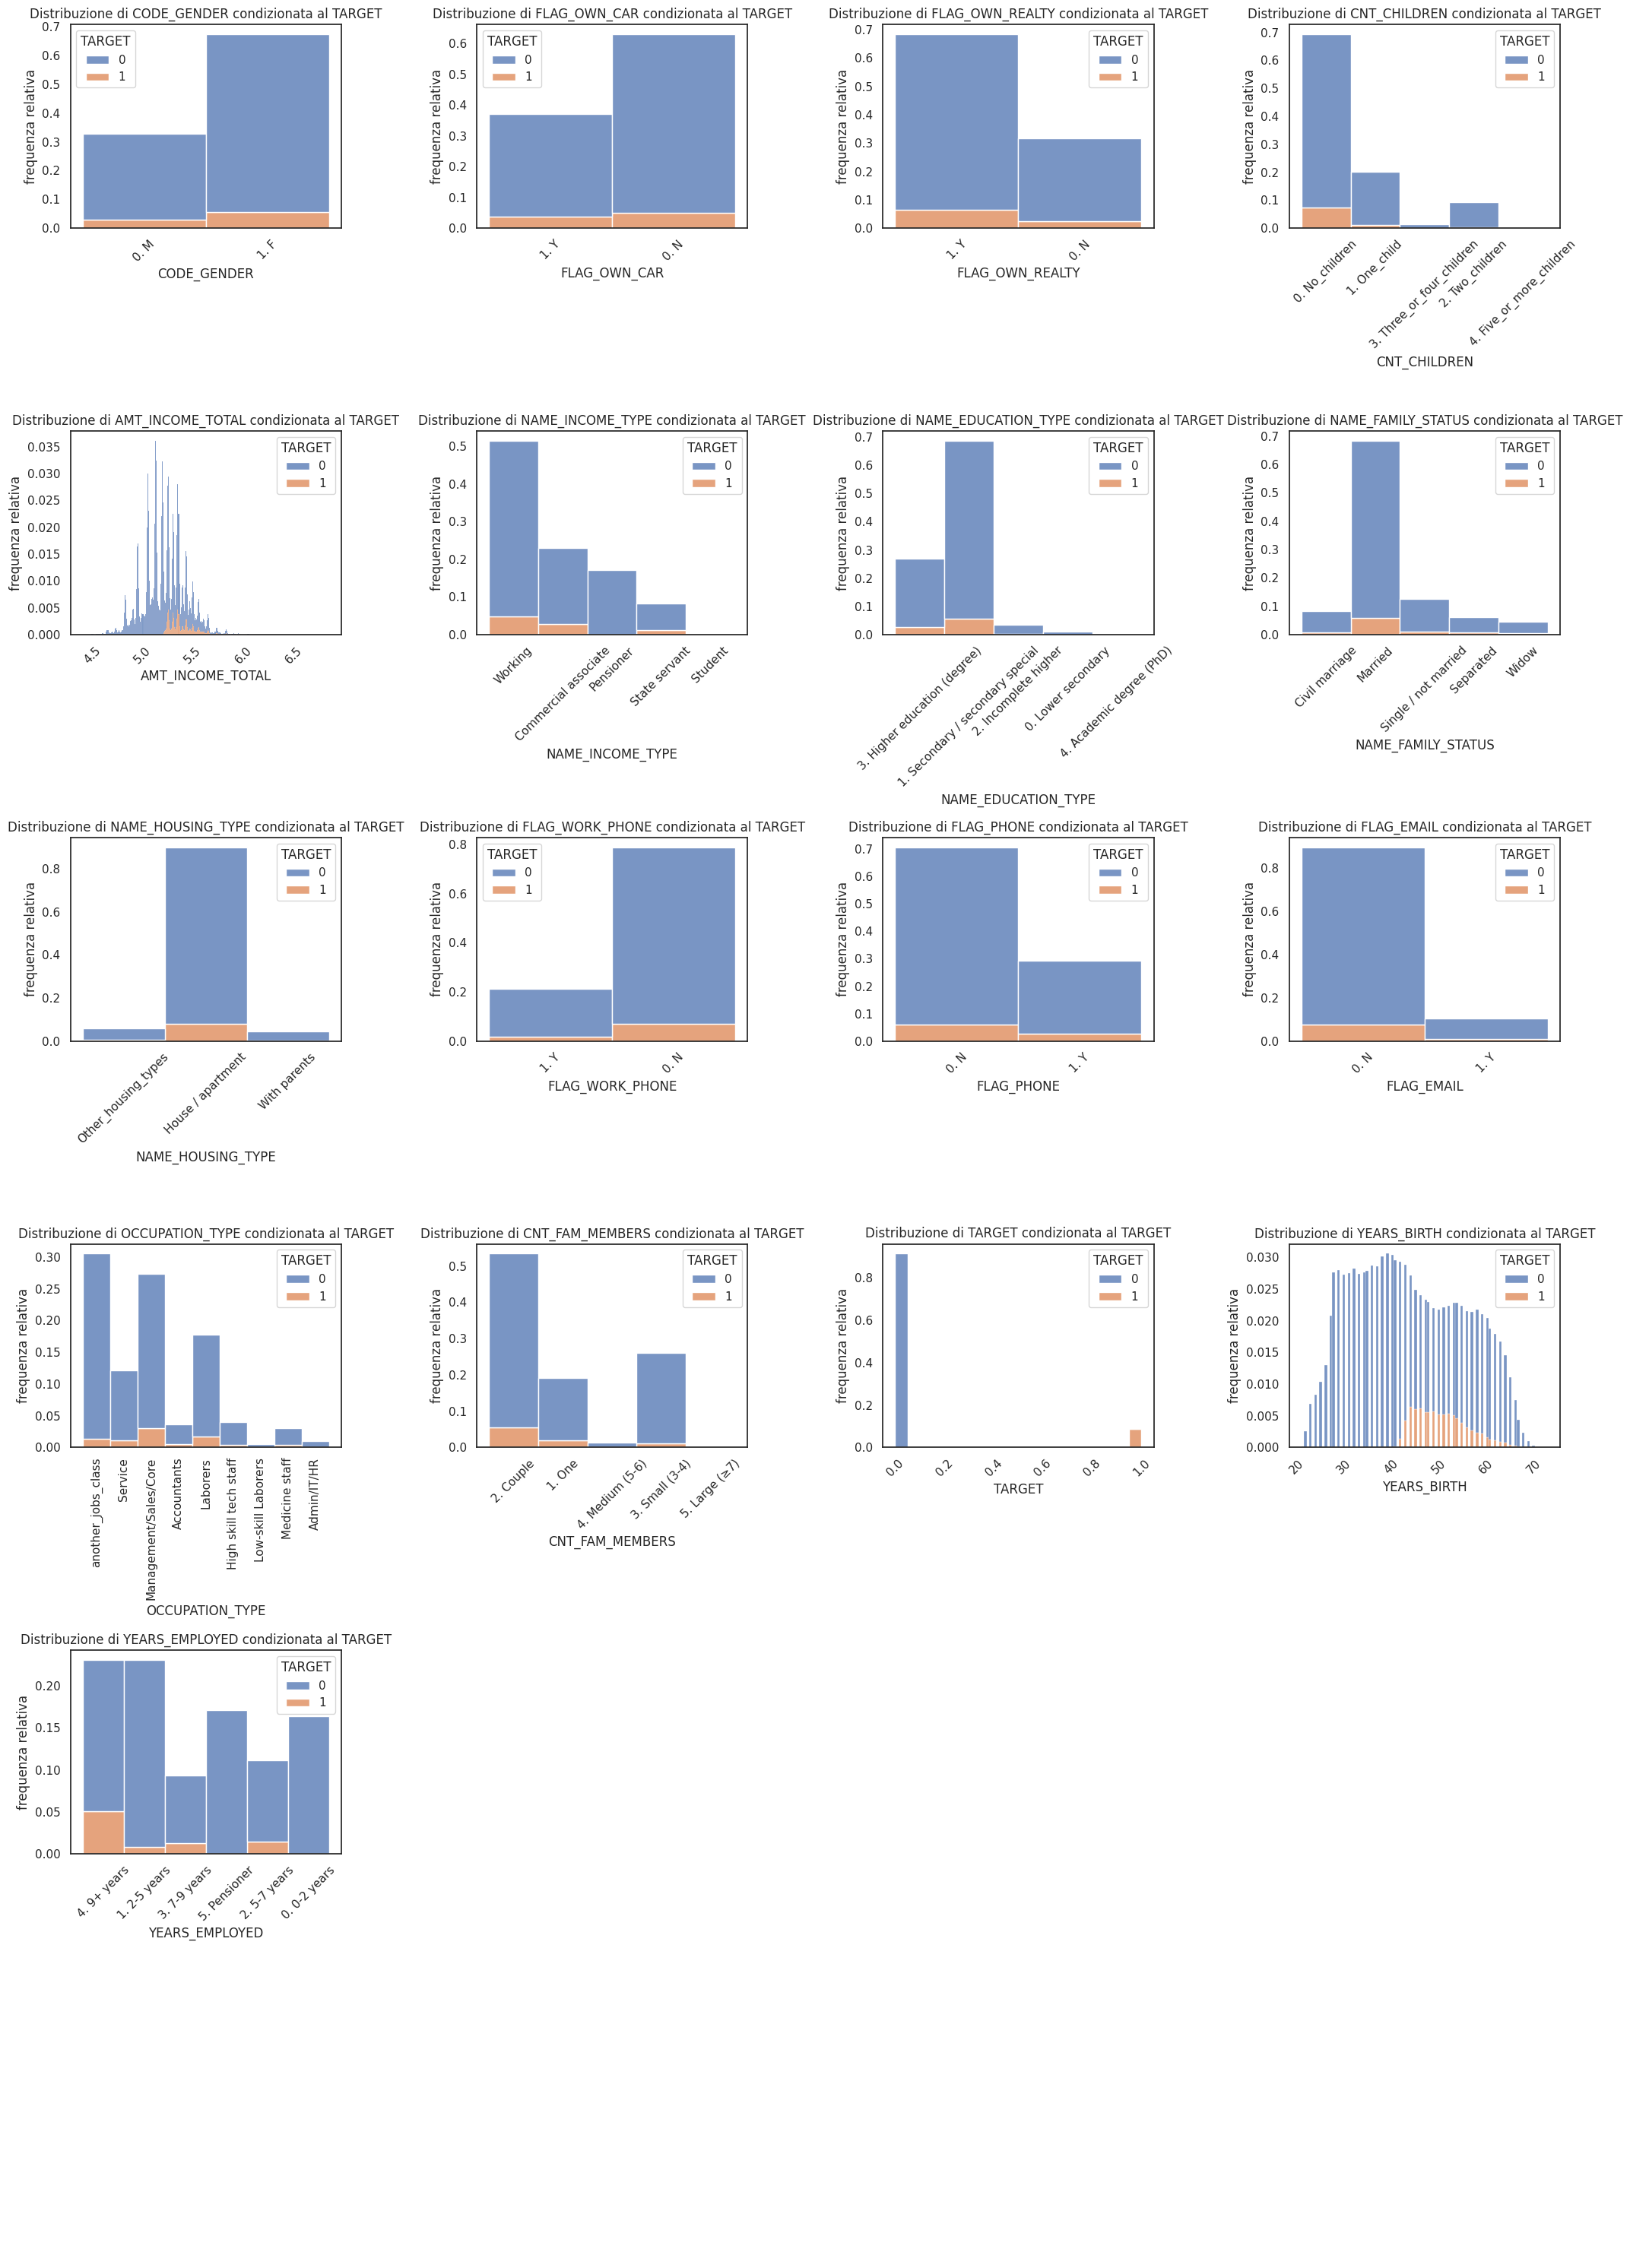

In [ ]:
fig, axes = plt.subplots(6,4,
                         figsize=(21,30))
axes=axes.flatten()
for i, feature in enumerate(df2.columns):
  sns.histplot(data = df2,
               x = feature,
               hue="TARGET",
               multiple="stack",
               stat="probability",
               ax=axes[i])
  axes[i].set_title(f"Distribuzione di {feature} condizionata al TARGET")
  axes[i].set_ylabel(f"frequenza relativa")
  if feature == "OCCUPATION_TYPE":
    axes[i].tick_params(axis='x', labelrotation=90)
  else:
    axes[i].tick_params(axis='x', rotation=45)
n_features = len(df2.columns)
for j in range(n_features, len(axes)):
  axes[j].axis("off")
plt.tight_layout()
plt.subplots_adjust(wspace=0.5)
plt.show()

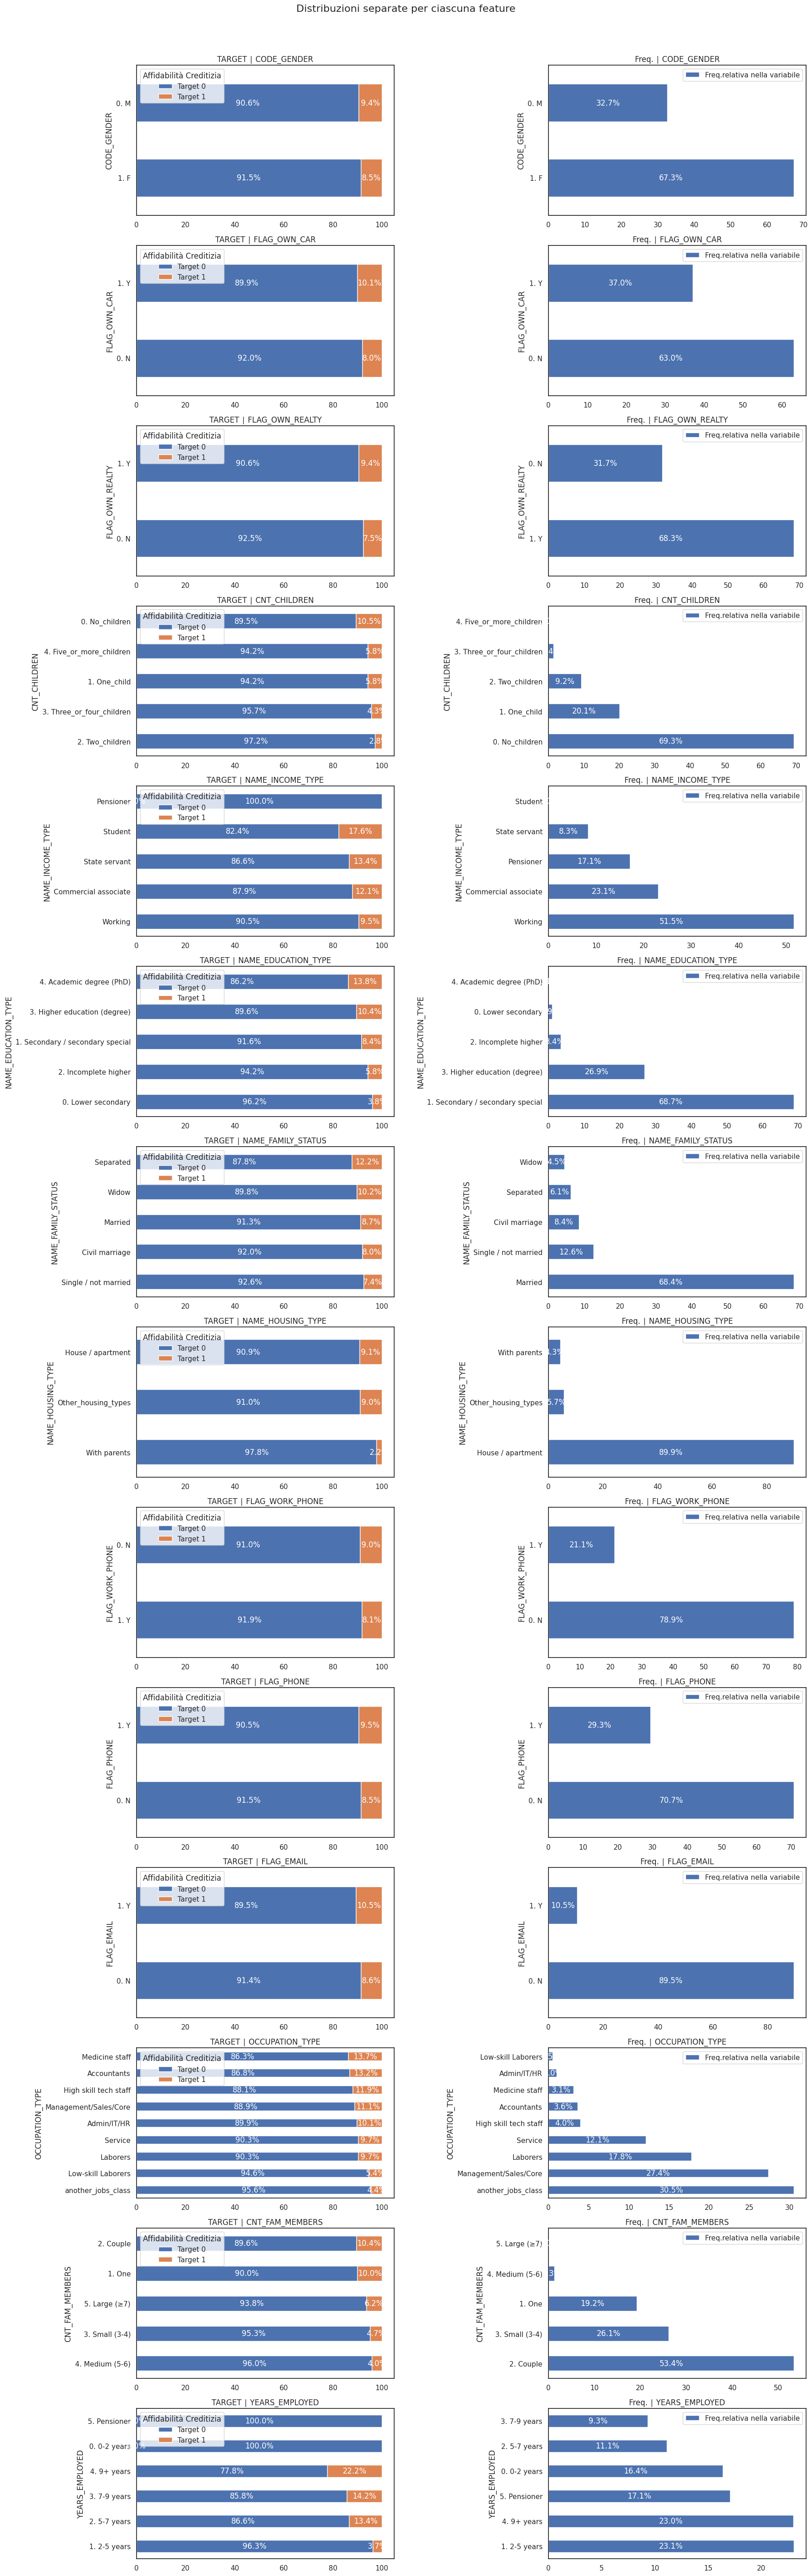

In [ ]:
import math
import matplotlib.pyplot as plt
# lista delle variabili su cui iterare
focus_list = [col for col in df2.columns
              if col not in ["ID","AMT_INCOME_TOTAL","YEARS_BIRTH","TARGET"]]
n_cols = 1
n_rows = math.ceil(len(focus_list)/n_cols)
n_cols_plot = n_cols * 2  # ogni variabile occupa 2 colonne
fig, axes = plt.subplots(n_rows,
                         n_cols_plot,
                         figsize=(n_cols_plot*9, n_rows*4))
axes_flat = axes.flatten()
for i, var in enumerate(focus_list):
    ax1 = axes_flat[2*i]       # primo plot per var
    ax2 = axes_flat[2*i + 1]   # secondo plot per var

    # 1) distribuzione TARGET per categoria di var
    prop = (df2.groupby(var)["TARGET"]
              .value_counts(normalize=True)
              .unstack()
              .sort_values(by=1))*100
    prop.plot(kind="barh", stacked=True, ax=ax1)
    ax1.set_title(f"TARGET ∣ {var}")
    ax1.legend(title="TARGET", loc="upper right")

    # 2) frequenze semplici di var
    (df2[var].value_counts(normalize=True)*100).plot(kind="barh", ax=ax2)
    ax2.set_title(f"Freq. ∣ {var}")
    ax2.legend().remove()

    # aggiunta delle percentuali su ogni barra in ax2
    for j in ax1.patches:
        w = j.get_width(); x = j.get_x() + w/2
        y = j.get_y() + j.get_height()/2
        ax1.text(x, y, f"{w:.1f}%", ha="center", va="center", color="white")
    ax1.legend(title="Affidabilità Creditizia", labels=["Target 0", "Target 1"], loc="upper left")
    for p in ax2.patches:
        w = p.get_width(); x = p.get_x() + w/2
        y = p.get_y() + p.get_height()/2
        ax2.text(x, y, f"{w:.1f}%", ha="center", va="center", color="white")
    ax2.legend(labels=["Freq.relativa nella variabile"], loc="upper right")

for ax in axes_flat[2*len(focus_list):]:
    ax.axis("off")

plt.suptitle("Distribuzioni separate per ciascuna feature", fontsize=16, y=1.01)
plt.tight_layout()
plt.subplots_adjust(hspace=0.2, wspace=0.6)
plt.show()

### 4.1.2 - Box plot Variabili numeriche continue (Condizionate al target)

MEDIA SALARI TARGET 0, 5.205067125753077
MEDIA SALARI TARGET 1: 5.400762507653655


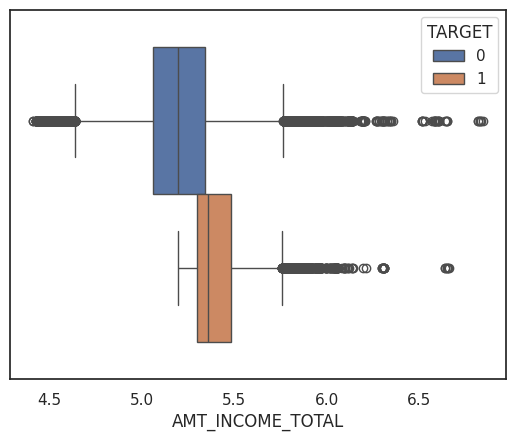

In [ ]:
print("MEDIA SALARI TARGET 0,", df2["AMT_INCOME_TOTAL"][df2["TARGET"]==0].mean())
print("MEDIA SALARI TARGET 1:", df2["AMT_INCOME_TOTAL"][df2["TARGET"]==1].mean())
sns.boxplot(data = df2,x = df2['AMT_INCOME_TOTAL'].dropna(),
            hue='TARGET')
plt.show()

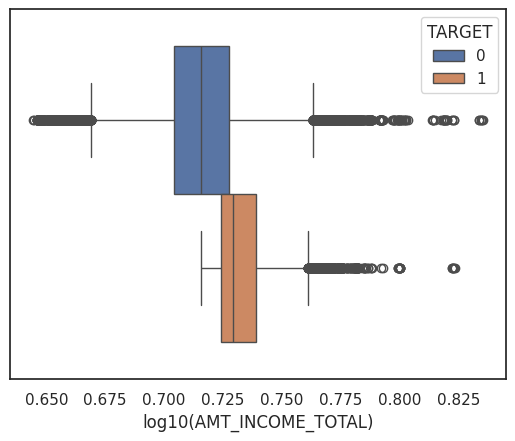

In [ ]:
#applichiamo una trasformazione di potenza logaritimica in base 10 per osservare i risultati
income_total_log10 = df2['AMT_INCOME_TOTAL'].apply(lambda x: np.log10(x))

sns.boxplot(data=df2,
            x=income_total_log10,
            hue='TARGET')
plt.xlabel("log10(AMT_INCOME_TOTAL)")
plt.show()

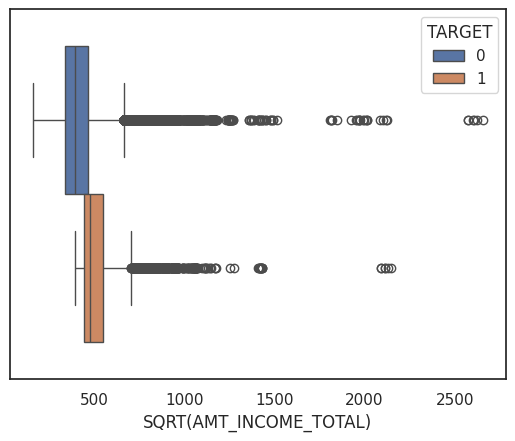

In [ ]:
df['AMT_INCOME_TOTAL_SQRT'] = np.sqrt(df['AMT_INCOME_TOTAL'])
sns.boxplot(data=df, x='AMT_INCOME_TOTAL_SQRT', hue='TARGET')
plt.xlabel("SQRT(AMT_INCOME_TOTAL)")
plt.show()

**Si osservano i seguenti pattern grafici**:

- Non c'è una distinzione netta fra il sesso del cliente e la risposta positiva del target (TARGET = 1).

- La differenza sulla risposta TARGET = 1 è solo marginale (circa l'1%) per i clienti che hanno fornito alla banca il proprio numero di cellulare personale (FLAG_PHONE) e aziendale (FLAG_WORK_PHONE). Tuttavia, per i clienti che possiedono casa (FLAG_OWN_REALTY) e auto di proprietà (FLAG_OWN_CAR), la differenza rispetto al TARGET 1 è del 2% a favore dei possessori.

- Il TARGET = 1 sembra essere più presente nelle classi di famiglie meno numerose (con 0, 1 e 2 bambini). Per le famiglie con un numero maggiore di bambini, le classi sono poco rappresentate, e l'ordine sembra seguire una diminuzione della percentuale di TARGET 1 all'aumentare del numero di bambini a carico. Per la classe con 5 o più bambini, sembra esserci una maggiore risposta al TARGET 1, ma questo potrebbe essere dovuto al fatto che questa classe è sottorappresentata (< 0,5% di tutte le osservazioni della variabile CONT_CHILDREN).

- Il percepire redditi da lavoro dipendente, essere soci commerciali o dipendenti statali è associato a una buona affidabilità creditizia. La classe studentesca è sottorappresentata nel dataset, quindi il 17,6% di affidabilità creditizia potrebbe non essere significativo a causa del numero ridotto di studenti con accesso al credito.

- Si osserva un andamento positivo dell'affidabilità creditizia con l'aumentare del grado di istruzione. La fascia con il massimo di affidabilità creditizia è quella "Higher Education". Anche in questo caso, i PhD sono sottorappresentati, così come le persone con Lower Secondary (istruzione di livello più basso).

- Dal punto di vista dello status civile, le persone sposate (sia con rito religioso che civile) risultano le più affidabili in termini di profilazione creditizia, rappresentando l'81% delle osservazioni per questa variabile. Le persone vedove e separate sono leggermente sottorappresentate, ma anch'esse appartengono a una popolazione con una percentuale di affidabilità creditizia positiva.

- In base al luogo di abitazione, si osserva che circa il 90% delle osservazioni appartengono alla classe "House/Apartment", mentre il restante 10% è distribuito tra chi vive con i parenti o in altre tipologie di abitazione (studi, uffici, cooperative). Il tasso di affidabilità creditizia per queste classi è circa del 10% per le categorie che non comprendono la condivisione della casa con i genitori (solo il 2,2% di TARGET 1 per questa classe).

- Il tipo di occupazione incide sull'affidabilità creditizia: le posizioni lavorative più alte (medici, management, professioni core, high-skill tech) sono associate a una maggiore affidabilità creditizia. La fascia generica di lavoratori mostra comunque una buona affidabilità. I lavoratori low-skill laborers e la classe another_jobs_class (non meglio identificata) mostrano invece una minore affidabilità creditizia.

- Per quanto riguarda la dimensione del nucleo familiare, le persone single, in coppia o con piccole famiglie (max 3-4 persone per nucleo) risultano le più affidabili dal punto di vista creditizio.

- Dal punto di vista anagrafico, le fasce più affidabili sono quelle con un'età lavorativa superiore a 5 anni. Il trend di affidabilità creditizia sembra crescere con l'avanzare della carriera per poi stabilizzarsi al momento del pensionamento, dove il 100% del TARGET = 0 si verifica. Le persone con 0-2 anni di lavoro hanno la più bassa affidabilità creditizia. Dal punto di vista dell'età, l'affidabilità creditizia aumenta a partire da circa 40 anni, raggiunge un picco intorno ai 50 anni, e poi diminuisce gradualmente dopo i 60-65 anni, stabilizzandosi con la pensione.

- Infine, lo stipendio gioca un ruolo cruciale nell'affidabilità creditizia: il TARGET = 1 è più rappresentato nelle fasce con redditi annuali superiori a circa 31.622,77 $, che corrispondono a circa 4,5 unità logaritmiche (in base 10).

## 4.2 - **TEST STATISTICI**

In [ ]:
dicotomical_vars = ["CODE_GENDER", #chi quadro + phi coefficient + test ex. fisher
                    "FLAG_OWN_CAR",
                    "FLAG_OWN_REALTY",
                    "FLAG_WORK_PHONE",
                    "FLAG_PHONE",
                    "FLAG_EMAIL"]

numerical_vars=["AMT_INCOME_TOTAL","YEARS_BIRTH"] # point-biseriale (Pearson), #MUTUAL, #ANOVA, test-t

multi_cat = ["NAME_INCOME_TYPE",        #CHI-QUADRO; MUTUAL
             "NAME_FAMILY_STATUS",
             "NAME_HOUSING_TYPE",
             "OCCUPATION_TYPE",
             "YEARS_EMPLOYED"
             ]

ordinal_vars = ["CNT_CHILDREN",
                "NAME_EDUCATION_TYPE",
                "CNT_FAM_MEMBERS"]

target = df2["TARGET"]

In [ ]:
# Inizializzazione lista risultati
all_results = []

# --- NUMERICHE ---
for var in numerical_vars:
    corr, p_corr = pointbiserialr(df2[var], target)
    g0, g1 = df2[var][target==0], df2[var][target==1]
    t_stat, p_t = ttest_ind(g0, g1)
    u_stat, p_u = mannwhitneyu(g0, g1)
    f_stat, p_f = f_classif(df2[[var]], target)
    mi = mutual_info_classif(df2[[var]], target)[0]

    all_results.append({
        'Variabile': var,
        'Tipo': 'Numerica',
        'Chi2': np.nan,
        'p_chi2': np.nan,
        'Phi/V_Cramer': np.nan,
        'p_fisher': np.nan,
        'Point-Biserial': round(corr,4),
        'p_corr': round(p_corr,4),
        'T_test': round(t_stat,4),
        'p_ttest': round(p_t,4),
        'U_test': round(u_stat,2),
        'p_uman': round(p_u,4),
        'ANOVA_F': round(f_stat[0],2),
        'p_anova': round(p_f[0],4),
        'Mutual_Info': round(mi,4)
    })

# --- DICOTOMICHE ---
for var in dicotomical_vars:
    contingency = pd.crosstab(df2[var], target)
    chi2, p_chi2, _, _ = chi2_contingency(contingency)
    phi, p_fisher = np.nan, np.nan
    if contingency.shape == (2,2):
        n = contingency.sum().sum()
        phi = np.sqrt(chi2 / n)
        _, p_fisher = fisher_exact(contingency)
    mi = mutual_info_classif(LabelEncoder().fit_transform(df2[var]).reshape(-1, 1), target)[0]

    all_results.append({
        'Variabile': var,
        'Tipo': 'Dicotomica',
        'Chi2': round(chi2,2),
        'p_chi2': round(p_chi2,4),
        'Phi/V_Cramer': round(phi,4) if not np.isnan(phi) else None,
        'p_fisher': round(p_fisher,4) if not np.isnan(p_fisher) else None,
        'Point-Biserial': np.nan,
        'p_corr': np.nan,
        'T_test': np.nan,
        'p_ttest': np.nan,
        'U_test': np.nan,
        'p_uman': np.nan,
        'ANOVA_F': np.nan,
        'p_anova': np.nan,
        'Mutual_Info': round(mi,4)})

# --- MULTICATEGORICHE ---
for var in multi_cat:
    contingency = pd.crosstab(df2[var], target)
    chi2, p_chi2, _, _ = chi2_contingency(contingency)
    n = contingency.sum().sum()
    k, r = contingency.shape
    v_cramer = np.sqrt(chi2 / (n * (min(k - 1, r - 1))))
    mi = mutual_info_classif(LabelEncoder().fit_transform(df2[var].astype(str)).reshape(-1, 1), target)[0]

    all_results.append({
        'Variabile': var,
        'Tipo': 'Multi-categorica',
        'Chi2': round(chi2,2),
        'p_chi2': round(p_chi2,4),
        'Phi/V_Cramer': round(v_cramer,4),
        'p_fisher': np.nan,
        'Point-Biserial': np.nan,
        'p_corr': np.nan,
        'T_test': np.nan,
        'p_ttest': np.nan,
        'U_test': np.nan,
        'p_uman': np.nan,
        'ANOVA_F': np.nan,
        'p_anova': np.nan,
        'Mutual_Info': round(mi,4)
    })

# --- ORDINALI ---
for var in ordinal_vars:
    contingency = pd.crosstab(df2[var], target)
    chi2, p_chi2, _, _ = chi2_contingency(contingency)
    n = contingency.sum().sum()
    r, k = contingency.shape
    v_cramer = np.sqrt((chi2 / n) / min(k - 1, r - 1))
    mi = mutual_info_classif(LabelEncoder().fit_transform(df2[var]).reshape(-1, 1), target)[0]

    all_results.append({
        'Variabile': var,
        'Tipo': 'Ordinale',
        'Chi2': round(chi2,2),
        'p_chi2': round(p_chi2,4),
        'Phi/V_Cramer': round(v_cramer,4),
        'p_fisher': np.nan,
        'Point-Biserial': np.nan,
        'p_corr': np.nan,
        'T_test': np.nan,
        'p_ttest': np.nan,
        'U_test': np.nan,
        'p_uman': np.nan,
        'ANOVA_F': np.nan,
        'p_anova': np.nan,
        'Mutual_Info': round(mi,4)
    })
# --- DATAFRAME FINALE ---
df_all = pd.DataFrame(all_results)

In [ ]:
# Ordinamento per p_chi2 (dove disponibile) o Mutual_Info in alternativa
df_all_sorted = df_all.sort_values(by=['Tipo'], na_position='last')
display(df_all_sorted)

Variabile              Tipo      Chi2  p_chi2  Phi/V_Cramer  \
2           CODE_GENDER        Dicotomica     74.83     0.0        0.0149   
3          FLAG_OWN_CAR        Dicotomica    401.12     0.0        0.0344   
4       FLAG_OWN_REALTY        Dicotomica    306.67     0.0        0.0301   
5       FLAG_WORK_PHONE        Dicotomica     55.56     0.0        0.0128   
6            FLAG_PHONE        Dicotomica     81.80     0.0        0.0155   
7            FLAG_EMAIL        Dicotomica    153.73     0.0        0.0213   
8      NAME_INCOME_TYPE  Multi-categorica   7458.21     0.0        0.1485   
9    NAME_FAMILY_STATUS  Multi-categorica    459.49     0.0        0.0368   
10    NAME_HOUSING_TYPE  Multi-categorica    833.47     0.0        0.0496   
11      OCCUPATION_TYPE  Multi-categorica   3974.14     0.0        0.1084   
12       YEARS_EMPLOYED  Multi-categorica  33238.49     0.0        0.3134   
0      AMT_INCOME_TOTAL          Numerica       NaN     NaN           NaN   
1           YEARS_BIRTH          Numerica       NaN     NaN           NaN   
13         CNT_CHILDREN          Ordinale   3152.38     0.0        0.0965   
14  NAME_EDUCATION_TYPE          Ordinale    567.04     0.0        0.0409   
15      CNT_FAM_MEMBERS          Ordinale   2669.41     0.0        0.0888   

    p_fisher  Point-Biserial  p_corr    T_test  p_ttest        U_test  p_uman  \
2        0.0             NaN     NaN       NaN      NaN           NaN     NaN   
3        0.0             NaN     NaN       NaN      NaN           NaN     NaN   
4        0.0             NaN     NaN       NaN      NaN           NaN     NaN   
5        0.0             NaN     NaN       NaN      NaN           NaN     NaN   
6        0.0             NaN     NaN       NaN      NaN           NaN     NaN   
7        0.0             NaN     NaN       NaN      NaN           NaN     NaN   
8        NaN             NaN     NaN       NaN      NaN           NaN     NaN   
9        NaN             NaN     NaN       NaN      NaN           NaN     NaN   
10       NaN             NaN     NaN       NaN      NaN           NaN     NaN   
11       NaN             NaN     NaN       NaN      NaN           NaN     NaN   
12       NaN             NaN     NaN       NaN      NaN           NaN     NaN   
0        NaN          0.2683     0.0 -162.0174      0.0  1.902469e+09     0.0   
1        NaN          0.1840     0.0 -108.8935      0.0  2.710784e+09     0.0   
13       NaN             NaN     NaN       NaN      NaN           NaN     NaN   
14       NaN             NaN     NaN       NaN      NaN           NaN     NaN   
15       NaN             NaN     NaN       NaN      NaN           NaN     NaN   

     ANOVA_F  p_anova  Mutual_Info  
2        NaN      NaN       0.0598  
3        NaN      NaN       0.0258  
4        NaN      NaN       0.0596  
5        NaN      NaN       0.0081  
6        NaN      NaN       0.0166  
7        NaN      NaN       0.0018  
8        NaN      NaN       0.0559  
9        NaN      NaN       0.0339  
10       NaN      NaN       0.0036  
11       NaN      NaN       0.0223  
12       NaN      NaN       0.0704  
0   26249.64      0.0       0.0652  
1   11857.80      0.0       0.0729  
13       NaN      NaN       0.0109  
14       NaN      NaN       0.0340  
15       NaN      NaN       0.0292

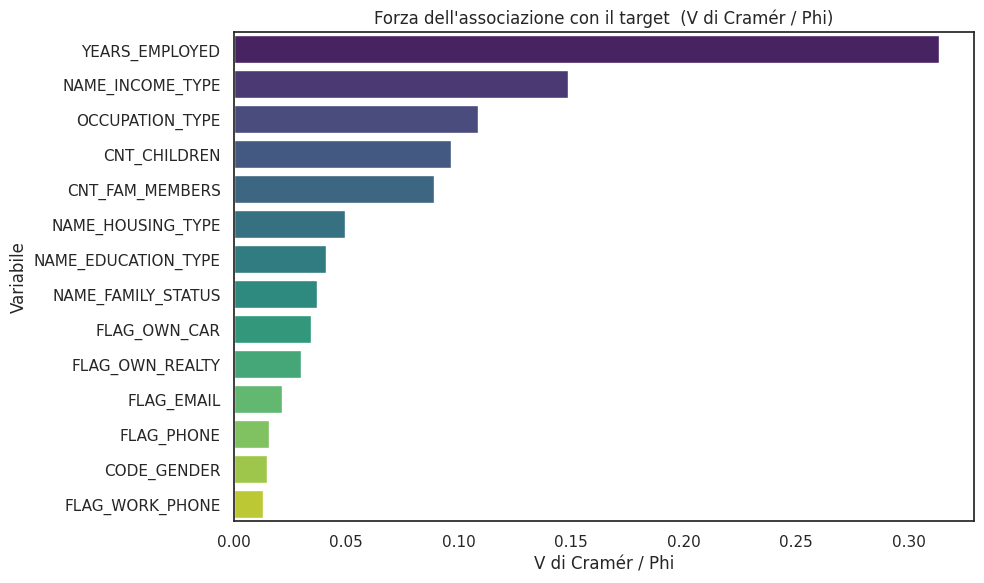

In [ ]:
warnings.filterwarnings("ignore")
df_all["V di Cramér / Phi"] = pd.to_numeric(df_all["Phi/V_Cramer"], errors='coerce')
df_plot = df_all.dropna(subset=["Phi/V_Cramer"])
df_plot = df_plot.sort_values(by="Phi/V_Cramer", ascending=False)
plt.figure(figsize=(10, 6))
sns.barplot(
    x="Phi/V_Cramer",
    y="Variabile",
    data=df_plot,
    palette="viridis")
plt.title("Forza dell'associazione con il target  (V di Cramér / Phi)")
plt.xlabel("V di Cramér / Phi")
plt.ylabel("Variabile")
plt.tight_layout()
plt.show()

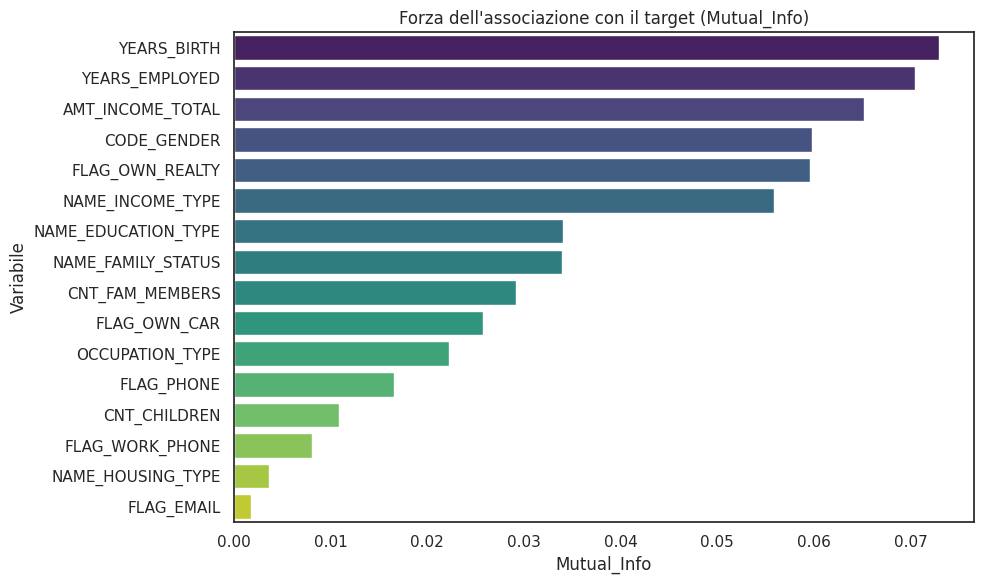

In [ ]:
warnings.filterwarnings("ignore")
df_all["Mutual_Info"] = pd.to_numeric(df_all["Mutual_Info"], errors='coerce')
df_plot = df_all.dropna(subset=["Mutual_Info"])
df_plot = df_plot.sort_values(by="Mutual_Info", ascending=False)
plt.figure(figsize=(10, 6))
sns.barplot(
    x="Mutual_Info",
    y="Variabile",
    data=df_plot,
    palette="viridis")
plt.title("Forza dell'associazione con il target (Mutual_Info)")
plt.xlabel("Mutual_Info")
plt.ylabel("Variabile")
plt.tight_layout()
plt.show()

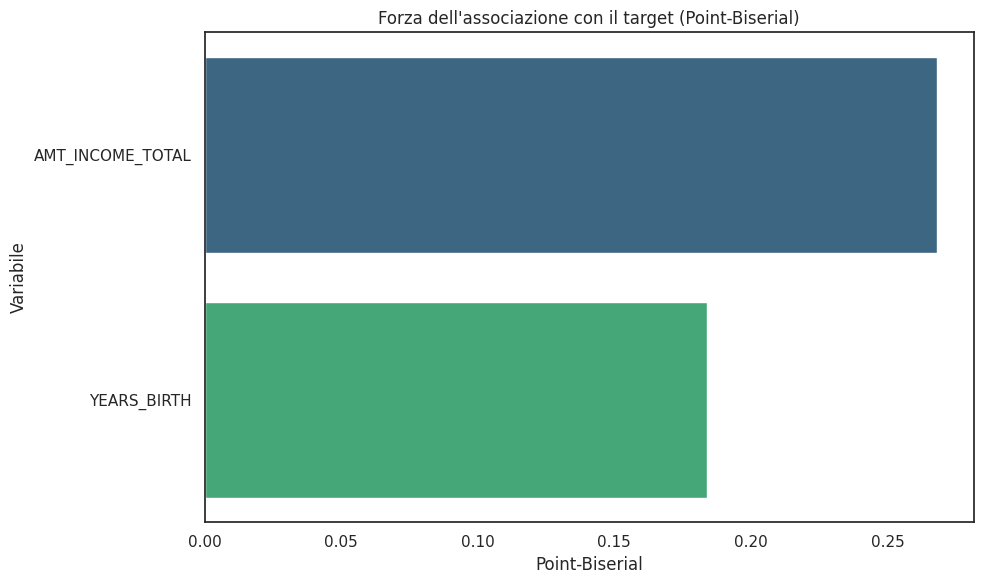

In [ ]:
warnings.filterwarnings("ignore")
df_all["Point-Biserial"] = pd.to_numeric(df_all["Point-Biserial"], errors='coerce')
df_plot = df_all.dropna(subset=["Point-Biserial"])
df_plot = df_plot.sort_values(by="Point-Biserial", ascending=False)
plt.figure(figsize=(10, 6))
sns.barplot(
    x="Point-Biserial",
    y="Variabile",
    data=df_plot,
    palette="viridis")
plt.title("Forza dell'associazione con il target (Point-Biserial)")
plt.xlabel("Point-Biserial")
plt.ylabel("Variabile")
plt.tight_layout()
plt.show()

### 4.2.1 **Commenti variabili Categoriche vs TARGET**

**Variabili dicotomiche**:
- Tutte le variabili sono significativamente associate al target (p-value = 0), ma:

- I valori di Phi sono molto bassi (Φ < 0.04) → associazione debole.

- Anche la Mutual Information è quasi nulla (≈ 0.0001–0.0006) → scarso potere informativo.

--> Conclusione: Significative per via dell'elevata numerosità, ma poco rilevanti a livello predittivo. <br>

**Variabili multiclasse**
- NAME_INCOME_TYPE e OCCUPATION_TYPE mostrano:
- - V di Cramér > 0.1 → associazione moderata
- - MI non altissima, ma superiore alle altre (≈ 0.018 e 0.006)
- - Le altre variabili (FAMILY_STATUS, HOUSING_TYPE) hanno V e MI basse, quindi meno impattanti.

--> Conclusione: NAME_INCOME_TYPE e OCCUPATION_TYPE sono le categoriche più informative.

Le altre, sebbene significative, hanno bassa rilevanza pratica.

### 4.2.3 **Commenti variabili Ordinali vs TARGET**

- **Variabili ordinali**:
Tutte le variabili sono significativamente associate al target (p < 0.001).

I valori di V di Cramér sono:
- CNT_CHILDREN → 0.0965 → associazione moderata
- CNT_FAM_MEMBERS → 0.0888 → moderata-bassa
- NAME_EDUCATION_TYPE → 0.0409 → associazione debole

- Tuttavia, la Mutual Information è bassa per tutte (< 0.006), indicando bassa capacità predittiva individuale.
<br>

--->  Conclusione:
Le variabili CNT_CHILDREN e CNT_FAM_MEMBERS mostrano un’associazione moderata con il target, più promettenti da tenere nel modello.NAME_EDUCATION_TYPE è statisticamente significativa ma poco informativa a livello predittivo.

### 4.2.1 **Commenti su variabili numeriche vs TARGET**

N.B.= *Notare che la variabile AMT_INCOME_TOTAL è stata preprocessata  riscalando la variabile con il suo logaritmo (base 10) prima di applicare i vari test statistici*


- Correlazione Point-Biserial: Entrambe le variabili mostrano una correlazione significativa con il target, con AMT_INCOME_TOTAL (0.2683) più forte rispetto a YEARS_BIRTH (0.184).

- T-test: Entrambe le variabili hanno t-test molto significativi con p-value = 0.0.

- Test U (Mann-Whitney): Entrambe le variabili mostrano una differenza altamente significativa (p-value = 0.0).

- ANOVA: Anche qui, entrambe le variabili sono significativamente correlate al target, con AMT_INCOME_TOTAL più influente (F = 26249.64 vs. F = 11857.80 per YEARS_BIRTH).

- Mutual Information: Relazioni modeste, con YEARS_BIRTH (0.0722) leggermente più informativa rispetto a AMT_INCOME_TOTAL (0.0652).

In sintesi, AMT_INCOME_TOTAL ha una relazione più forte con il target rispetto a YEARS_BIRTH, ma entrambe sono statisticamente significative e correlate positivamente al TARGET di affidabilità creditizia del cliente.

#### 4.2.1.1 - Approfondimento con Regressione Logistica su **AMT_INCOME_TOTAL**

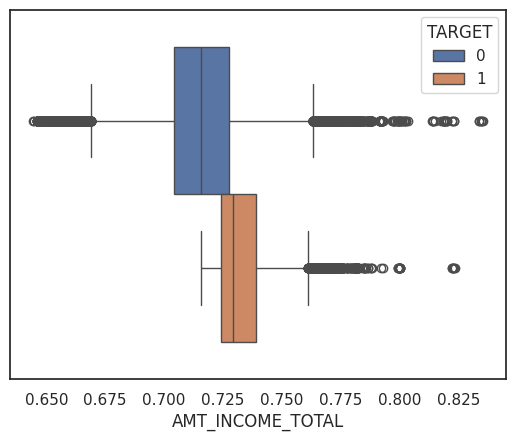


               precision    recall  f1-score   support

           0       0.96      0.69      0.81     92611
           1       0.19      0.74      0.30      8917

    accuracy                           0.70    101528
   macro avg       0.58      0.71      0.55    101528
weighted avg       0.90      0.70      0.76    101528


 AUC: 0.7953022730939336 

Optimization terminated successfully.
         Current function value: 0.260713
         Iterations 7
                           Logit Regression Results                           
Dep. Variable:                 TARGET   No. Observations:               236898
Model:                          Logit   Df Residuals:                   236896
Method:                           MLE   Df Model:                            1
Date:                Sun, 11 May 2025   Pseudo R-squ.:                  0.1236
Time:                        19:49:52   Log-Likelihood:                -61762.
converged:                       True   LL-Null:                   

In [ ]:
from imblearn.over_sampling import SMOTE
from sklearn.metrics import classification_report, roc_auc_score
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
import statsmodels.api as sm
#applichiamo una trasformazione di potenza logaritimica in base 10 per osservare i risultati
income_total_log10 = df2['AMT_INCOME_TOTAL'].apply(lambda x: np.log10(x))

sns.boxplot(data=df2,
            x=income_total_log10,
            hue='TARGET')
plt.show()
# X deve essere un DataFrame/array 2D — se X è una Series, va reshaped
X = income_total_log10.values.reshape(-1, 1)
y = target

# Split prima, poi bilanciamento SOLO sul training set!
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=RANDOM_SEED, stratify=y)

# Applica SMOTE solo sul training set
smote = SMOTE(random_state=RANDOM_SEED)
X_train_bal, y_train_bal = smote.fit_resample(X_train, y_train)

# Addestra il modello sui dati bilanciati
model = LogisticRegression()
model.fit(X_train_bal, y_train_bal)

# Predici sul test set originale (non bilanciato!)
y_pred = model.predict(X_test)
y_proba = model.predict_proba(X_test)[:, 1]

# Valutazione
print("\n",classification_report(y_test, y_pred))
print("\n","AUC:", roc_auc_score(y_test, y_proba),"\n")

#LOGIT DI STATMODELS
X_train_const = sm.add_constant(X_train)  # Aggiunge l'intercetta
logit_model = sm.Logit(y_train, X_train_const)
result = logit_model.fit()
print(result.summary())


print("\n\n\ESTRAZIONE COEFFICIENTI DAL MODELLO")
print("con logit di stat model")
# Estrarre il coefficiente di “x1”
coef_x1 = result.params['x1']
print("Coefficiente x1 (scala logaritmica):", coef_x1)
odds_ratio = np.exp(coef_x1)
print("Odds ratio: (scala logaritmica)", odds_ratio)
print("con Logistic Regression di sklearn")
INCOME_COEF = model.coef_[0][0]
print("Coefficiente AMT_INCOM_TOTAL: (scala logaritmica)", INCOME_COEF)

Prendendo in considerazione i risultati del modello **LOGIT** di **StatsModels**, possiamo osservare che ogni aumento logaritmico della variabile **AMT\_INCOME\_TOTAL** (ovvero, ogni volta che il reddito moltiplica per 10) comporta un aumento della probabilità (odds-ratio) di **TARGET = 1** di 59 volte.

Se invece vogliamo sapere cosa succede quando il reddito raddoppia anziché decuplicare (aumentare di unità logaritmo il la variabile indipendente), dobbiamo considerare il logaritmo in base 10 del raddoppio del reddito. In termini di unità logaritmiche, il raddoppio corrisponde a un incremento di circa 0,3010 (poiché log(2) ≈ 0,3010). A questo punto, dovremmo moltiplicare tale incremento per il coefficiente **β** trovato nel modello **logit** e poi elevare tutto alla base esponenziale, per ottenere l'effetto dell'aumento del reddito sul **TARGET**.

Matematicamente, ciò si esprime come:

$$
P(TARGET = 1 \mid \text{reddito raddoppiato}) = e^{\beta \times \log(2)}
$$

Dove **β** è il coefficiente associato alla variabile **AMT\_INCOME\_TOTAL** nel modello **logit** e **log(2)** è l'incremento logaritmico per il raddoppio del reddito.


In [ ]:
raddoppio=np.log10(2)
raddoppio_logit=coef_x1*raddoppio
print("coefficiente x1 (beta di regressione) al raddoppio dello stipendio:",(raddoppio_logit).round(2))

coefficiente x1 (beta di regressione) al raddoppio dello stipendio: 17.95


la probabilità di idoneità al rilascio della carta di credito aumenta di 17.95 volte rispetto alla non ideoneità basta se consideriamo un raddopio di stipendio:

#### 4.2.1.2 - Approfondimento con Regressione Logistica su **YEARS_BIRTH**

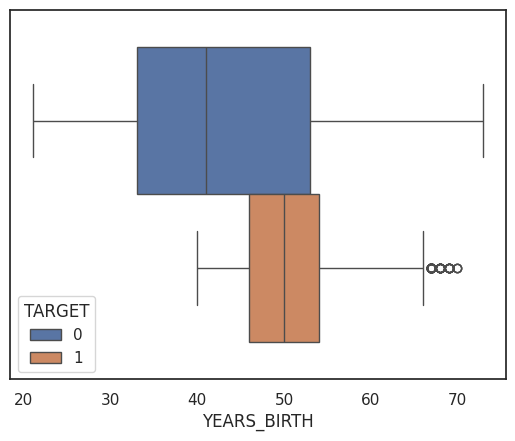

              precision    recall  f1-score   support

           0       0.95      0.64      0.77     92611
           1       0.15      0.65      0.24      8917

    accuracy                           0.65    101528
   macro avg       0.55      0.65      0.51    101528
weighted avg       0.88      0.65      0.72    101528

AUC: 0.7031937277290717
Optimization terminated successfully.
         Current function value: 0.280346
         Iterations 7
                           Logit Regression Results                           
Dep. Variable:                 TARGET   No. Observations:               236898
Model:                          Logit   Df Residuals:                   236896
Method:                           MLE   Df Model:                            1
Date:                Sun, 11 May 2025   Pseudo R-squ.:                 0.05757
Time:                        19:49:57   Log-Likelihood:                -66413.
converged:                       True   LL-Null:                       -7

In [ ]:
sns.boxplot(data=df2,
            x="YEARS_BIRTH",
            hue='TARGET')
plt.show()
# X deve essere un DataFrame/array 2D — se X è una Series, va reshaped
X = df2["YEARS_BIRTH"].values.reshape(-1, 1)
y = target

# Split prima, poi bilanciamento SOLO sul training set!
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=RANDOM_SEED, stratify=y)

# Applica SMOTE solo sul training set
smote = SMOTE(random_state=RANDOM_SEED)
X_train_bal, y_train_bal = smote.fit_resample(X_train, y_train)

# Addestra il modello sui dati bilanciati
model = LogisticRegression()
model.fit(X_train_bal, y_train_bal)

# Predici sul test set originale (non bilanciato!)
y_pred = model.predict(X_test)
y_proba = model.predict_proba(X_test)[:, 1]

# Valutazione
print(classification_report(y_test, y_pred))
print("AUC:", roc_auc_score(y_test, y_proba))

import statsmodels.api as sm
X_train_const = sm.add_constant(X_train)  # Aggiunge l'intercetta
logit_model = sm.Logit(y_train, X_train_const)
result = logit_model.fit()
print(result.summary())

In [ ]:
print("ESTRAZIONE COEFFICIENTI DAL MODELLO")
print("con logit di stat model")
# Estrarre il coefficiente di “x1”
coef_x1 = result.params['x1']
print("Coefficiente x1:", coef_x1)
odds_ratio = np.exp(coef_x1)
print("Odds ratio:", odds_ratio)
print("con Logistic Regression di sklearn")
coef_years_birth = model.coef_[0][0]
print("Coefficiente YEARS_BIRTH:", coef_years_birth)

ESTRAZIONE COEFFICIENTI DAL MODELLO
con logit di stat model
Coefficiente x1: 0.05840304837474949
Odds ratio: 1.0601421982028583
con Logistic Regression di sklearn
Coefficiente YEARS_BIRTH: 0.08811224520948491


in altre parole ogni aumento di anno d'eta, aumenta del 6% la possibilità di essere un cliente ideoneo al rilascio di carta di credito. (basandoci sui risultati di logit della libreria statmodels)

## 4.2 **CONSIDERAZIONE FINALE (CORRELAZIONI FEATURES E TARGET)**

Nel complesso, le analisi statistiche indicano che diverse variabili presentano associazioni significative con il target, anche se la forza di tali relazioni è generalmente debole o moderata. Le variabili numeriche mostrano correlazioni significative ma contenute (es. AMT_INCOME_TOTAL e YEARS_BIRTH), confermate dai test t, ANOVA e Mann-Whitney. Tra le variabili categoriche, quelle multiclasse come NAME_INCOME_TYPE e OCCUPATION_TYPE evidenziano le associazioni più forti (V di Cramér > 0.1), suggerendo un potenziale contributo informativo al modello predittivo. Le variabili dicotomiche e ordinali, pur significative a livello statistico, mostrano effetti deboli (Phi e V < 0.1) e mutual information molto bassa, segnalando una bassa capacità discriminante individuale rispetto al target. In sintesi, il target è influenzato da più fattori con effetti contenuti, e solo alcune variabili, in particolare quelle legate al reddito, all'età e all'occupazione, sembrano offrire un contributo più rilevante in fase di modellizzazione.

# 5 . **MODELLISTICA E ALGORITMI**

Accorpiamo variabili simili su cui separatamente effettueremo dei pre-processing dedicati; nella fattispecie effettuerò label encoding per le variabili dicotomiche 0/1, ordinal encoding per le variabili ordinali ed, infine applicherò OneHotEncoding per le variabili multiclasse discrete:

In [ ]:
dicotomical_vars = ["CODE_GENDER", # <- variabili dicotomiche
                    "FLAG_OWN_CAR",
                    "FLAG_OWN_REALTY",
                    "FLAG_WORK_PHONE",
                    "FLAG_PHONE",
                    "FLAG_EMAIL"]

numerical_vars=["AMT_INCOME_TOTAL","YEARS_BIRTH"]  # <- variabili numeriche

multi_cat = ["NAME_INCOME_TYPE",    # <- variabili cardinali
             "NAME_FAMILY_STATUS",
             "NAME_HOUSING_TYPE",
             "OCCUPATION_TYPE",
             "YEARS_EMPLOYED"
             ]

ordinal_vars = ["CNT_CHILDREN",    # <- variabili ordinali
                "NAME_EDUCATION_TYPE",
                "CNT_FAM_MEMBERS"]

target = df2["TARGET"]

Verifica bilanciamento della variabile di risposta:

In [ ]:
df2["TARGET"].value_counts(normalize=True)

TARGET
0    0.912176
1    0.087824
Name: proportion, dtype: float64

**N.B.** = il target è sbilanciato a favore della classe 0

## 5.1 - **Modelli di regressione Logistica (LG)**

### 5.1.1 - **Modello LG_1 (BASELINE)**

Il primo modello LG_1 consiste in un modello di regressione logistica base, che serve da benchmark sui cui effettuare le successive migliorie (features selection, discesa stocastica del gradiente,etc..)

In [ ]:
start_time = time.time()
dflog = df2.copy()
X = dflog.drop('TARGET',axis=1)
y = dflog['TARGET']
X_train,X_test,y_train,y_test = train_test_split(X,y,
                                                 test_size=0.3,
                                                 random_state=0,
                                                 stratify=y)
dicotomical_vars = ["CODE_GENDER",
                    "FLAG_OWN_CAR",
                    "FLAG_OWN_REALTY",
                    "FLAG_WORK_PHONE", "FLAG_PHONE", "FLAG_EMAIL"]

numerical_vars = ["AMT_INCOME_TOTAL", "YEARS_BIRTH"]
multi_cat = ["NAME_INCOME_TYPE", "NAME_FAMILY_STATUS","NAME_HOUSING_TYPE", "OCCUPATION_TYPE", "YEARS_EMPLOYED"]
ordinal_vars   = ["CNT_CHILDREN", "NAME_EDUCATION_TYPE", "CNT_FAM_MEMBERS"]

#Pipelines specifiche
pipe_dicho = make_pipeline(SimpleImputer(strategy='most_frequent'),
                           OrdinalEncoder())
pipe_num = make_pipeline(SimpleImputer(strategy='mean'),
                         StandardScaler())
pipe_multi = make_pipeline(SimpleImputer(strategy='most_frequent'),
                           OneHotEncoder(sparse_output=False))

# Corretto ordine per le variabili ordinali (includendo i prefissi esatti)
children_order = ["0. No_children",
                  "1. One_child",
                  "2. Two_children",
                  "3. Three_or_four_children",
                  "4. Five_or_more_children"]
edu_order = ["0. Lower secondary",
             "1. Secondary / secondary special",
             "2. Incomplete higher",
             "3. Higher education (degree)",
             "4. Academic degree (PhD)"]
fammem_order = ["1. One",
                "2. Couple",
                "3. Small (3-4)",
                "4. Medium (5-6)",
                "5. Large (≥7)"]

pipe_ord = make_pipeline(SimpleImputer(strategy='most_frequent'),
                         OrdinalEncoder(categories=[children_order, edu_order, fammem_order]))

#ColumnTransformer
preproc = ColumnTransformer([
    ('dich', pipe_dicho,   dicotomical_vars),
     ('num',  pipe_num,     numerical_vars),
      ('mult', pipe_multi,   multi_cat),
       ('ord',  pipe_ord,     ordinal_vars),])

# 4. Pipeline finale con SMOTE (solo SMOTE)
model = imb_make_pipeline(
    preproc,
    SMOTE(sampling_strategy=0.3, random_state=RANDOM_SEED),
    LogisticRegression(max_iter=1000))

# 5. Addestramento
model.fit(X_train, y_train)
end_time = time.time()
execution_time = end_time - start_time
print(f"Tempo di esecuzione: {execution_time} secondi")

Tempo di esecuzione: 8.392499208450317 secondi


              precision    recall  f1-score   support

           0       0.97      0.93      0.95     92611
           1       0.51      0.73      0.60      8917

    accuracy                           0.92    101528
   macro avg       0.74      0.83      0.78    101528
weighted avg       0.93      0.92      0.92    101528



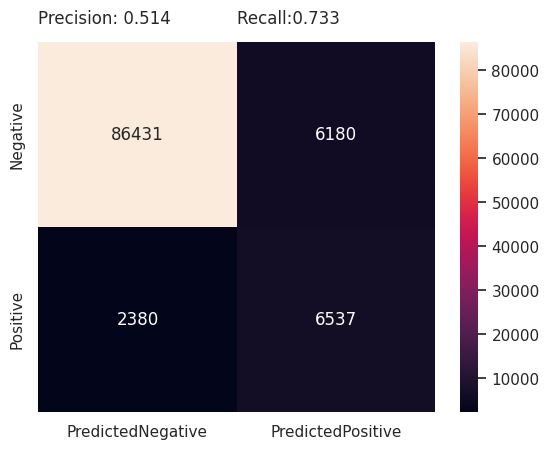

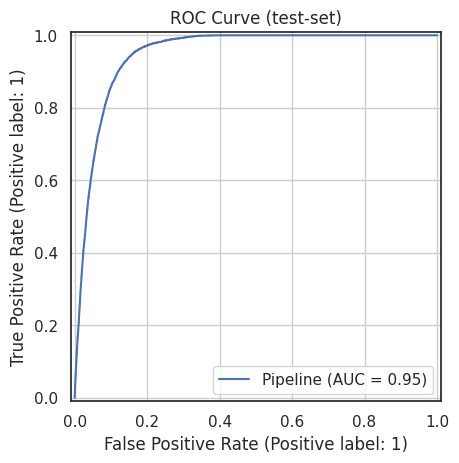

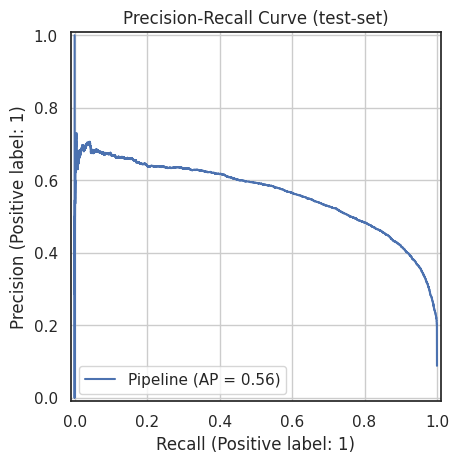

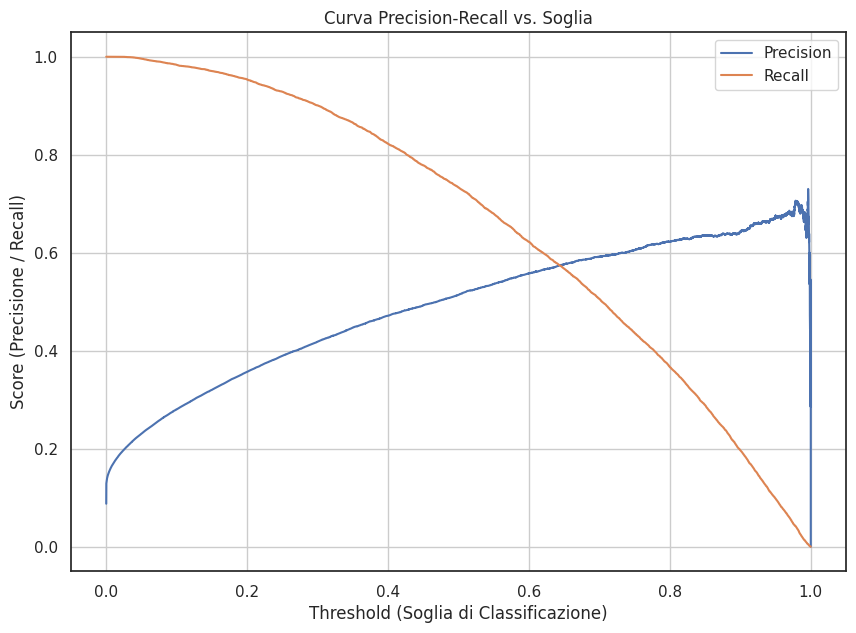

In [ ]:
#metriche di classificazione
print(classification_report(y_test,
                            model.predict(X_test)))
plot_confusion_matrix(y_test,
                      model.predict(X_test),
                      labels=["Negative","Positive"],
                      show_precision_recall=True)

RocCurveDisplay.from_estimator(model, X_test, y_test)
plt.title('ROC Curve (test-set)')
plt.grid()
plt.show()

PrecisionRecallDisplay.from_estimator(model, X_test, y_test)
plt.title('Precision-Recall Curve (test-set)')
plt.grid()
plt.show()
PrecisionRecallCurve_vs_Threshold(model,X_test, y_test)


- Implicazioni di business
- Troppi FP (6 167 falsi affidabili) → rischio di perdite se si credito a clienti non affidabili.

- FN (2 386 falsi non-affidabili) → potenziali ricavi mancati perché rifiuti clienti validi.

A seconda di quanto costi un credito non ripagato vs. un’opportunità persa, si potrebbe: abbassare la soglia decisionale per ridurre gli FN (aumentare Recall₁), sacrificando un po’ di precision. Aumentare la soglia per ridurre FP (migliorare Precision₁), sacrificando recall. In altre parole se abbasso la soglia aumento il numero di clienti ideonei, e rendendo il modello più sensibile alle classificazioni di tipo 1, mentre se alzo la soglia diventa più selettivo sulla barriera di entrata dei clienti, volendo dire che limito i clienti che sembrano ideonei ma che alla fine non mi ripagano il debito. <br><br>Analizziamo di seguito come variano le metriche di classificazione del modello LG_1 al variare della threshold:

In [ ]:
for threshold in np.arange(0,1,0.1):
    y_pred_test = (model.predict_proba(X_test)[:,1] > threshold).astype(int)
    print(f"Threshold: {threshold}")
    print(classification_report(y_test, y_pred_test))

Threshold: 0.0
              precision    recall  f1-score   support

           0       0.00      0.00      0.00     92611
           1       0.09      1.00      0.16      8917

    accuracy                           0.09    101528
   macro avg       0.04      0.50      0.08    101528
weighted avg       0.01      0.09      0.01    101528



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Threshold: 0.1
              precision    recall  f1-score   support

           0       1.00      0.76      0.86     92611
           1       0.28      0.98      0.44      8917

    accuracy                           0.78    101528
   macro avg       0.64      0.87      0.65    101528
weighted avg       0.93      0.78      0.82    101528

Threshold: 0.2
              precision    recall  f1-score   support

           0       0.99      0.83      0.91     92611
           1       0.36      0.95      0.52      8917

    accuracy                           0.85    101528
   macro avg       0.68      0.89      0.71    101528
weighted avg       0.94      0.85      0.87    101528

Threshold: 0.30000000000000004
              precision    recall  f1-score   support

           0       0.99      0.88      0.93     92611
           1       0.42      0.90      0.57      8917

    accuracy                           0.88    101528
   macro avg       0.70      0.89      0.75    101528
weighted avg 

Analizzando le metriche si evince che:

- **Se si vuole massimizzare il recupero dei clienti affidabili (FN bassi): impostare la soglia della classe 1 pari a 0.2 o 0.3**. --> Alta recall, ma precision ridotta. --> Rischi di concedere credito a clienti non affidabili.

- **Se si vuole ridurre al minimo i falsi positivi (FP): Soglia 0.7 o superiore**. --> Alta precisione, ma recall più bassa. --> Buono se si preferisce perdere qualche cliente affidabile piuttosto che concedere credito a molti clienti più rischiosi

### 5.1.2 - **MODELLO LG2 light (modello LG1 alleggerito da features non rilevanti)**

Il prossimo passo sarà quello di individuare le **feature più rilevanti** del modello **LG\_1**. Se dovessimo identificare variabili poco significative ai fini della predizione del target, queste potrebbero essere eliminate in fase di addestramento. Questo permetterebbe di ridurre i tempi di training e di ottenere una pipeline di machine learning più efficiente.


- **Estrazione importace features in modello LG1**

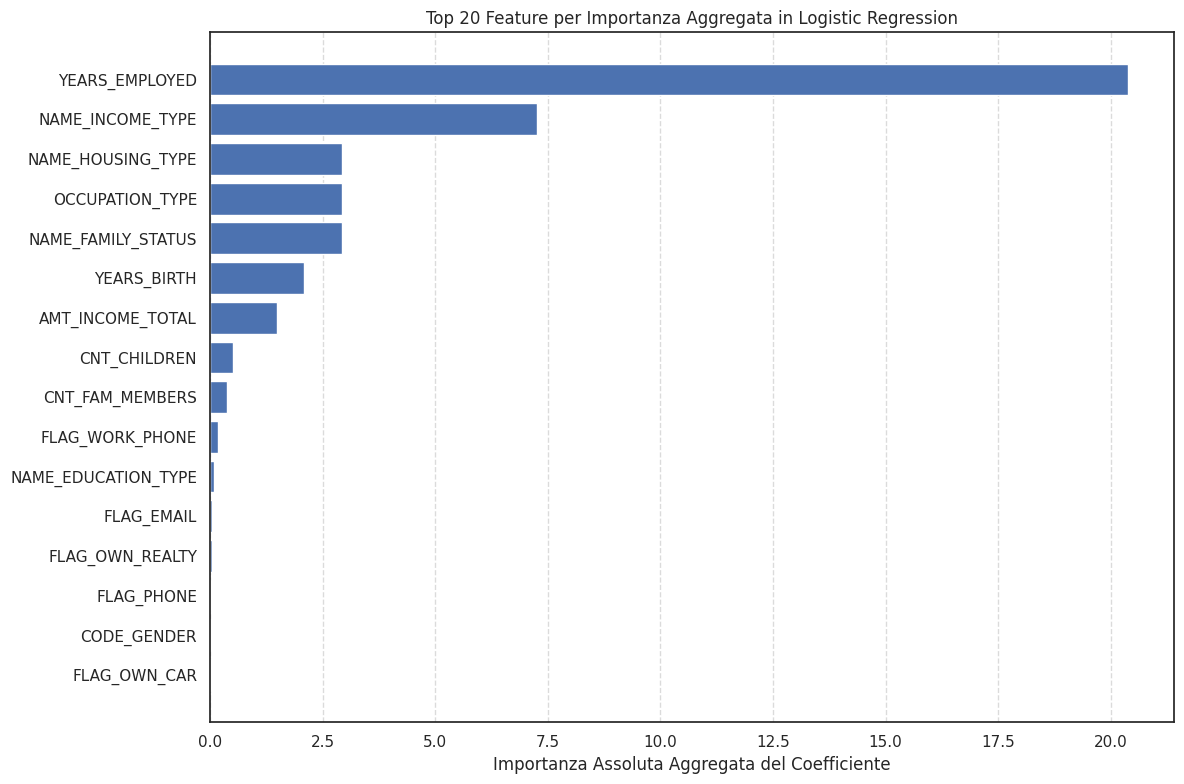

Feature meno rilevanti (aggregato < 0.05):
           Feature  Abs_Coefficient
4       FLAG_EMAIL         0.042875
6  FLAG_OWN_REALTY         0.041695
7       FLAG_PHONE         0.025834
3      CODE_GENDER         0.021230
5     FLAG_OWN_CAR         0.010087


In [ ]:
feature_names, feature_groups = get_feature_names_from_column_transformer(preproc)
logreg = model.named_steps['logisticregression']
coefficients = logreg.coef_[0]
feature_importance = pd.DataFrame({'Feature': feature_names,
                                   'Coefficient': coefficients,
                                   'Abs_Coefficient': np.abs(coefficients)})

aggregated_importance = (feature_importance
                         .groupby(feature_importance['Feature'].map(lambda x: next((k for k, v in feature_groups.items() if x in v), x)))
                         .agg({'Abs_Coefficient': 'sum'})
                         .reset_index())
aggregated_importance = aggregated_importance.sort_values(by='Abs_Coefficient', ascending=False)
# Visualizzazione delle top 20 feature più rilevanti (aggregata)
plt.figure(figsize=(12, 8))
plt.barh(aggregated_importance['Feature'].head(20), aggregated_importance['Abs_Coefficient'].head(20))
plt.xlabel('Importanza Assoluta Aggregata del Coefficiente')
plt.title('Top 20 Feature per Importanza Aggregata in Logistic Regression')
plt.gca().invert_yaxis()
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()
# Output delle feature meno rilevanti (coefficiente aggregato < 0.05)
insignificant_features_agg = aggregated_importance[aggregated_importance['Abs_Coefficient'] < 0.05]
print("Feature meno rilevanti (aggregato < 0.05):")
print(insignificant_features_agg)

In accordo con le analisi statistiche di correlazione al target della sezione 4.2.1, notiamo che le features più rilevanti per la costruzione del modello sono:
- YEARS_EMPLOYED;
- NAME_INCOME_TYPE;
- NAME_HOUSING_TYPE:
- OCCUPATION_TYPE;
- NAME_FAMILY_STATUS;
- YEARS_BIRTH;
- AMT_INCOME_TOTAL

Potremmo a questo punto **riconfigurare un nuovo modello LG2 light con meno features** (includendo le più rilevanti ai fini descrittivi del target),al fine di renderlo più snello e più performante:

- **MODELLO LG2 light**

In [ ]:
start_time = time.time()
dflog = df2.copy()
# Selezione del dataset con le feature più importanti
selected_features = [
    'YEARS_EMPLOYED',
    'NAME_INCOME_TYPE',
    'NAME_HOUSING_TYPE',
    'OCCUPATION_TYPE',
    'NAME_FAMILY_STATUS',
    'YEARS_BIRTH',
    'AMT_INCOME_TOTAL',
    'TARGET']
dflog = dflog[selected_features]

X = dflog.drop('TARGET', axis=1)
y = dflog['TARGET']
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size=0.3,
                                                    random_state=RANDOM_SEED,
                                                    stratify=y)
numerical_vars = ['AMT_INCOME_TOTAL', 'YEARS_BIRTH']
multi_cat_vars = ['YEARS_EMPLOYED','NAME_INCOME_TYPE','NAME_HOUSING_TYPE',
                  'OCCUPATION_TYPE','NAME_FAMILY_STATUS']

pipe_num = make_pipeline(SimpleImputer(strategy='mean'),
                         StandardScaler())

pipe_multi = make_pipeline(SimpleImputer(strategy='most_frequent'),
                           OneHotEncoder(sparse_output=False))

preproc = ColumnTransformer([('num',  pipe_num,   numerical_vars),
 ('mult', pipe_multi, multi_cat_vars)])

model = imb_make_pipeline(preproc,
                          SMOTE(sampling_strategy=0.3, random_state=RANDOM_SEED),
                          LogisticRegression(max_iter=1000))

model.fit(X_train, y_train)
y_pred = model.predict(X_test)
end_time = time.time()
execution_time = end_time - start_time
print(f"Tempo di esecuzione: {execution_time} secondi")

Tempo di esecuzione: 6.803476095199585 secondi


- **Metriche di classificazione**

              precision    recall  f1-score   support

           0       0.97      0.93      0.95     92611
           1       0.51      0.73      0.60      8917

    accuracy                           0.92    101528
   macro avg       0.74      0.83      0.78    101528
weighted avg       0.93      0.92      0.92    101528



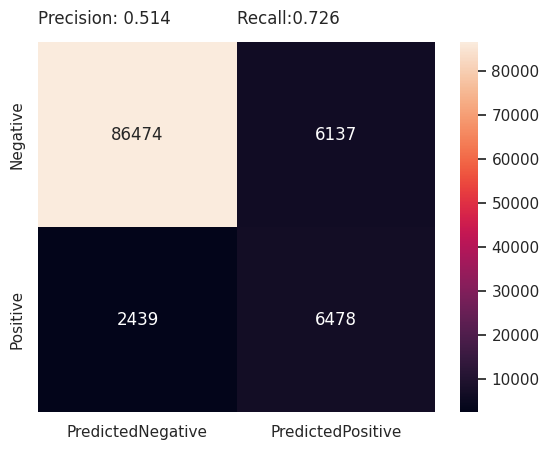

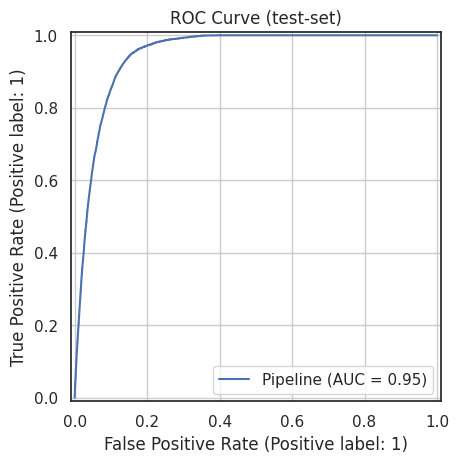

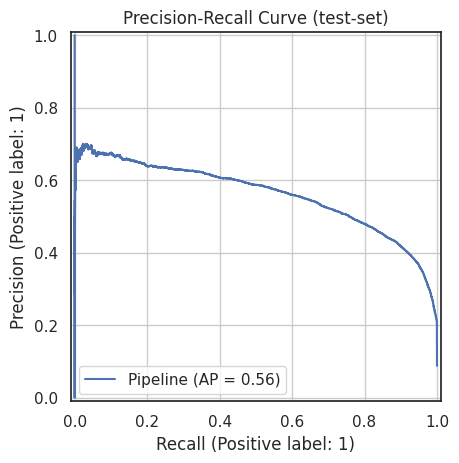

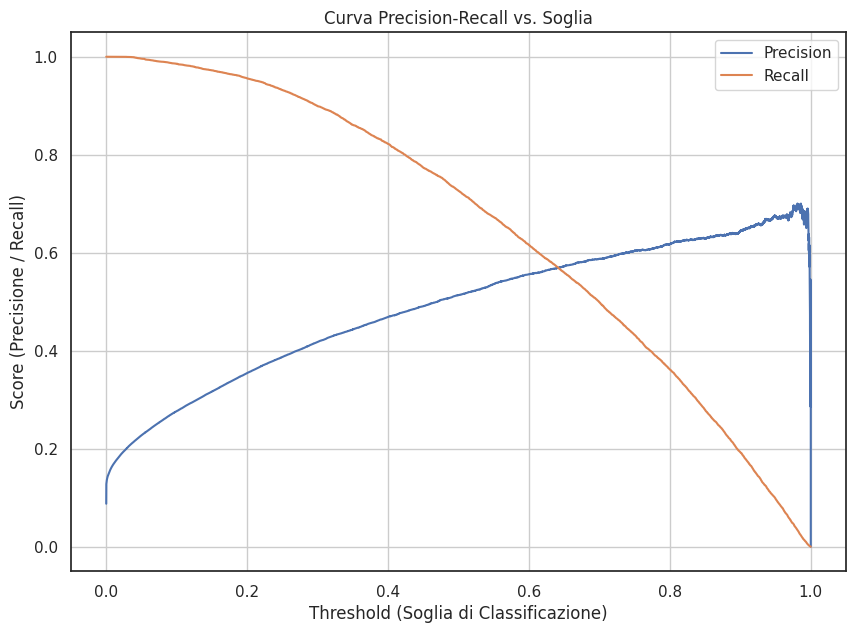

In [ ]:
#metriche di classificazione
print(classification_report(y_test,
                            model.predict(X_test)))
plot_confusion_matrix(y_test,
                      model.predict(X_test),
                      labels=["Negative","Positive"],
                      show_precision_recall=True)

RocCurveDisplay.from_estimator(model, X_test, y_test)
plt.title('ROC Curve (test-set)')
plt.grid()
plt.show()

PrecisionRecallDisplay.from_estimator(model, X_test, y_test)
plt.title('Precision-Recall Curve (test-set)')
plt.grid()
plt.show()
PrecisionRecallCurve_vs_Threshold(model,X_test, y_test)

Si osserva che le metriche di classificazione non sono peggiorate nonostante la rimozione di diverse variabili non rilevanti rispetto al modello baseline LG_1. Questo risultato è particolarmente utile, poiché consente di ottenere le stesse performance di classificazione con un modello significativamente più snello ed efficiente.










**Analisi dei coefficienti BETA di Regressione logistica (modello LG_2)**

A questo punto, procederemo con l'analisi dell'importanza delle feature e dei coefficienti **beta di regressione** per il **modello 2**, con l'obiettivo di estrarre insight di business significativi. Questo permetterà di orientare gli stakeholder e le banche verso l'implementazione di politiche di credito **data-driven** nei confronti dei clienti che presenteranno una richiesta di credito.

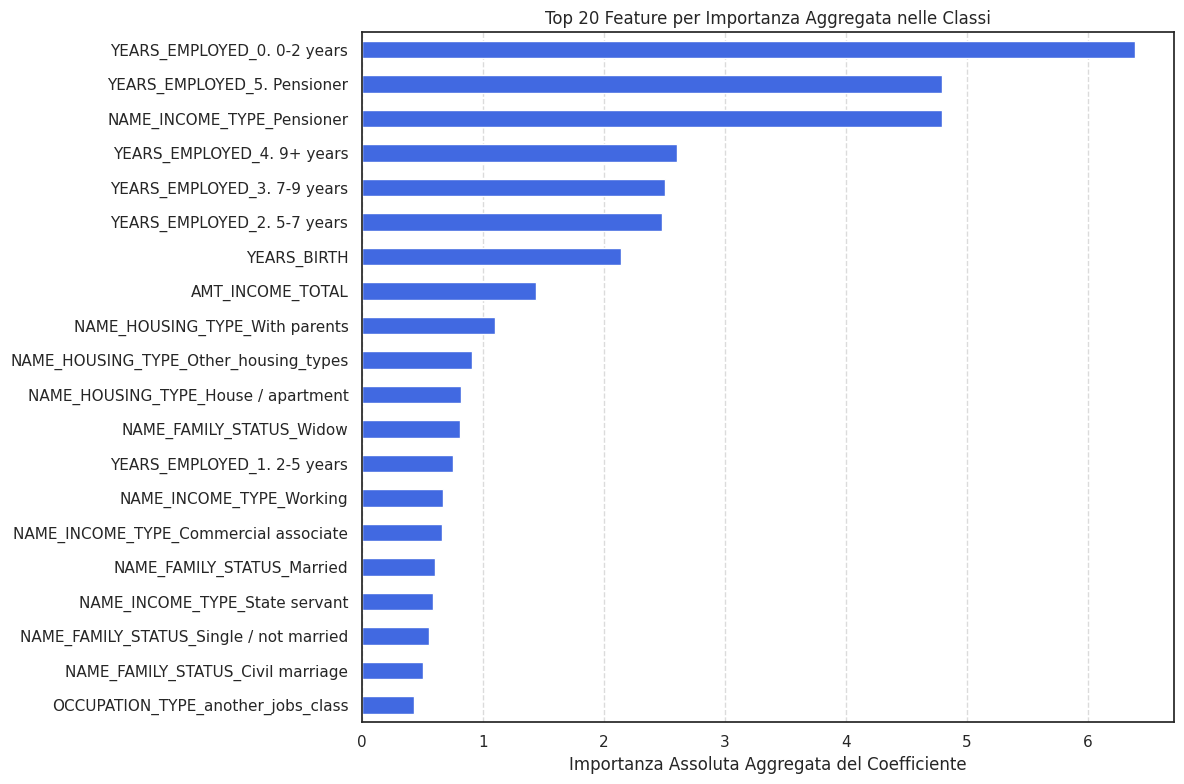

Feature meno rilevanti (aggregato < 0.05):
                          Class_0  Abs_Sum
NAME_INCOME_TYPE_Student  0.02705  0.02705


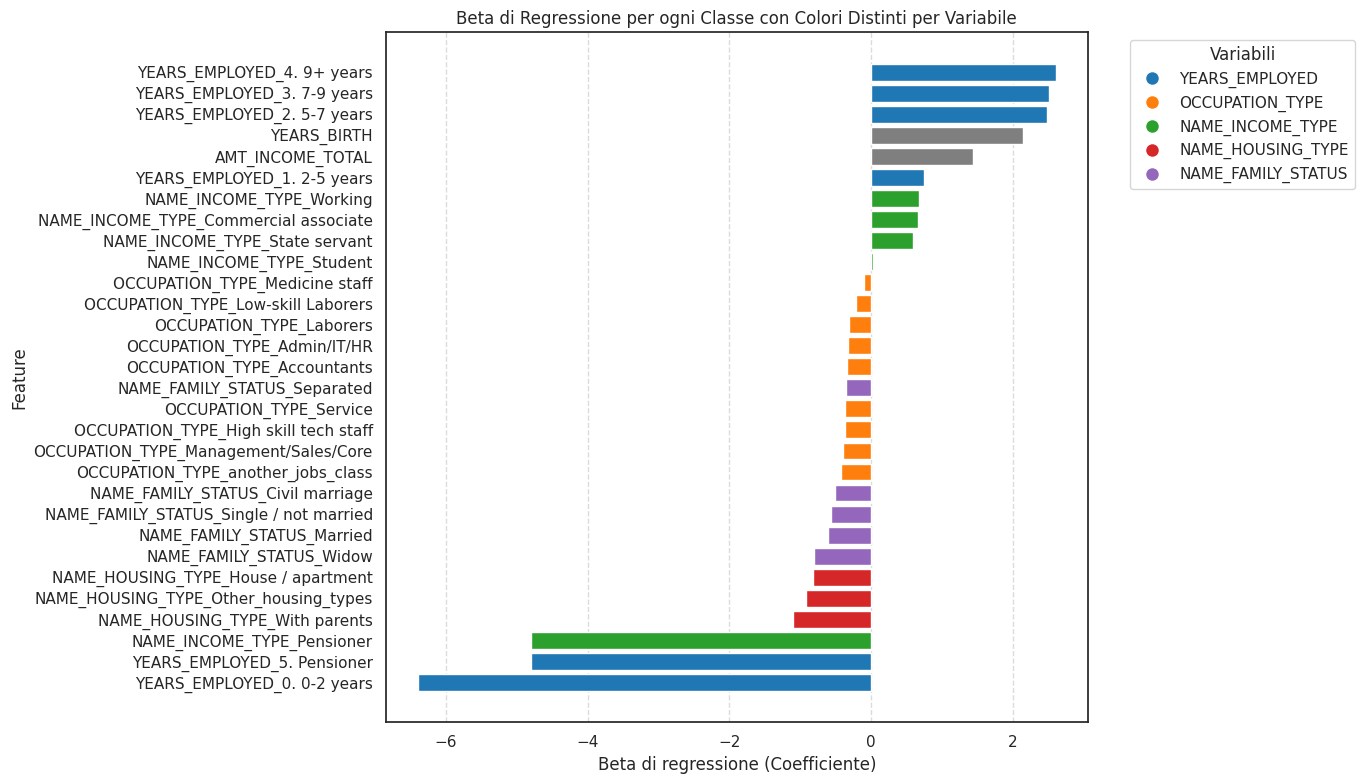

In [ ]:
#importanza assoluta delle features nel modello
feature_names, feature_groups = get_feature_names_from_column_transformer(preproc)
logreg = model.named_steps['logisticregression']
coefficients = logreg.coef_  # Shape: (n_classes, n_features)
coef_df = pd.DataFrame(coefficients.T,
                       columns=[f'Class_{i}' for i in range(coefficients.shape[0])],
                       index=feature_names)
coef_df['Abs_Sum'] = coef_df.abs().sum(axis=1)
coef_df = coef_df.sort_values(by='Abs_Sum',
                              ascending=False)
plt.figure(figsize=(12, 8))
coef_df['Abs_Sum'].head(20).plot(kind='barh', color='royalblue')
plt.xlabel('Importanza Assoluta Aggregata del Coefficiente')
plt.title('Top 20 Feature per Importanza Aggregata nelle Classi')
plt.gca().invert_yaxis()
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()
# Output delle feature meno rilevanti (coefficiente aggregato < 0.05)
insignificant_features_agg = coef_df[coef_df['Abs_Sum'] < 0.05]
print("Feature meno rilevanti (aggregato < 0.05):")
print(insignificant_features_agg)

#visualizzazione dei beta di regressione
coef_df = pd.DataFrame(coefficients.T,
                       columns=[f'Class_{i}' for i in range(coefficients.shape[0])],
                       index=feature_names)
coef_df = coef_df.sort_values(by='Class_0',
                              ascending=False)
# Colori distinti per variabili categoriali
categorical_colors = {'YEARS_EMPLOYED': 'tab:blue',
                      'OCCUPATION_TYPE': 'tab:orange',
                      'NAME_INCOME_TYPE': 'tab:green',
                      'NAME_HOUSING_TYPE': 'tab:red',
                      'NAME_FAMILY_STATUS': 'tab:purple'}
# Per ogni classe della variabile, assegniamo un colore fisso
color_mapping = {}
for feature in coef_df.index:
    # Trova la variabile principale a cui appartiene la feature
    feature_group = next((group for group in feature_groups if feature in feature_groups[group]), None)
    if feature_group:
        color_mapping[feature] = categorical_colors.get(feature_group, 'tab:gray')  # Colore default se non trovato
    else:
        color_mapping[feature] = 'tab:gray'
plt.figure(figsize=(14, 8))
for i, feature in enumerate(coef_df.index):
    color = color_mapping[feature]
    plt.barh(feature, coef_df.loc[feature, 'Class_0'], color=color)
plt.xlabel('Beta di regressione (Coefficiente)')
plt.ylabel('Feature')
plt.title('Beta di Regressione per ogni Classe con Colori Distinti per Variabile')
plt.gca().invert_yaxis()  # Invertire l'asse y per mostrare le feature più importanti in alto
plt.grid(axis='x', linestyle='--', alpha=0.7)
handles = [plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=color, markersize=10) for color in categorical_colors.values()]
labels = list(categorical_colors.keys())
plt.legend(handles=handles, labels=labels, title='Variabili', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()


Grafico Top 20 Feature per Importanza Aggregata
- Mostra le 20 feature più importanti in base alla somma dei valori assoluti dei coefficienti di regressione
- Le feature più influenti includono:
  - YEARS_EMPLOYED in varie fasce (4.9+ anni, 3.7-9 anni, 2.5-7 anni)
  - YEARS_BIRTH (età)
  - AMT_INCOME_TOTAL (reddito totale)
  - Varie categorie di NAME_INCOME_TYPE (Working, Commercial associate, State servant)
- Viene segnalata una feature poco rilevante: NAME_INCOME_TYPE_Student con valore aggregato 0.02705

Grafico 2: Beta di Regressione e relazione con il Target= 1
- Visualizza i coefficienti di regressione (beta) per la Classe 0 (TARGET=1), con colori distinti per categorie di variabili
- Le variabili sono raggruppate per colore:
  - YEARS_EMPLOYED: blu
  - OCCUPATION_TYPE: arancione
  - NAME_INCOME_TYPE: verde
  - NAME_HOUSING_TYPE: rosso
  - NAME_FAMILY_STATUS: viola
- Alcune feature mostrano coefficienti negativi significativi (fino a -6) che corrispondo fondamentalmente a lavoratori con 0-2 anni di impiego e Pensionati. Queste 2 sono le rappresentanti di classe che più correlano negativamente con il target 1 (a favore del target 0),  cosi come in misura minore il vivere con i propri genitori non sono buoni segni di affidabilità creditizia.

- La distribuzione dei coefficienti varia ampiamente tra le diverse feature, e  possiamo vedere che essere impiegati da più di 5 anni, avere un età adulta e un ottimo stipendio sono buoni indicatori di correlazione positiva con il target 1 e quindi di affidabilità creditizia del cliente.

Conclusioni
L'analisi mostra che le variabili relative agli anni di impiego, reddito e stato occupazionale sono tra le più influenti nel modello. Le feature categoriali sono state correttamente codificate e visualizzate in modo da evidenziare il loro contributo relativo alle diverse classi di predizione.

### 5.1.3 - **MODELLO LG3-SDG CLASSIFIER**

La regressione logistica a discesa del gradiente è un approccio che combina il modello di regressione logistica con l'algoritmo di ottimizzazione della discesa del gradiente.

La regressione logistica a discesa del gradiente utilizza un algoritmo iterativo per ottimizzare i parametri del modello minimizzando la funzione di costo (log-loss). Questo approccio è essenziale per gestire funzioni non lineari, grandi dataset e integrare tecniche di regolarizzazione (L1, L2). Varianti come SGD e Mini-batch Gradient Descent migliorano l'efficienza computazionale aggiornando i parametri su sottoinsiemi di dati.

- **Modello di ottimizzazione con discesa stocastica del gradiente SDG CLASSIFIER**

In [ ]:
start_time = time.time()
dflog = df2.copy()
selected_features = ['YEARS_EMPLOYED',
                     'NAME_INCOME_TYPE',
                     'NAME_HOUSING_TYPE',
                     'OCCUPATION_TYPE',
                     'NAME_FAMILY_STATUS',
                     'YEARS_BIRTH',
                     'AMT_INCOME_TOTAL',
                     'TARGET']
dflog = dflog[selected_features]
X = dflog.drop('TARGET', axis=1)
y = dflog['TARGET']
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size=0.3,
                                                    random_state=0,
                                                    stratify=y)
numerical_vars = ['AMT_INCOME_TOTAL', 'YEARS_BIRTH']
multi_cat_vars = ['YEARS_EMPLOYED',
                  'NAME_INCOME_TYPE',
                  'NAME_HOUSING_TYPE',
                  'OCCUPATION_TYPE',
                  'NAME_FAMILY_STATUS']
pipe_num = make_pipeline(SimpleImputer(strategy='mean'),
                         StandardScaler())
pipe_multi = make_pipeline(SimpleImputer(strategy='most_frequent'),
                           OneHotEncoder(sparse_output=False))
preproc = ColumnTransformer(
    [('num',  pipe_num,   numerical_vars),
     ('mult', pipe_multi, multi_cat_vars)])
# Definizione della pipeline finale con SGDClassifier
model = imb_make_pipeline(preproc,
                          SMOTE(sampling_strategy=0.3,
                                random_state=42),
                          SGDClassifier(loss='log_loss', #loss='log_loss' emula il comportamento della regressione logistica
                                        max_iter=1000,
                                         random_state=RANDOM_SEED))
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
end_time = time.time()
execution_time = end_time - start_time
print(f"Tempo di esecuzione: {execution_time} secondi")

Tempo di esecuzione: 5.1156158447265625 secondi


- **Metriche di classificazione**

              precision    recall  f1-score   support

           0       0.97      0.94      0.95     92611
           1       0.52      0.71      0.60      8917

    accuracy                           0.92    101528
   macro avg       0.74      0.83      0.78    101528
weighted avg       0.93      0.92      0.92    101528



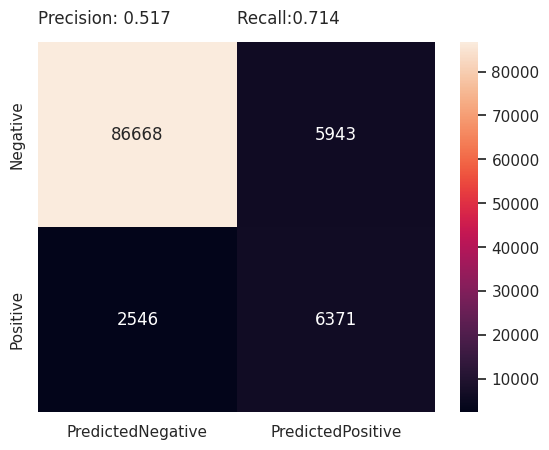

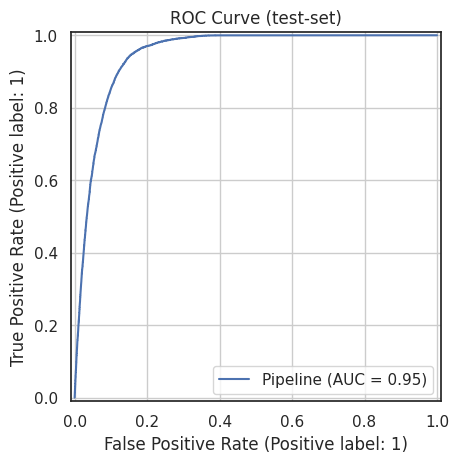

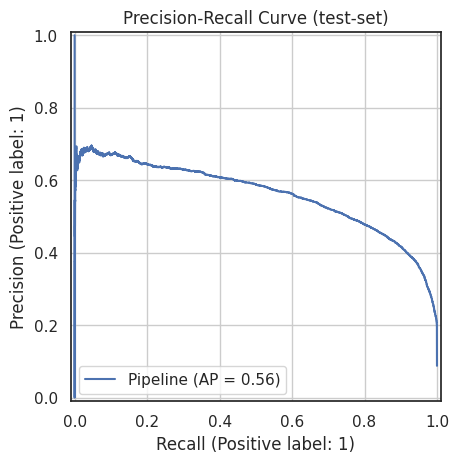

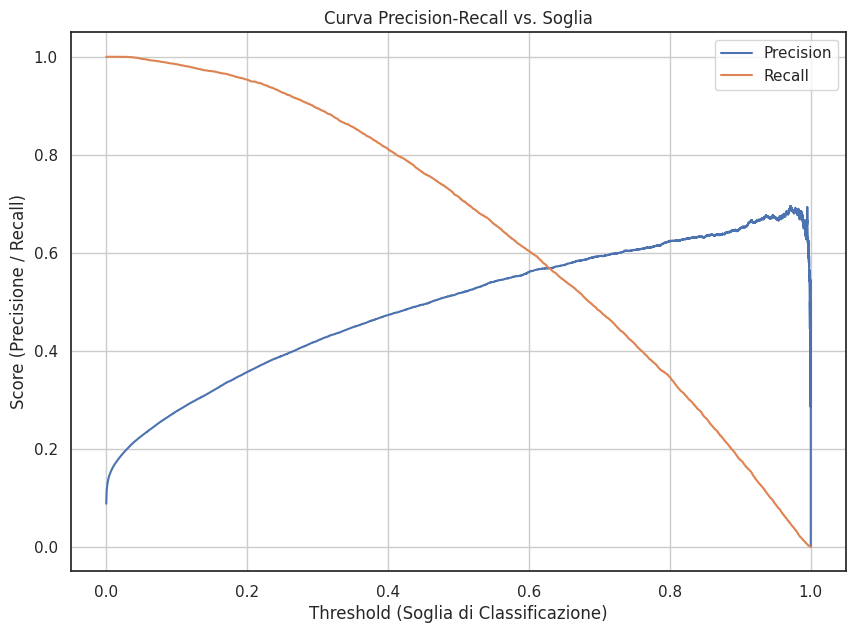

In [ ]:
#metriche di classificazione
print(classification_report(y_test,
                            model.predict(X_test)))
plot_confusion_matrix(y_test,
                      model.predict(X_test),
                      labels=["Negative","Positive"],
                      show_precision_recall=True)

RocCurveDisplay.from_estimator(model, X_test, y_test)
plt.title('ROC Curve (test-set)')
plt.grid()
plt.show()

PrecisionRecallDisplay.from_estimator(model, X_test, y_test)
plt.title('Precision-Recall Curve (test-set)')
plt.grid()
plt.show()
PrecisionRecallCurve_vs_Threshold(model,X_test, y_test)

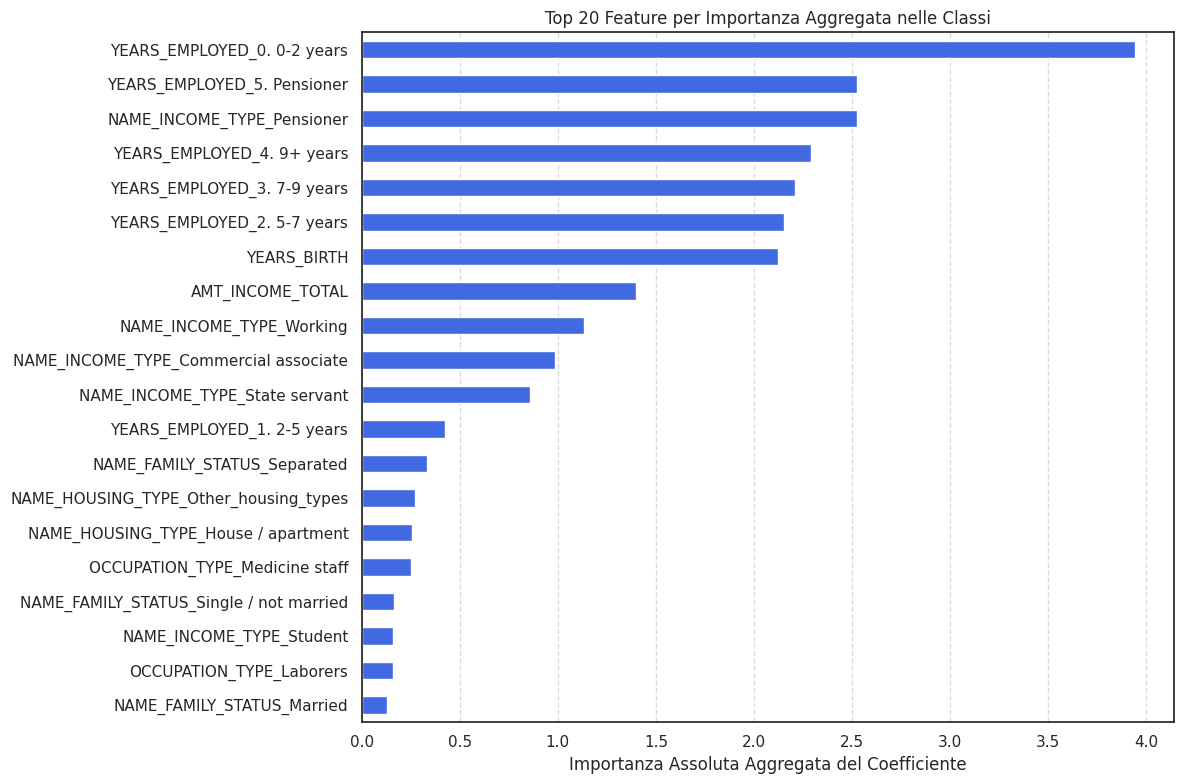

Feature meno rilevanti (aggregato < 0.05):
                                        Class_0   Abs_Sum
OCCUPATION_TYPE_Service               -0.026821  0.026821
OCCUPATION_TYPE_Management/Sales/Core  0.022153  0.022153
OCCUPATION_TYPE_Accountants            0.008851  0.008851


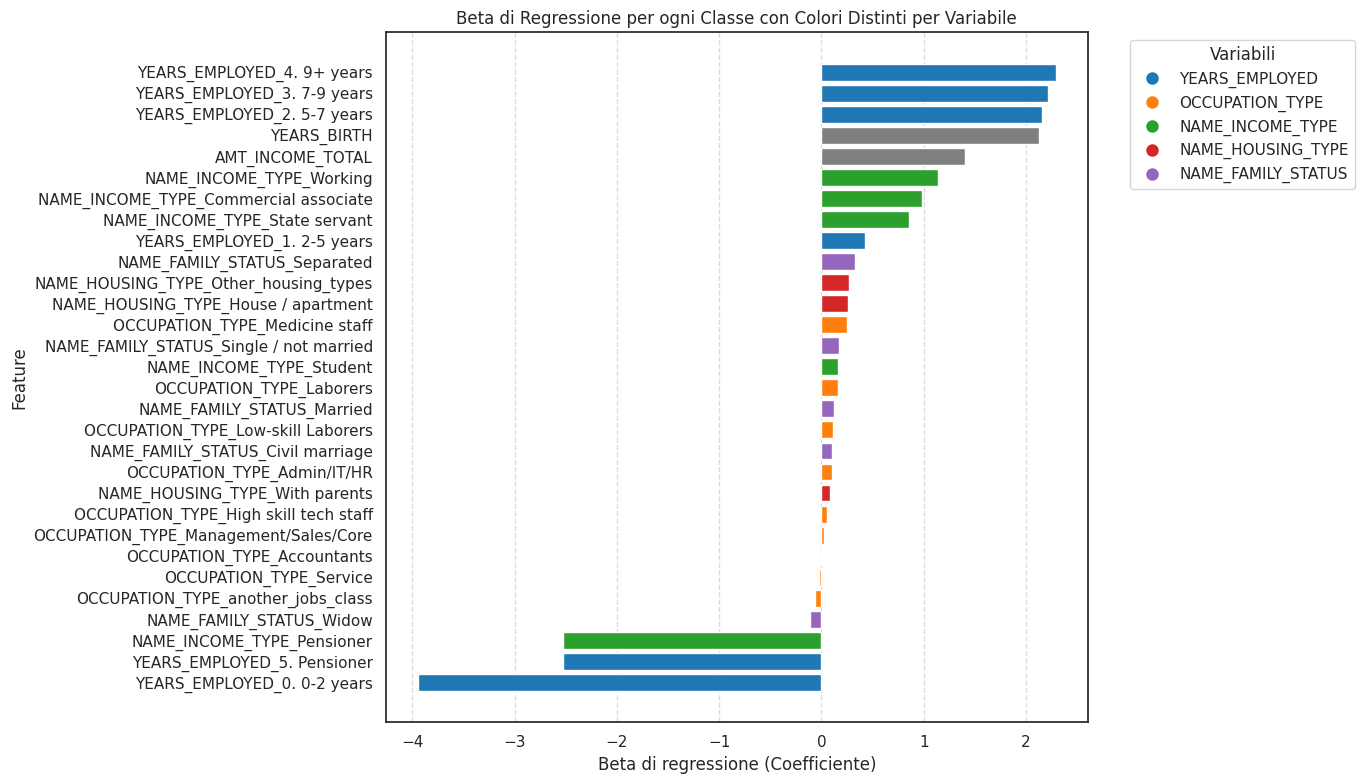

In [ ]:
#importanza assoluta delle features nel modello
feature_names, feature_groups = get_feature_names_from_column_transformer(preproc)
logreg = model.named_steps['sgdclassifier']
coefficients = logreg.coef_  # Shape: (n_classes, n_features)
coef_df = pd.DataFrame(coefficients.T, columns=[f'Class_{i}' for i in range(coefficients.shape[0])], index=feature_names)
coef_df['Abs_Sum'] = coef_df.abs().sum(axis=1)
coef_df = coef_df.sort_values(by='Abs_Sum', ascending=False)
plt.figure(figsize=(12, 8))
coef_df['Abs_Sum'].head(20).plot(kind='barh', color='royalblue')
plt.xlabel('Importanza Assoluta Aggregata del Coefficiente')
plt.title('Top 20 Feature per Importanza Aggregata nelle Classi')
plt.gca().invert_yaxis()
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()
# Output delle feature meno rilevanti (coefficiente aggregato < 0.05)
insignificant_features_agg = coef_df[coef_df['Abs_Sum'] < 0.05]
print("Feature meno rilevanti (aggregato < 0.05):")
print(insignificant_features_agg)

#visualizzazione dei beta di regressione
coef_df = pd.DataFrame(coefficients.T, columns=[f'Class_{i}' for i in range(coefficients.shape[0])], index=feature_names)
coef_df = coef_df.sort_values(by='Class_0', ascending=False)
categorical_colors = {'YEARS_EMPLOYED': 'tab:blue',
                      'OCCUPATION_TYPE': 'tab:orange',
                      'NAME_INCOME_TYPE': 'tab:green',
                      'NAME_HOUSING_TYPE': 'tab:red',
                      'NAME_FAMILY_STATUS': 'tab:purple'}
color_mapping = {}
for feature in coef_df.index:
    feature_group = next((group for group in feature_groups if feature in feature_groups[group]), None)
    if feature_group:
        color_mapping[feature] = categorical_colors.get(feature_group, 'tab:gray')  # Colore default se non trovato
    else:
        color_mapping[feature] = 'tab:gray'
plt.figure(figsize=(14, 8))
for i, feature in enumerate(coef_df.index):
    color = color_mapping[feature]
    plt.barh(feature, coef_df.loc[feature, 'Class_0'], color=color)
plt.xlabel('Beta di regressione (Coefficiente)')
plt.ylabel('Feature')
plt.title('Beta di Regressione per ogni Classe con Colori Distinti per Variabile')
plt.gca().invert_yaxis()  # Invertire l'asse y per mostrare le feature più importanti in alto
plt.grid(axis='x', linestyle='--', alpha=0.7)
handles = [plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=color, markersize=10) for color in categorical_colors.values()]
labels = list(categorical_colors.keys())
plt.legend(handles=handles, labels=labels, title='Variabili', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

Il modello di discesa stocastica del gradiente conferma le metriche di classificazione dei due modelli di regressione logistica precedenti, mantenendo invariata l'importanza descrittiva delle feature e l'andamento dei coefficienti beta ai fini dell'analisi dell'affidabilità creditizia del cliente.


## 5.2 - **MODELLO CON RETE NEURALE (MLPClassifier)**

Il modello 5.2 è un Multilayer Perceptron (MLP). Un MLP è una rete neurale artificiale composta da strati di neuroni organizzati in input layer, hidden layers e output layer. Ogni neurone applica una funzione di attivazione (come ReLU o sigmoid) per apprendere rappresentazioni complesse dai dati. È particolarmente efficace per problemi non lineari e richiede un'accurata ottimizzazione dei parametri per evitare overfitting.

In questo progetto il MLP utilizza **2 strati nascosti con 4 e 3 neuroni rispettivamente**. La funzione di attivazione di default per i layer nascosti è ReLU, che introduce non linearità e aiuta a gestire il vanishing gradient. Per l'output layer, trattandosi di classificazione binaria, viene applicata una funzione sigmoidale che converte il risultato in una probabilità tra 0 e 1.

In [ ]:
start_time = time.time()
dfnn = df2.copy()
selected_features = [
    'YEARS_EMPLOYED',
    'NAME_INCOME_TYPE',
    'NAME_HOUSING_TYPE',
    'OCCUPATION_TYPE',
    'NAME_FAMILY_STATUS',
    'YEARS_BIRTH',
    'AMT_INCOME_TOTAL',
    'TARGET']

dfnn = dfnn[selected_features]
X = dfnn.drop('TARGET', axis=1)
y = dfnn['TARGET']
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.3,
    random_state=0,
    stratify=y)
numerical_vars = ['AMT_INCOME_TOTAL', 'YEARS_BIRTH']
multi_cat_vars = [
    'YEARS_EMPLOYED',
    'NAME_INCOME_TYPE',
    'NAME_HOUSING_TYPE',
    'OCCUPATION_TYPE',
    'NAME_FAMILY_STATUS']

pipe_num = make_pipeline(
    SimpleImputer(strategy='mean'),
    StandardScaler())

pipe_multi = make_pipeline(
    SimpleImputer(strategy='most_frequent'),
    OneHotEncoder(sparse_output=False))

preproc = ColumnTransformer([
    ('num',  pipe_num,  numerical_vars),
    ('mult', pipe_multi, multi_cat_vars)])

# Pipeline completa: Preprocessing -> SMOTE -> Modello Rete Neurale
model_nn = imb_make_pipeline(preproc,
                             SMOTE(sampling_strategy=0.3, random_state=RANDOM_SEED),
                             MLPClassifier(hidden_layer_sizes=(4, 3), # due strati nascosti con 4 e 3 neuroni
                                           max_iter=500,
                                           random_state=RANDOM_SEED))

print("Addestramento del modello Rete Neurale...")
model_nn.fit(X_train, y_train)
print("Addestramento completato.")
y_pred_nn = model_nn.predict(X_test)
end_time = time.time()
execution_time = end_time - start_time
print(f"Tempo di esecuzione: {execution_time} secondi")

Addestramento del modello Rete Neurale...
Addestramento completato.
Tempo di esecuzione: 21.64008092880249 secondi


- **Metriche di classificazione**

              precision    recall  f1-score   support

           0       0.99      0.95      0.97     92611
           1       0.65      0.89      0.76      8917

    accuracy                           0.95    101528
   macro avg       0.82      0.92      0.86    101528
weighted avg       0.96      0.95      0.95    101528



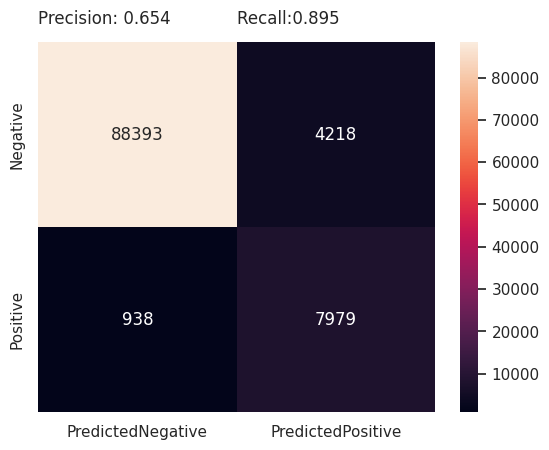

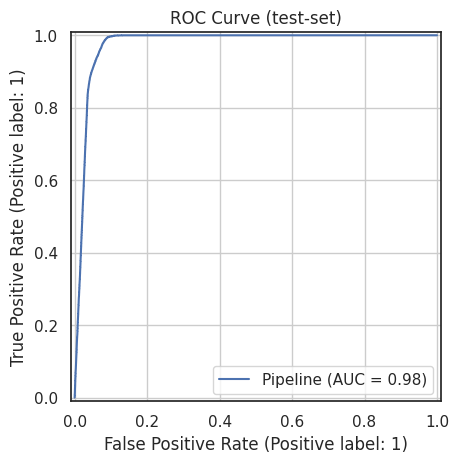

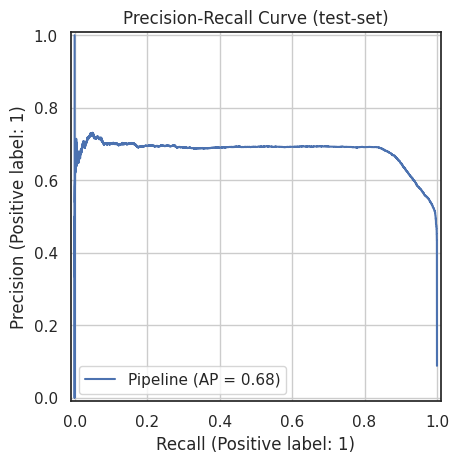

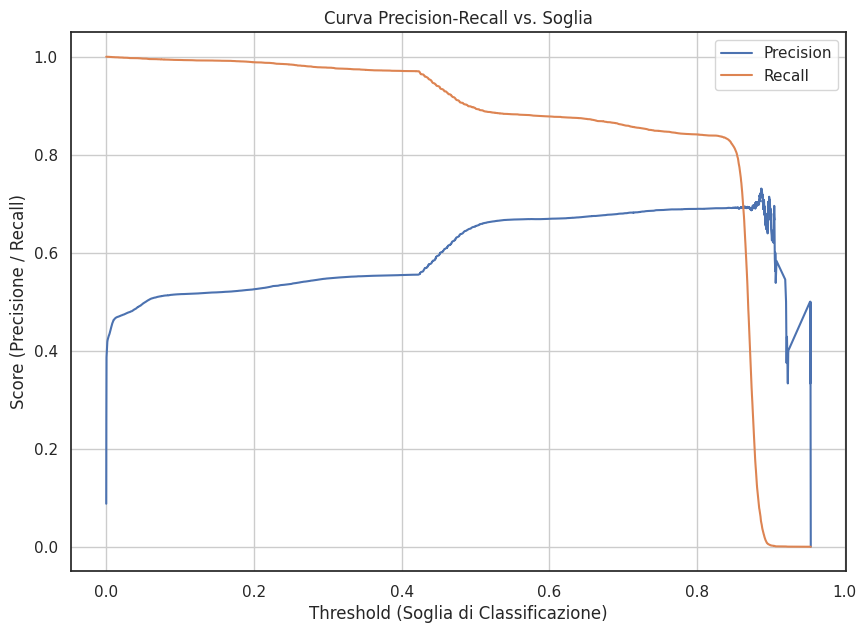

In [ ]:
#metriche di classificazione
print(classification_report(y_test,
                            model_nn.predict(X_test)))
plot_confusion_matrix(y_test,
                      model_nn.predict(X_test),
                      labels=["Negative","Positive"],
                      show_precision_recall=True)

RocCurveDisplay.from_estimator(model_nn, X_test, y_test)
plt.title('ROC Curve (test-set)')
plt.grid()
plt.show()

PrecisionRecallDisplay.from_estimator(model_nn, X_test, y_test)
plt.title('Precision-Recall Curve (test-set)')
plt.grid()
plt.show()
PrecisionRecallCurve_vs_Threshold(model_nn,X_test, y_test)

Dalle metriche di classificazione emerge che il modello a rete neurale migliora le performance predittive, ma al contempo, con soli due strati nascosti, il tempo di addestramento aumenta fino a **24 secondi**. Sebbene le migliori performance siano un punto a favore, il tempo di training così lungo potrebbe non giustificare l’implementazione di una rete neurale per un problema come l'affidabilità creditizia, che può essere affrontato efficacemente con modelli di **regressione logistica** (interpretabili) o **alberi decisionali**, capaci di catturare relazioni non lineari in modo più rapido e con un livello di interpretabilità parziale.


## 5.3 - **MODELLO DECISION TREE**

Un albero decisionale (decision tree) costruisce una struttura ad albero in cui ogni nodo rappresenta una caratteristica e ogni ramo una decisione basata su una soglia. Questo modello è interpretabile ma incline all'overfitting se non viene regolato adeguatamente (es. impostando la profondità massima o il numero minimo di campioni per foglia).

Nel contesto degli alberi decisionali, la purezza si riferisce a quanto i nodi di un albero siano "puri", ovvero quanto i dati all'interno di un nodo siano omogenei riguardo alla classe di destinazione (target). Un nodo è puro quando tutti i campioni che contiene appartengono alla stessa classe.

Gli alberi decisionali utilizzano misure di impurità per determinare la qualità dei nodi. Due delle metriche più comuni sono:
- Indice di Gini
- Entropia

Il modello decisionale seguente ha le seguenti caratteristiche:
- criterion="gini": L'indice di Gini è utilizzato per calcolare l'impurità dei nodi.

- max_depth=12: La profondità massima dell'albero è fissata a 12 livelli, limitando la complessità del modello e prevenendo l'overfitting.

- min_samples_leaf=1: Ogni foglia può contenere almeno un campione, consentendo una maggiore granularità nella classificazione.

- random_state=0: Assicura la riproducibilità dei risultati.

In [ ]:
start_time = time.time()
# 1. Carico e seleziono il dataset
dftree = df2.copy()
selected_features = ['YEARS_EMPLOYED','NAME_INCOME_TYPE','NAME_HOUSING_TYPE',
                     'OCCUPATION_TYPE','NAME_FAMILY_STATUS','YEARS_BIRTH','AMT_INCOME_TOTAL','TARGET']
dftree = dftree[selected_features]
X = dftree.drop('TARGET', axis=1)
y = dftree['TARGET']
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.3,
    random_state=0,
    stratify=y)
numerical_vars = ['AMT_INCOME_TOTAL', 'YEARS_BIRTH']
multi_cat_vars  = ['YEARS_EMPLOYED','NAME_INCOME_TYPE',
                   'NAME_HOUSING_TYPE','OCCUPATION_TYPE',
                   'NAME_FAMILY_STATUS']
pipe_num = make_pipeline(
    SimpleImputer(strategy='mean'),
    StandardScaler())
pipe_multi = make_pipeline(
    SimpleImputer(strategy='most_frequent'),
    OneHotEncoder(sparse_output=False, handle_unknown='ignore'))
preproc = ColumnTransformer([
    ('num',  pipe_num,   numerical_vars),
    ('mult', pipe_multi, multi_cat_vars)])

model = imb_make_pipeline(preproc,
                          SMOTE(sampling_strategy=0.3, random_state=42),
                          DecisionTreeClassifier(
                              criterion="gini",
                              max_depth=12,
                              min_samples_leaf=1,
                              random_state=0))
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
end_time = time.time()
execution_time = end_time - start_time
print(f"Tempo di esecuzione: {execution_time} secondi")

Tempo di esecuzione: 7.8716959953308105 secondi


- **Metriche di classificazione**

              precision    recall  f1-score   support

           0       0.99      0.96      0.97     92611
           1       0.67      0.87      0.76      8917

    accuracy                           0.95    101528
   macro avg       0.83      0.92      0.86    101528
weighted avg       0.96      0.95      0.95    101528



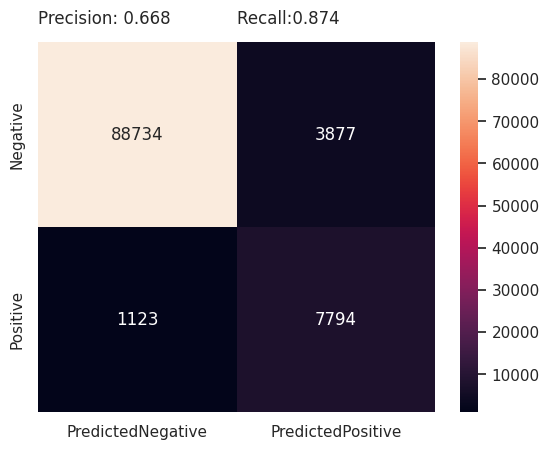

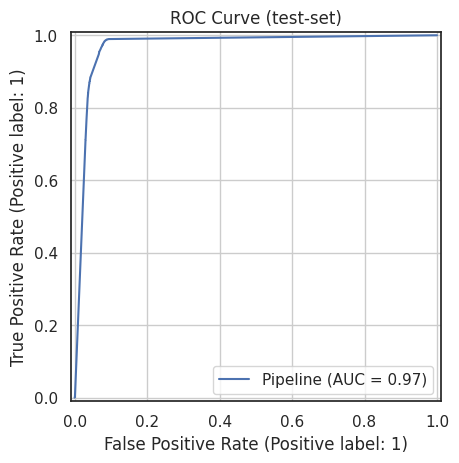

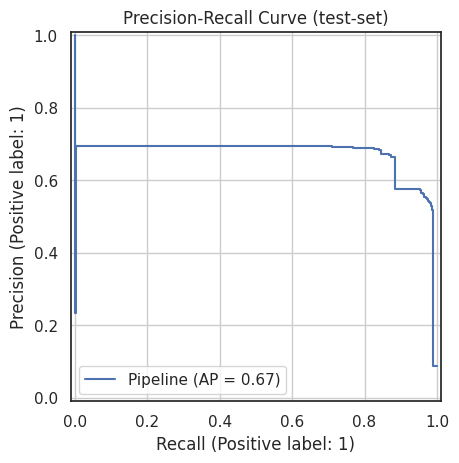

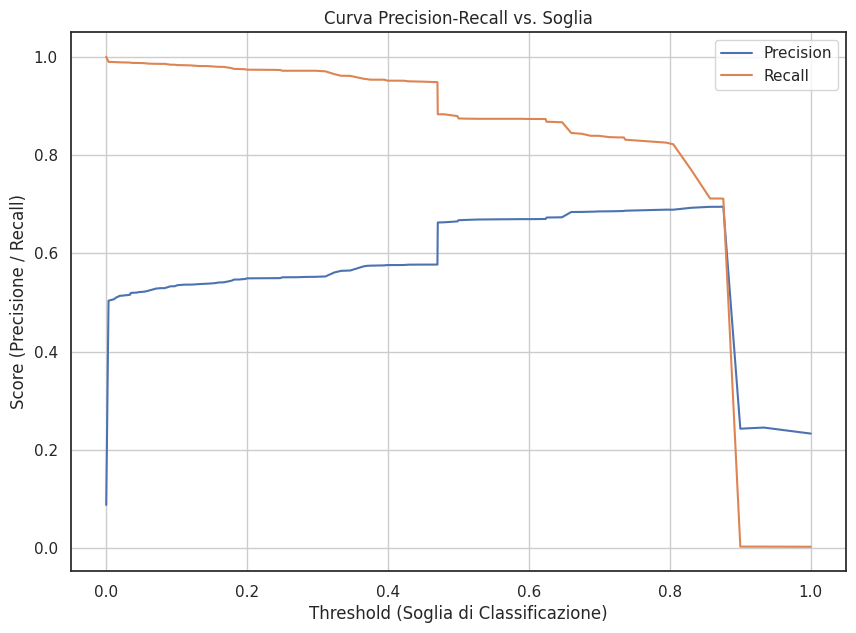

In [ ]:
#metriche di classificazione
print(classification_report(y_test,
                            model.predict(X_test)))
plot_confusion_matrix(y_test,
                      model.predict(X_test),
                      labels=["Negative","Positive"],
                      show_precision_recall=True)

RocCurveDisplay.from_estimator(model, X_test, y_test)
plt.title('ROC Curve (test-set)')
plt.grid()
plt.show()

PrecisionRecallDisplay.from_estimator(model, X_test, y_test)
plt.title('Precision-Recall Curve (test-set)')
plt.grid()
plt.show()
PrecisionRecallCurve_vs_Threshold(model,X_test, y_test)

Con il modello ad albero, abbiamo ottenuto ottime metriche di classificazione, paragonabili, se non superiori, a quelle di una rete neurale, ma con circa **1/5 del tempo** (solo **6 secondi di addestramento**) rispetto a una rete neurale **MLP** con due strati nascosti. Questo evidenzia l'efficacia del modello ad albero in termini di performance e efficienza, rendendolo una scelta vantaggiosa per questo tipo di problema.


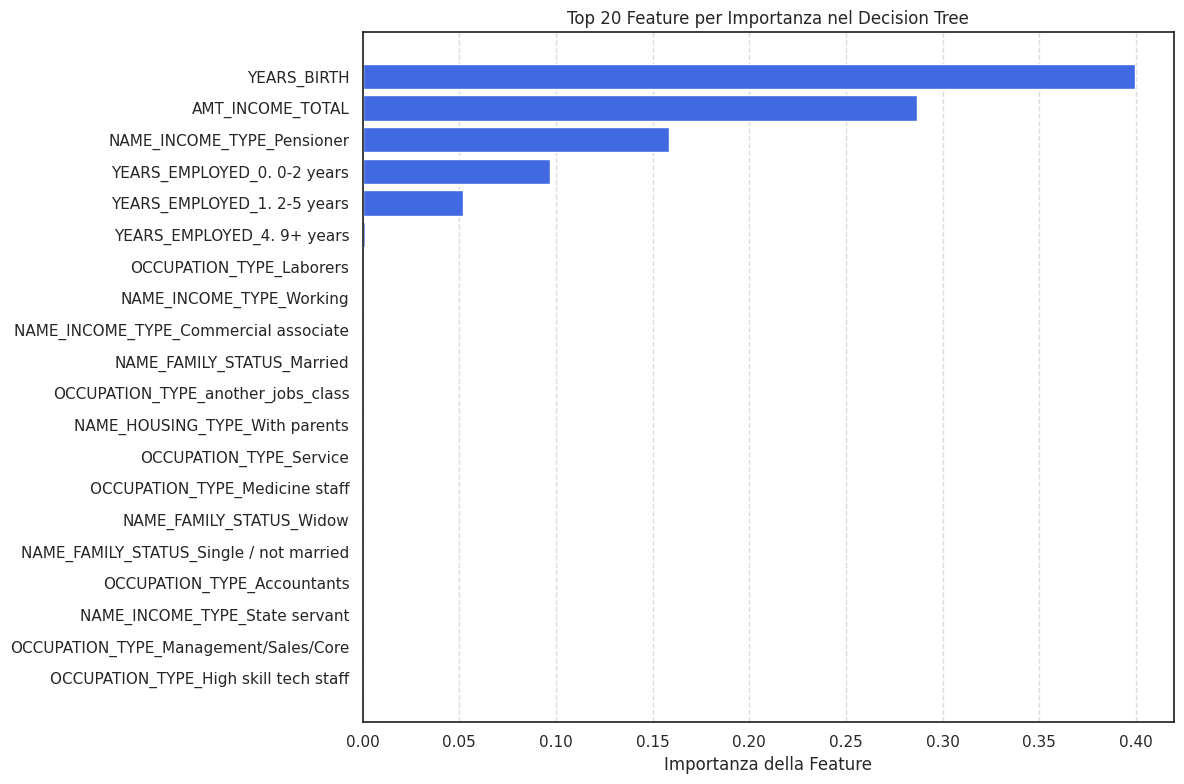

In [ ]:
tree_model = model.named_steps['decisiontreeclassifier']
feature_importances = tree_model.feature_importances_
#Creazione del DataFrame e visualizzazione
importance_df = pd.DataFrame({'Feature': feature_names,
                              'Importance': feature_importances}).sort_values(by='Importance', ascending=False)

plt.figure(figsize=(12, 8))
plt.barh(importance_df['Feature'].head(20),
         importance_df['Importance'].head(20),
         color='royalblue')
plt.xlabel('Importanza della Feature')
plt.title('Top 20 Feature per Importanza nel Decision Tree')
plt.gca().invert_yaxis()
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

Secondo il modello addestrato, le prime 20 features riportate nel grafico di importanza mostrano che il modello assegna la massima importanza alla variabile **Years\_birth** e a **AMT\_INCOME\_TOTAL**. Successivamente, l'importanza decresce con **gli anni di impiego**, con i gruppi 0-2 anni e 2-5 anni che seguono in ordine di rilevanza. Le altre variabili, invece, tendono ad avere una **bassa** o addirittura **nessuna importanza** nella descrizione del problema di classificazione affrontato.


## 5.4 - **MODELLO RANDOM FOREST**

Un Random Forest crea più alberi decisionali addestrati su sottocampioni casuali dei dati e aggrega le previsioni tramite voto di maggioranza (per classificazione) o media (per regressione). Questo approccio riduce l'overfitting e aumenta la stabilità del modello rispetto ai singoli alberi.

La configurazione dell'algoritmo è la seguente:
- criterion="gini": L'indice di Gini è utilizzato per calcolare l'impurità dei nodi.
- max_depth=12: La profondità massima dell'albero è fissata a 12 livelli, limitando la complessità del modello e prevenendo l'overfitting.

- min_samples_leaf=1: Ogni foglia può contenere almeno un campione, consentendo una maggiore granularità nella classificazione.

- random_state=0: Assicura la riproducibilità dei risultati.

In [ ]:
start_time = time.time()
RForest = df2.copy()
selected_features = ['YEARS_EMPLOYED','NAME_INCOME_TYPE','NAME_HOUSING_TYPE',
                     'OCCUPATION_TYPE','NAME_FAMILY_STATUS','YEARS_BIRTH','AMT_INCOME_TOTAL','TARGET']
RForest = RForest[selected_features]
X = RForest.drop('TARGET', axis=1)
y = RForest['TARGET']
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.3,
    random_state=0,
    stratify=y)
numerical_vars = ['AMT_INCOME_TOTAL', 'YEARS_BIRTH']
multi_cat_vars  = ['YEARS_EMPLOYED','NAME_INCOME_TYPE',
                   'NAME_HOUSING_TYPE','OCCUPATION_TYPE',
                   'NAME_FAMILY_STATUS']
pipe_num = make_pipeline(SimpleImputer(strategy='mean'),
                         StandardScaler())
pipe_multi = make_pipeline(SimpleImputer(strategy='most_frequent'),
                           OneHotEncoder(sparse_output=False, handle_unknown='ignore'))
preproc = ColumnTransformer([
    ('num',  pipe_num,   numerical_vars),
    ('mult', pipe_multi, multi_cat_vars)])

model = imb_make_pipeline(preproc,
                          SMOTE(sampling_strategy=0.3, random_state=RANDOM_SEED),
                          RandomForestClassifier(criterion="gini",
                                                 max_depth=12,
                                                 min_samples_leaf=1,
                                                 random_state=RANDOM_SEED))
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
end_time = time.time()
execution_time = end_time - start_time
print(f"Tempo di esecuzione: {execution_time} secondi")

Tempo di esecuzione: 30.539634466171265 secondi


- **METRICHE DI CLASSIFICAZIONE**

              precision    recall  f1-score   support

           0       0.99      0.96      0.97     92611
           1       0.67      0.89      0.77      8917

    accuracy                           0.95    101528
   macro avg       0.83      0.93      0.87    101528
weighted avg       0.96      0.95      0.95    101528



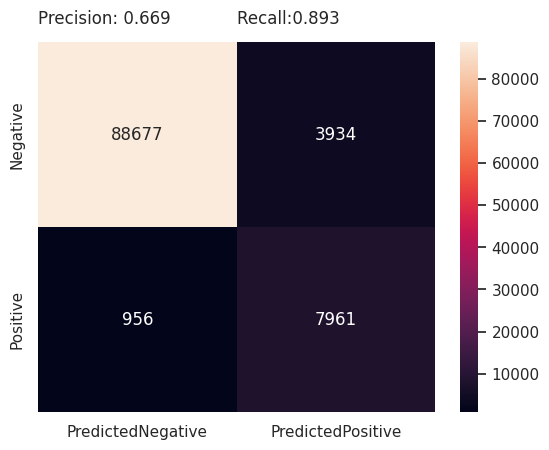

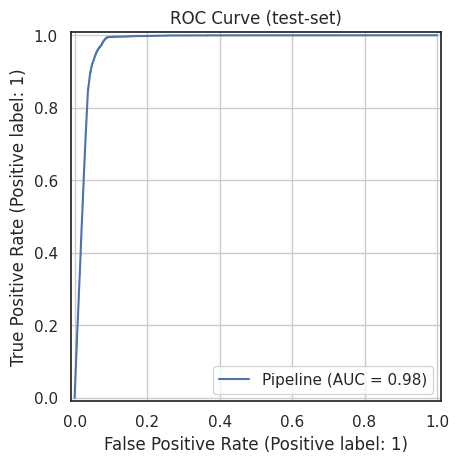

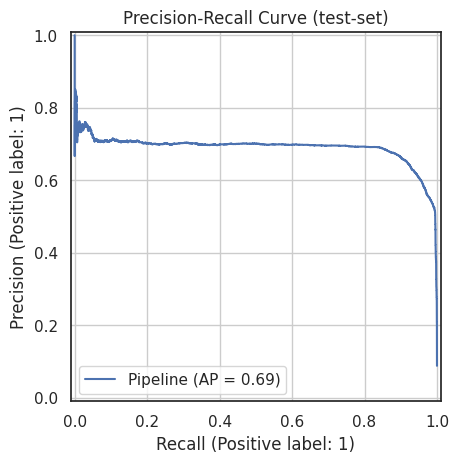

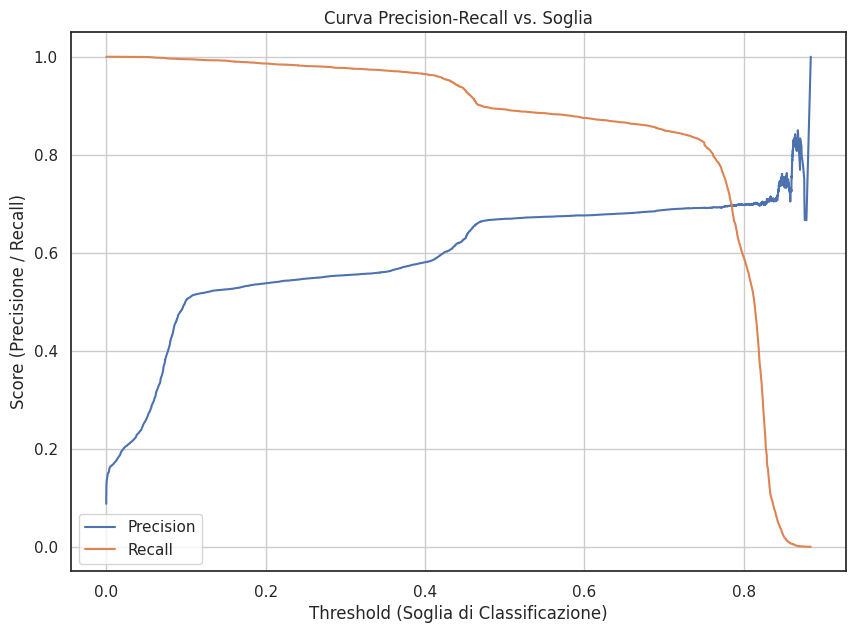

In [ ]:
#metriche di classificazione
print(classification_report(y_test,
                            model.predict(X_test)))
plot_confusion_matrix(y_test,
                      model.predict(X_test),
                      labels=["Negative","Positive"],
                      show_precision_recall=True)

RocCurveDisplay.from_estimator(model, X_test, y_test)
plt.title('ROC Curve (test-set)')
plt.grid()
plt.show()

PrecisionRecallDisplay.from_estimator(model, X_test, y_test)
plt.title('Precision-Recall Curve (test-set)')
plt.grid()
plt.show()
PrecisionRecallCurve_vs_Threshold(model,X_test, y_test)

Il modello Random Forest ha ottime capacità di classificazione, migliorando anche quelle del Decision Tree, già molto buone per il problema di affidabilità creditizia affrontato in questo progetto. L'unica pecca è il tempo di addestramento (quasi 35 secondi), che è pari o superiore a quello di una rete neurale. Questo aspetto deve essere preso in considerazione, poiché potrebbe rappresentare un problema per computer con risorse di calcolo limitate o se i tempi di business per l'addestramento non sono sufficienti.










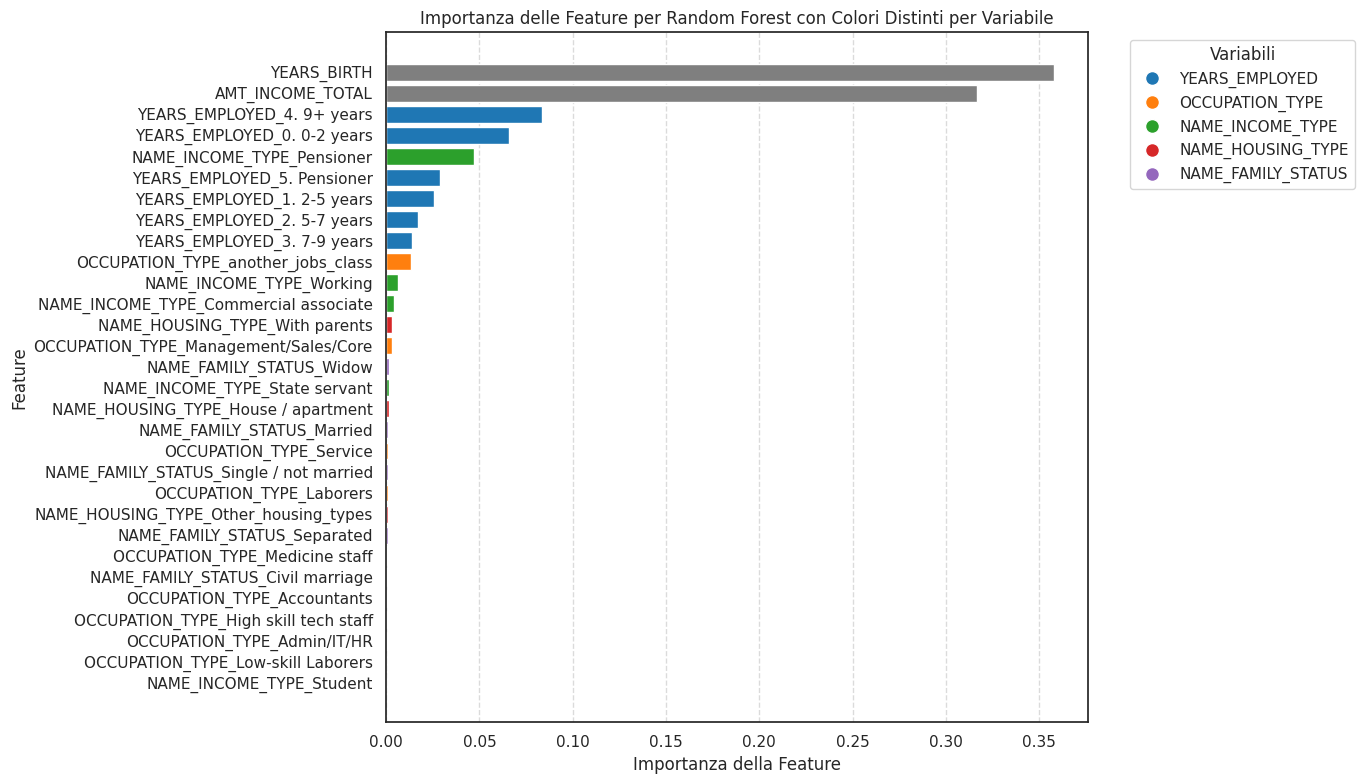

In [ ]:
rf_model = model.named_steps['randomforestclassifier']
importances = rf_model.feature_importances_
feature_names, feature_groups = get_feature_names_from_column_transformer(preproc)
importance_df = pd.DataFrame({'Feature': feature_names,
                              'Importance': importances})
importance_df = importance_df.sort_values(by='Importance', ascending=False)
categorical_colors = {
    'YEARS_EMPLOYED': 'tab:blue',
    'OCCUPATION_TYPE': 'tab:orange',
    'NAME_INCOME_TYPE': 'tab:green',
    'NAME_HOUSING_TYPE': 'tab:red',
    'NAME_FAMILY_STATUS': 'tab:purple'}
color_mapping = {}
for feature in importance_df['Feature']:
    feature_group = next((grp for grp, feats in feature_groups.items() if feature in feats), None)
    color_mapping[feature] = categorical_colors.get(feature_group, 'tab:gray')
plt.figure(figsize=(14, 8))

for i, feature in enumerate(importance_df['Feature']):
    color = color_mapping[feature]
    plt.barh(feature, importance_df.loc[importance_df['Feature'] == feature, 'Importance'].values[0], color=color)
plt.xlabel('Importanza della Feature')
plt.ylabel('Feature')
plt.title('Importanza delle Feature per Random Forest con Colori Distinti per Variabile')
plt.gca().invert_yaxis()  # Invertire l'asse y per mostrare le feature più importanti in alto
plt.grid(axis='x', linestyle='--', alpha=0.7)
handles = [plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=color, markersize=10) for color in categorical_colors.values()]
labels = list(categorical_colors.keys())
plt.legend(handles=handles, labels=labels, title='Variabili', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

Per il modello Random Forest, le variabili più importanti per la sua definizione sono risultate essere:

- età anagrafica clienti

- Il loro stipendio annuale (AMT_INCOME_TOTAL)

- L'età lavorativa maturata nel loro impiego (DAYS_EMPLOYED o YEARS_EMPLOYED)

- La tipologia di impiego (tipo di occupazione)

- La tipologia di dimora (se il cliente possiede casa o vive in una casa in affitto, ecc.)

Queste caratteristiche sono state le principali determinanti nel processo decisionale del modello per prevedere l'affidabilità creditizia

## 5.5 - **MODELLO XGBOOST**

L'algoritmo XGBOOST costruisce alberi in sequenza, ottimizzando ciascun albero per correggere gli errori di quello precedente. Implementa tecniche avanzate di regularizzazione, gestione dei dati sparsi e parallelizzazione, rendendolo particolarmente potente e veloce per problemi complessi.

In [ ]:
start_time = time.time()
df_RForest = df2.copy()
selected_features = [
    'YEARS_EMPLOYED', 'NAME_INCOME_TYPE', 'NAME_HOUSING_TYPE',
    'OCCUPATION_TYPE', 'NAME_FAMILY_STATUS', 'YEARS_BIRTH',
    'AMT_INCOME_TOTAL', 'TARGET']
df_RForest = df_RForest[selected_features]
X = df_RForest.drop('TARGET', axis=1)
y = df_RForest['TARGET']
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size=0.3,
                                                    random_state=RANDOM_SEED,
                                                    stratify=y)
numerical_vars = ['AMT_INCOME_TOTAL', 'YEARS_BIRTH']
multi_cat_vars  = [
    'YEARS_EMPLOYED', 'NAME_INCOME_TYPE',
    'NAME_HOUSING_TYPE', 'OCCUPATION_TYPE',
    'NAME_FAMILY_STATUS']

pipe_num = make_pipeline(
    SimpleImputer(strategy='mean'),
    StandardScaler())
pipe_multi = make_pipeline(
    SimpleImputer(strategy='most_frequent'),
    OneHotEncoder(sparse_output=False, handle_unknown='ignore'))

preproc = ColumnTransformer([
    ('num',  pipe_num,   numerical_vars),
    ('mult', pipe_multi, multi_cat_vars)])

model = imb_make_pipeline(
    preproc,
    SMOTE(sampling_strategy=0.3, random_state=RANDOM_SEED),
    XGBClassifier(
        n_estimators=200,
        max_depth=6,
        learning_rate=0.1,
        subsample=0.8,
        colsample_bytree=0.8,
        objective='binary:logistic',
        use_label_encoder=False,
        eval_metric='logloss',
        random_state=RANDOM_SEED))
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
end_time = time.time()
execution_time = end_time - start_time
print(f"Tempo di esecuzione: {execution_time:.2f} secondi")

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [19:46:13] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Tempo di esecuzione: 12.46 secondi


**Metriche XGBOOST**

              precision    recall  f1-score   support

           0       0.99      0.96      0.97     92611
           1       0.67      0.89      0.76      8917

    accuracy                           0.95    101528
   macro avg       0.83      0.92      0.87    101528
weighted avg       0.96      0.95      0.95    101528



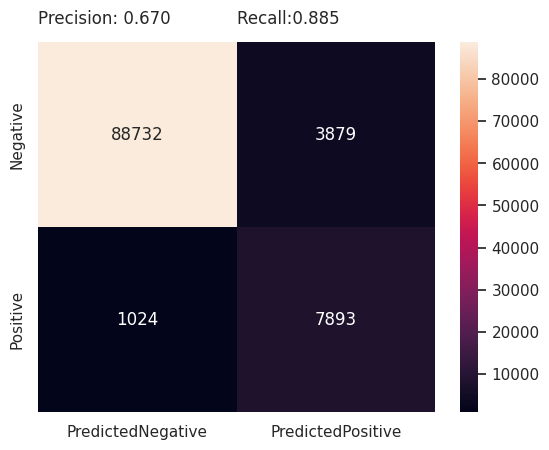

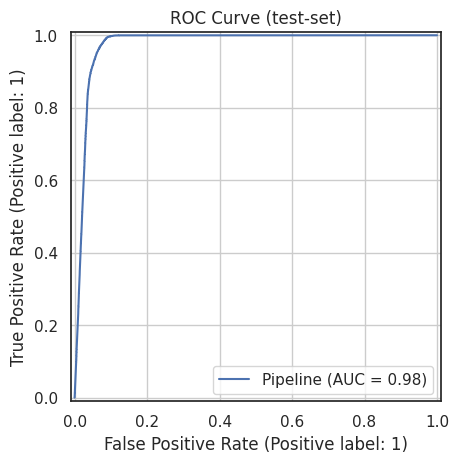

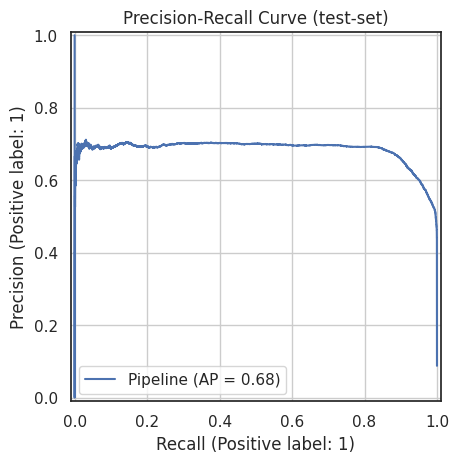

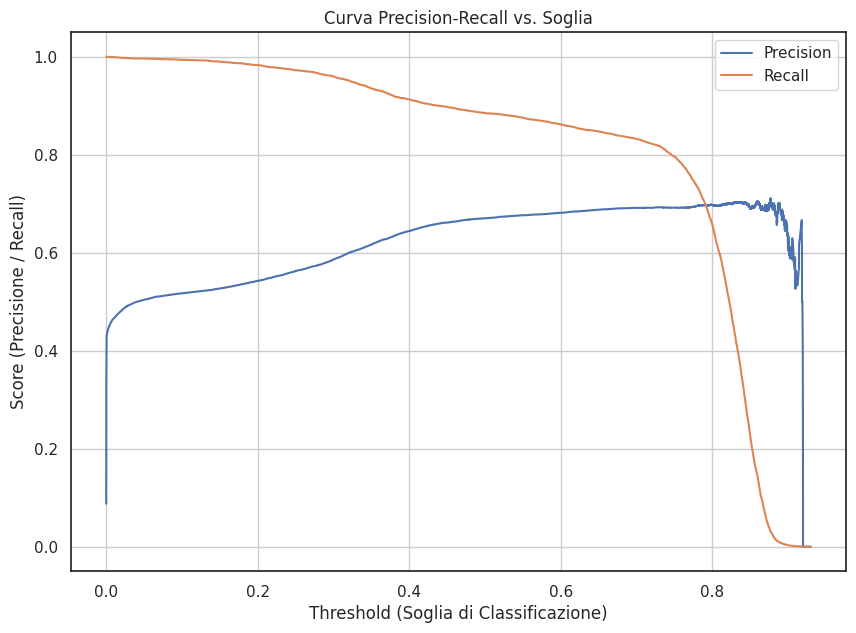

In [ ]:
#metriche di classificazione
print(classification_report(y_test,
                            model.predict(X_test)))
plot_confusion_matrix(y_test,
                      model.predict(X_test),
                      labels=["Negative","Positive"],
                      show_precision_recall=True)

RocCurveDisplay.from_estimator(model, X_test, y_test)
plt.title('ROC Curve (test-set)')
plt.grid()
plt.show()

PrecisionRecallDisplay.from_estimator(model, X_test, y_test)
plt.title('Precision-Recall Curve (test-set)')
plt.grid()
plt.show()
PrecisionRecallCurve_vs_Threshold(model,X_test, y_test)

le prestazioni di classificazione dell'XGBOOST sono simili a quelle ottenute dal RandomForest Classifier, con la differenza di aver impiegato quasi 10 secondi in meno per il fitting del modello.

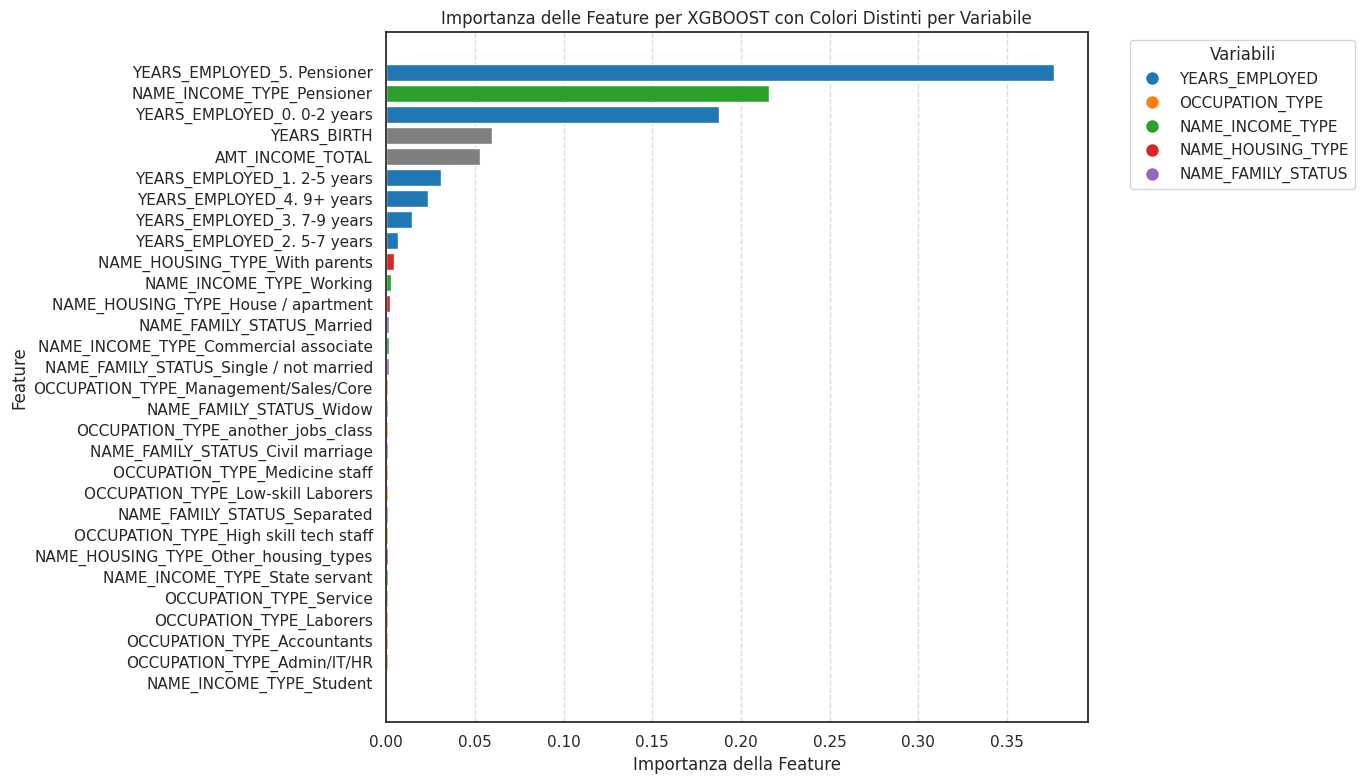

In [ ]:
xgb_model = model.named_steps['xgbclassifier']
importances = xgb_model.feature_importances_
feature_names, feature_groups = get_feature_names_from_column_transformer(preproc)
importance_df = pd.DataFrame({'Feature': feature_names,
                              'Importance': importances})
importance_df = importance_df.sort_values(by='Importance', ascending=False)
categorical_colors = {'YEARS_EMPLOYED': 'tab:blue',
                      'OCCUPATION_TYPE': 'tab:orange',
                      'NAME_INCOME_TYPE': 'tab:green',
                      'NAME_HOUSING_TYPE': 'tab:red',
                      'NAME_FAMILY_STATUS': 'tab:purple'}
color_mapping = {}
for feature in importance_df['Feature']:
    feature_group = next((grp for grp, feats in feature_groups.items() if feature in feats), None)
    color_mapping[feature] = categorical_colors.get(feature_group, 'tab:gray')
plt.figure(figsize=(14, 8))

for i, feature in enumerate(importance_df['Feature']):
    color = color_mapping[feature]
    plt.barh(feature, importance_df.loc[importance_df['Feature'] == feature, 'Importance'].values[0], color=color)
plt.xlabel('Importanza della Feature')
plt.ylabel('Feature')
plt.title('Importanza delle Feature per XGBOOST con Colori Distinti per Variabile')
plt.gca().invert_yaxis()  # Invertire l'asse y per mostrare le feature più importanti in alto
plt.grid(axis='x', linestyle='--', alpha=0.7)
handles = [plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=color, markersize=10) for color in categorical_colors.values()]
labels = list(categorical_colors.keys())
plt.legend(handles=handles, labels=labels, title='Variabili', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

Per il modello Random Forest, le variabili più importanti per la sua definizione sono risultate essere:

- La classe Pensioner (anziani) degli anni di lavoro, che ha una forte influenza nella classificazione

- L'età anagrafica dei clienti e il loro stipendio annuale, che restano tra le feature principali per la definizione del problema di affidabilità creditizia

- A seguire, con importanza decrescente, troviamo le classi relative agli anni di impiego: 2-5 anni, 9+ anni, 7-9 anni e 5-7 anni.

Queste caratteristiche sono state le principali determinanti nel processo decisionale del modello per prevedere l'affidabilità creditizia dei clienti.

# 6 . **PUNTO BONUS (GIUSTIFICAZIONI PER IL RIFIUTO AL RILASCIO DELLA CC)**

Per poter spiegare le motivazioni di un rifiuto, possiamo iniziare visualizzando i contributi delle singole classi di appartenenza del cliente (es. tipo di reddito, abitazione, età, ecc.). In particolare, possiamo analizzare il contributo di ciascuna variabile all'interno del modello principale, che, è bene sottolinearlo, è stato scelto come modello di regressione logistica con discesa stocastica del gradiente per la sua facilità di interpretazione.

Infatti, ogni variabile del modello multivariato è associata in modo lineare al rispettivo coefficiente beta di regressione, il quale è correlato in maniera esponenziale all'odds ratio. L'odds ratio rappresenta il rapporto tra la probabilità che un evento si verifichi (target 1) e la probabilità che lo stesso evento non si verifichi (target 0).

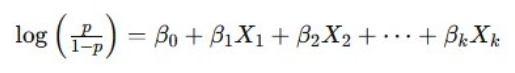

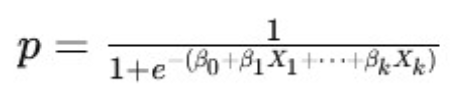

Possiamo osservare che, assumendo che il fitting del modello multivariato di regressione logistica sia eseguito correttamente, la probabilità che si verifichi il target 1 è strettamente legata al valore numerico dei coefficienti beta di ciascuna variabile e al loro segno. Coefficienti positivi e di grande entità aumentano la probabilità del target 1, mentre coefficienti negativi la riducono. Infine, coefficienti beta pari a zero non influenzano la probabilità del target, risultando quindi ininfluenti.



Tempo di esecuzione: 9.031704187393188 secondi


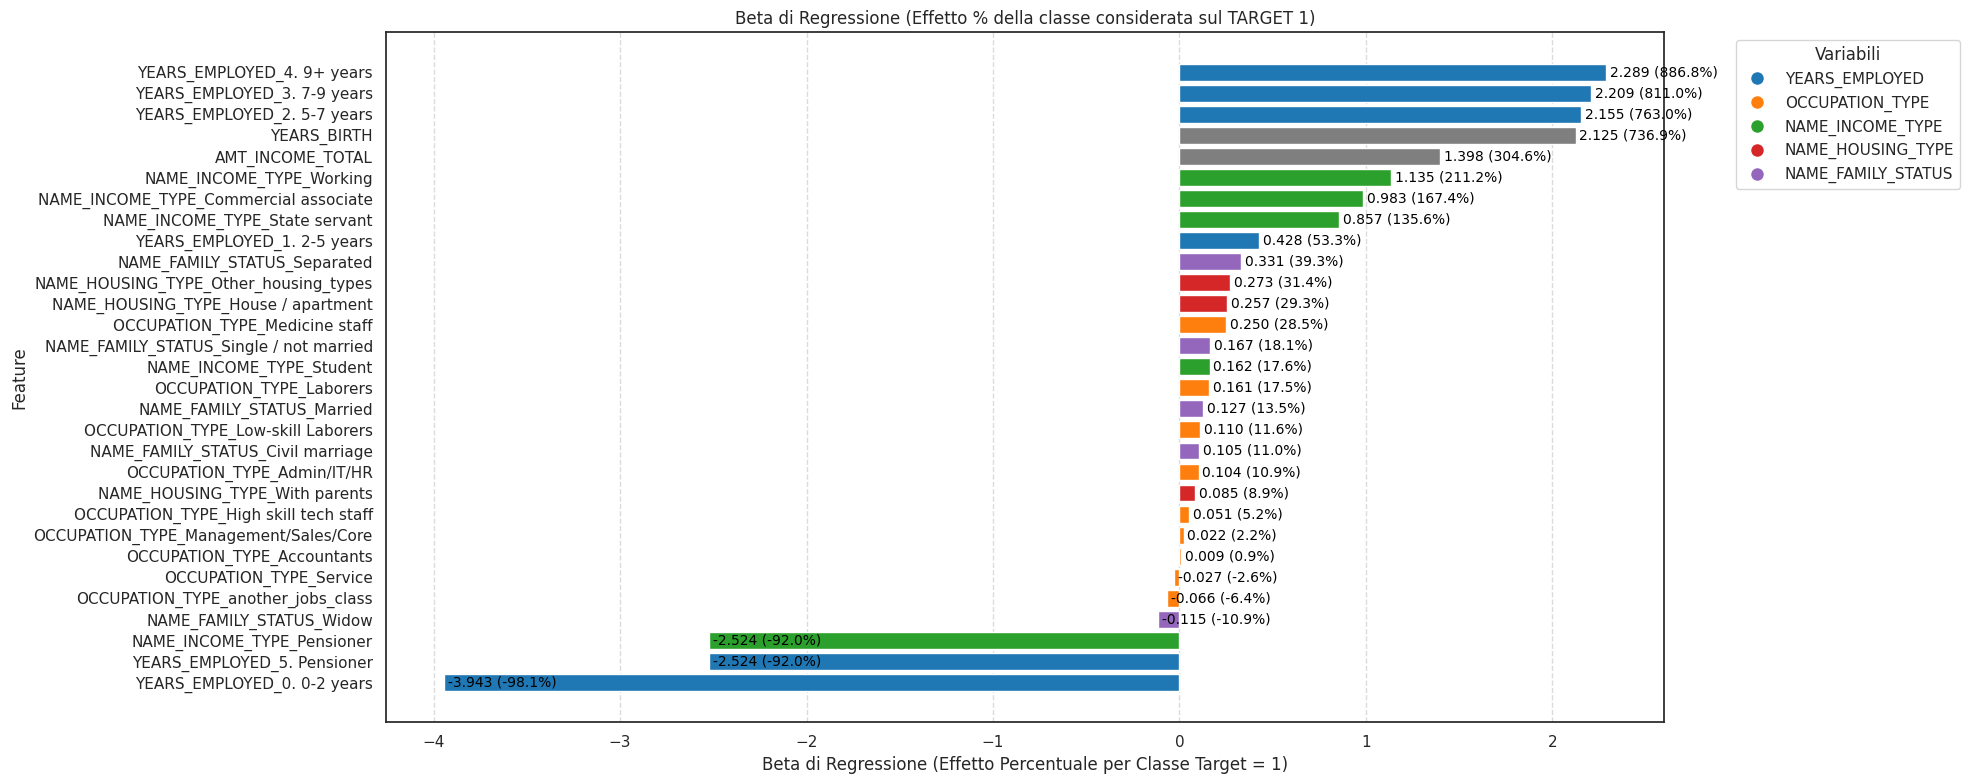

In [ ]:
#modello
start_time = time.time()
dflog = df2.copy()
selected_features = ['YEARS_EMPLOYED',
                     'NAME_INCOME_TYPE',
                     'NAME_HOUSING_TYPE',
                     'OCCUPATION_TYPE',
                     'NAME_FAMILY_STATUS',
                     'YEARS_BIRTH',
                     'AMT_INCOME_TOTAL',
                     'TARGET']
dflog = dflog[selected_features]
X = dflog.drop('TARGET', axis=1)
y = dflog['TARGET']
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size=0.3,
                                                    random_state=0,
                                                    stratify=y)
numerical_vars = ['AMT_INCOME_TOTAL', 'YEARS_BIRTH']
multi_cat_vars = ['YEARS_EMPLOYED',
                  'NAME_INCOME_TYPE',
                  'NAME_HOUSING_TYPE',
                  'OCCUPATION_TYPE',
                  'NAME_FAMILY_STATUS']
pipe_num = make_pipeline(SimpleImputer(strategy='mean'),
                         StandardScaler())
pipe_multi = make_pipeline(SimpleImputer(strategy='most_frequent'),
                           OneHotEncoder(sparse_output=False))
preproc = ColumnTransformer(
    [('num',  pipe_num,   numerical_vars),
     ('mult', pipe_multi, multi_cat_vars)])
model = imb_make_pipeline(preproc,
                          SMOTE(sampling_strategy=0.3,
                                random_state=42),
                          SGDClassifier(loss='log_loss',
                                        max_iter=1000,
                                         random_state=RANDOM_SEED))
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
end_time = time.time()
execution_time = end_time - start_time
print(f"Tempo di esecuzione: {execution_time} secondi")

#estrazione features dal modello
feature_names, feature_groups = get_feature_names_from_column_transformer(preproc)
logreg = model.named_steps['sgdclassifier']
coefficients = logreg.coef_  # Shape: (n_classes, n_features)
# Calcolare gli odds ratio e gli effetti percentuali
odds_ratios = np.exp(coefficients)
percent_effects = (odds_ratios - 1) * 100

# Creare un DataFrame per visualizzare i risultati
coef_df = pd.DataFrame({'Beta': coefficients.flatten(),
                        'Odds Ratio': odds_ratios.flatten(),
                        'Percent Effect': percent_effects.flatten()},
                        index=feature_names)
coef_df = coef_df.sort_values(by='Beta', ascending=False)
categorical_colors = {'YEARS_EMPLOYED': 'tab:blue',
                      'OCCUPATION_TYPE': 'tab:orange',
                      'NAME_INCOME_TYPE': 'tab:green',
                      'NAME_HOUSING_TYPE': 'tab:red',
                      'NAME_FAMILY_STATUS': 'tab:purple'}
color_mapping = {}
for feature in coef_df.index:
    feature_group = next((group for group in feature_groups if feature in feature_groups[group]), None)
    if feature_group:
        color_mapping[feature] = categorical_colors.get(feature_group, 'tab:gray')
    else:
        color_mapping[feature] = 'tab:gray'

#grafico
plt.figure(figsize=(20, 8))
bars = plt.barh(coef_df.index, coef_df['Beta'], color=[color_mapping[feature] for feature in coef_df.index])
for bar, feature in zip(bars, coef_df.index):
    width = bar.get_width()
    percent_effect = coef_df.loc[feature, 'Percent Effect']
    label = f'{width:.3f} ({percent_effect:.1f}%)'
    plt.text(width + 0.02, bar.get_y() + bar.get_height() / 2,
             label, va='center', ha='left', fontsize=10, color='black')
plt.xlabel('Beta di Regressione (Effetto Percentuale per Classe Target = 1)')
plt.ylabel('Feature')
plt.title("Beta di Regressione (Effetto % della classe considerata sul TARGET 1)")
plt.gca().invert_yaxis()
plt.grid(axis='x', linestyle='--', alpha=0.7)
# Aggiungere la legenda
handles = [plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=color, markersize=10) for color in categorical_colors.values()]
labels = list(categorical_colors.keys())
plt.legend(handles=handles, labels=labels, title='Variabili', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

In [ ]:
# model: Pipeline = joblib.load('credit_model.pkl')
# preproc: ColumnTransformer = model.named_steps['columntransformer']
logreg = model.named_steps['sgdclassifier']
intercept = logreg.intercept_[0]
feature_names, feature_groups = get_feature_names_from_column_transformer(preproc)
#coef_df: pd.DataFrame = joblib.load('coef_df.pkl')
beta_dict = coef_df['Beta'].to_dict()
if __name__ == '__main__':
    print("\n=== Scoring Nuovo Cliente ===\n")
    nuovo = {}
    # Categoriali
    nuovo['YEARS_EMPLOYED']     = ask_choice("YEARS_EMPLOYED", ['0. 0-2 years','1. 2-5 years','2. 5-7 years','3. 7-9 years','4. 9+ years','5. Pensioner'])
    nuovo['NAME_INCOME_TYPE']   = ask_choice("NAME_INCOME_TYPE", ['Working','Commercial associate','Pensioner','State servant','Student'])
    nuovo['NAME_HOUSING_TYPE']  = ask_choice("NAME_HOUSING_TYPE", ['Other_housing_types','House / apartment','With parents'])

    nuovo['OCCUPATION_TYPE']    = ask_choice("OCCUPATION_TYPE", ['another_jobs_class','Service','Management/Sales/Core',
                                                                 'Accountants','Laborers','High skill tech staff','Low-skill Laborers',
                                                                 'Medicine staff','Admin/IT/HR'])

    nuovo['NAME_FAMILY_STATUS']= ask_choice("\nNAME_FAMILY_STATUS", ['Civil marriage','Married','Single / not married','Separated','Widow'])

    # Numeriche
    nuovo['YEARS_BIRTH'] = ask_numeric("\nYEARS_BIRTH (età in anni)", int)
    raw_income = ask_numeric("\nAMT_INCOME_TOTAL (reddito lordo in $)", float)
    nuovo['AMT_INCOME_TOTAL'] = np.log10(raw_income)
    # Scoring
    score_customer(nuovo, threshold=0.5)


=== Scoring Nuovo Cliente ===

  a) 0. 0-2 years
  b) 1. 2-5 years
  c) 2. 5-7 years
  d) 3. 7-9 years
  e) 4. 9+ years
  f) 5. Pensioner
YEARS_EMPLOYED [a/b/c/d/e/f]: e
  a) Working
  b) Commercial associate
  c) Pensioner
  d) State servant
  e) Student
NAME_INCOME_TYPE [a/b/c/d/e]: a
  a) Other_housing_types
  b) House / apartment
  c) With parents
NAME_HOUSING_TYPE [a/b/c]: b
  a) another_jobs_class
  b) Service
  c) Management/Sales/Core
  d) Accountants
  e) Laborers
  f) High skill tech staff
  g) Low-skill Laborers
  h) Medicine staff
  i) Admin/IT/HR
OCCUPATION_TYPE [a/b/c/d/e/f/g/h/i]: c
  a) Civil marriage
  b) Married
  c) Single / not married
  d) Separated
  e) Widow

NAME_FAMILY_STATUS [a/b/c/d/e]: b

YEARS_BIRTH (età in anni): 45

AMT_INCOME_TOTAL (reddito lordo in $): 350000

→ p(TARGET=1) = 0.743  →  APPROVA CARTA

Motivi principali (β di regressione · x):
  YEARS_EMPLOYED_4. 9+ years               contrib=+2.289
  AMT_INCOME_TOTAL                         contrib=+2.